In [ ]:
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
import random
import arrow
import matplotlib.pyplot as plt
import argparse
import seaborn as sns

In [ ]:
def generate_event_mark(data, value=0):
    mask = data > 0
    data = np.stack((data, np.ones_like(data) * value * mask), axis=-1)
    print(data.shape)

    return data

def Exponential_Hawkes(ts, seqs, mu, alpha, beta):
    lams = []

    for t in ts:
        mask = (seqs > 0) * (seqs < t)                                          # [ batch_size, seq_len ]
        lams.append(mu + alpha * (np.exp(-beta * np.clip(t - seqs, a_min=-1., a_max=None)) * mask).sum(1))

    lams = np.stack(lams, axis=1)

    return np.array(lams)          # [ batch_size, len_grid ]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def push_all_zeros_back(a):
    a_flipped = torch.zeros_like(a)
    valid_mask = a[:, :, 0] > 0
    flipped_mask = valid_mask.sum(1,keepdims=True) > torch.arange(a.shape[1]-1,-1,-1, device = a.device)
    flipped_mask = torch.flip(flipped_mask, dims=(1, ))
    a_flipped[flipped_mask] = a[valid_mask]
    return a_flipped


In [ ]:
def config_generate(T0,
                    T1,
                    tau_max,
                    train_buffer=True,
                    int_res='100',
                    nsample='50',
                    n_class='2',
                    hid_dim='1',
                    event_dim='1',
                    lr='0.01',
                    epoch='10',
                    batch_size='64',
                    opt="Adam",
                    momentum='0.0',
                    train_type="event"):
    parser = argparse.ArgumentParser()
    parser.add_argument("-T0", type=float)
    parser.add_argument("-T1", type=float)
    parser.add_argument("-tau_max", type=float)
    parser.add_argument("-int_res", type=int)
    parser.add_argument("-nsample", type=int)
    parser.add_argument("-n_class",
                        help="Number of types in the dataset, default is 2", type=int, default=2)
    parser.add_argument("-hid_dim", type=int, default=1)
    parser.add_argument("-event_dim", type=int, default=1)
    parser.add_argument("-n_layers", type=int, default=1)
    parser.add_argument("-lr", type=float, default=0.01)
    parser.add_argument("-momentum", type=float, default=0.0)
    parser.add_argument("-epoch", type=int, default=30)
    parser.add_argument("-batch_size", type=int, default=64)
    parser.add_argument("-opt", type=str, default='Adam')
    parser.add_argument("-train_type", type=str, default='event')
    parser.add_argument("-train_buffer", action='store_true')
    parser.add_argument("-no-train_buffer", dest='train_buffer', action='store_false')
    parser.set_defaults(train_buffer=True)

    arg_list = ['-T0', T0,
                '-T1', T1,
                '-tau_max', tau_max,
                '-int_res', int_res,
                '-nsample', nsample,
                '-n_class', n_class,
                '-hid_dim', hid_dim,
                '-event_dim', event_dim,
                '-lr', lr,
                '-epoch', epoch,
                '-batch_size', batch_size,
                '-opt', opt,
                '-momentum', momentum,
                '-train_type', train_type
                ]

    if not train_buffer:
        print("Do not train_buffer!")
        arg_list.append("-no-train_buffer")

    config = parser.parse_args(arg_list)

    return config


In [ ]:
class RMTPP_new(nn.Module):
    def __init__(self, config, device):
        """
        Model initialization with config
        """
        super(RMTPP_new, self).__init__()
        self.config = config
        self.own_event_embed = config.own_event_embed
        self.T0 = config.T0       # start time
        self.T1 = config.T1       # end time
        self.tau_max = config.tau_max      # length of truncated event influence
        self.n_class = config.n_class
        self.hid_dim = config.hid_dim
        self.bptt = config.bptt
        self.embed = nn.Linear(in_features=self.n_class, out_features=config.event_dim)
        self.rnn = nn.RNN(input_size=config.event_dim+1, hidden_size=config.hid_dim,
                          batch_first=True, num_layers=config.n_layers,bidirectional=False, nonlinearity='relu')

        self.event_linear = nn.Linear(in_features=config.hid_dim, out_features=self.n_class, bias=True)
        self.time_linear = nn.Linear(in_features=config.hid_dim, out_features=1, bias=False)

        self.event_criterion = nn.CrossEntropyLoss()
        self.intensity_w = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.intensity_b = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.baserate_mu = nn.Parameter(torch.tensor(0.1), requires_grad=False)
        self.time_criterion = self.TimeLoss
        self.optimizer = self.set_optimizer(config.opt, config.lr, config.momentum)

    def set_optimizer(self, opt, lr, momentum):
        if opt == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        elif opt == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == 'Adadelta':
            return torch.optim.Adadelta(self.parameters(), lr=lr)
        else:
            ValueError("No such optimizer!")

    def TimeLoss(self, hidden_things, time_duration):
        """
        Calculate temporal loss for one BPTT performance, containing b timesteps. (the second term in Eq.14 in RMTPP paper).

        - hidden_things: RNN temporal output.                                   [ batch_size, self.bptt ]
        - time_duration: time duration calculated from data.                    [ batch_size, self.bptt ]
        """

        # if self.buffer_test_data == True:
        #     loss = torch.log(torch.exp(hidden_things + self.intensity_w * time_duration + self.intensity_b) + self.baserate_mu) + \
        #             (torch.exp(hidden_things + self.intensity_b) - \
        #             torch.exp(hidden_things + self.intensity_w * time_duration + self.intensity_b))/self.intensity_w - \
        #             self.baserate_mu * time_duration
        #     loss = torch.sum(loss)
        # else:
        #     loss = torch.sum((hidden_things + self.intensity_w * time_duration + self.intensity_b +
        #                     (torch.exp(hidden_things + self.intensity_b) -
        #                     torch.exp(hidden_things + self.intensity_w * time_duration + self.intensity_b))/self.intensity_w))

        loss = torch.log(torch.exp(hidden_things + self.intensity_w * time_duration + self.intensity_b) + self.baserate_mu) + \
                    (torch.exp(hidden_things + self.intensity_b) - \
                    torch.exp(hidden_things + self.intensity_w * time_duration + self.intensity_b))/self.intensity_w - \
                    self.baserate_mu * time_duration
        loss = torch.sum(loss)

        return -loss

    def Totalloss_BPTT_event(self, time_diff, event, init_state):
        """
        Calculate total loss for one BPTT performance, containing b events forward.

        - time_diff: training input of time duration for one BPTT.              [ batch_size, self.bptt ]
        - event: training input of event for one BPTT.                          [ batch_size, self.bptt ]
        - init_state: the initial state h0 for first event in each sequence.    [ batch_size, self.hid_dim ]
        """
        mask = time_diff[:, -1] > 0                                             # [ batch_size ]
        time_duration = time_diff[mask]                                         # [ n_train, self.bptt ]
        h0 = init_state[mask]                                                   # [ n_train, self.hid_dim ]

        time_input = time_duration[:, :-1]                                      # [ n_train, self.bptt-1 ]
        if not self.own_event_embed:
            event_input = event[mask, :-1].long()                                   # [ n_train, self.bptt-1 ]
            event_input_onehot = torch.nn.functional.one_hot(event_input, num_classes=self.n_class).float()
            event_embedding = self.embed(event_input_onehot)                        # [ n_train, self.bptt-1, event_dim ]
        else:
            event_embedding = event[mask, :-1].clone()                          # [ n_train, self.bptt-1, event_dim ]
        rnn_input = torch.cat((time_input.unsqueeze(-1), event_embedding), dim=-1)   # [ n_train, self.bptt-1, event_dim+1 ]
        hidden_state, _ = self.rnn(rnn_input, h0.unsqueeze(0))            # [ n_train, self.bptt-1, self.hid_dim ]
        # hidden_state = torch.clamp(hidden_state, min=0)
        hidden_state = torch.cat((h0.unsqueeze(1), hidden_state), dim=1)        # [ n_train, self.bptt, self.hid_dim ]
        event_out = self.event_linear(hidden_state)                             # [ n_train, self.bptt, self.n_class ]
        time_out = self.time_linear(hidden_state)                               # [ n_train, self.bptt, 1 ]

        if not self.own_event_embed:
            loss1 = self.event_criterion(event_out.reshape(-1, self.n_class), event[mask, :].long().reshape(-1, 1)[:, 0])
        else:
            loss1 = torch.zeros(1, device=time_diff.device)
        loss2 = self.time_criterion(time_out.squeeze(-1), time_duration)
        loss =  self.config.alpha * loss1 + loss2

        return loss, loss1, loss2

    # def train_BPTT_event(self, time_diff, event, init_state):
    #     """Training function for each BPTT step."""
    #     loss, loss1, loss2 = self.Totalloss_BPTT_event(time_diff, event, init_state)
    #     loss.backward()
    #     # torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)
    #     self.optimizer.step()
    #     self.optimizer.zero_grad()
    #     return loss.item(), loss1.item(), loss2.item()

    def train(self, X, buffer, device):
        """
        Training function for a training batch X (non-differenced data).

        - X: training batch.                                                    [ batch_size, seq_len, 2 ]
        - buffer: buffering sequences to reduce model mismatch, events earlier
                  than first event in each training sequence.                   [ batch_size, seq_len_buff, 2 ]
        - device: cpu or cuda.
        """

        assert X.shape[0] == buffer.shape[0], "invalid buffer!"

        batch_size, seq_len, _ = X.shape
        X = X.to(device)
        buffer = buffer.to(device)

        whole_seq = torch.concat([buffer, X], dim=1)
        whole_seq = push_all_zeros_back(whole_seq)                              # [ batch_size, seq_len+seq_len_buff, 2 ]
        whole_seq = whole_seq[:, whole_seq[:, :, 0].sum(0) != 0, :]
        time = whole_seq[:, :, 0]
        event = whole_seq[:, :, 1:]                                             # [ batch_size, seq_len+seq_len_buff, 1 or event_dim ]
        event = event.squeeze(-1)
        mask = whole_seq[:, :, 0] > 0
        idx_mat = torch.arange(whole_seq.shape[1], device=device).unsqueeze(0).repeat(whole_seq.shape[0], 1)
                                                                                # [ batch_size, seq_len+seq_len_buff ]

        time_duration = torch.diff(time, dim=-1, prepend=time[:, :1])
                                                                                # [ batch_size, seq_len+seq_len_buff ]

        ## generate h0 for all events
        with torch.no_grad():
            if not self.own_event_embed:
                event_input_onehot = torch.nn.functional.one_hot(event.long(), num_classes=self.n_class).float()
                event_embedding = self.embed(event_input_onehot)                # [ batch_size, seq_len+seq_len_buff, event_dim ]
            else:
                event_embedding = event.clone()                                 # [ batch_size, seq_len+seq_len_buff, event_dim ]
            rnn_input = torch.cat((time.unsqueeze(-1), event_embedding), dim=-1)   # [ batch_size, seq_len+seq_len_buff, event_dim+1 ]

            hidden_state, _ = self.rnn(rnn_input)                               # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]
            hidden_state_for_loss = torch.cat((torch.zeros_like(hidden_state[:, :1, :]),
                                            hidden_state[:, :-1]), dim=1)       # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]

        sample_t = torch.rand(self.config.nsample, device=device) * (self.T1 - self.tau_max - self.T0) / (self.T1 - self.T0)
        time_bins = (self.T1 - self.T0) * sample_t + self.T0

        train_loss = 0
        train_loss1 = 0
        train_loss2 = 0
        trained_events_mask = torch.zeros_like(time)

        if self.config.train_type == "event":

            # ## compute loss of buffering events
            # time_dur_bptt = time_duration[:, :self.bptt]                        # [ batch_size, self.bptt ]
            # event_bptt = event[:, :self.bptt]                                   # [ batch_size, self.bptt ]
            # cur_state = hidden_state_for_loss[:, 0]                             # [ batch_size, self.hid_dim ]
            # loss, loss1, loss2 = self.Totalloss_BPTT_event(time_dur_bptt, event_bptt, cur_state)

            # loss.backward()
            # # torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)
            # self.optimizer.step()
            # self.optimizer.zero_grad()

            # train_loss += loss
            # train_loss1 += loss1
            # train_loss2 += loss2
            # trained_events_mask[:, 0] = 1

            ## compute loss for training events

            for t in time_bins:
                left_idx = torch.clamp(((time > 0) * (time < t)).sum(-1).long(), max=time.shape[1]-self.bptt-1)

            # for i in np.arange(0, whole_seq.shape[1]-self.bptt, 1):
            #     left_idx = (torch.ones_like(time[:, 0]) * i).long()

                right_idx = left_idx + self.bptt
                m = (idx_mat >= left_idx.unsqueeze(-1)) * (idx_mat < right_idx.unsqueeze(-1))
                time_dur_bptt = time_duration[m].reshape(-1, self.bptt)         # [ batch_size, self.bptt ]
                if not self.own_event_embed:
                    event_bptt = event[m].reshape(-1, self.bptt)                # [ batch_size, self.bptt ]
                else:
                    event_bptt = event[m].reshape(-1, self.bptt, config.event_dim)     # [ batch_size, self.bptt, event_dim ]
                cur_state = hidden_state_for_loss[torch.arange(hidden_state_for_loss.shape[0]),
                                                  left_idx]                   # [ batch_size, self.hid_dim ]
                # cur_state = torch.zeros_like(hidden_state_for_loss[:, 0, :])    # [ batch_size, self.hid_dim ]

                if (time_dur_bptt[:, -1] > 0).sum() == 0: continue

                loss, loss1, loss2 = self.Totalloss_BPTT_event(time_dur_bptt, event_bptt, cur_state)

                # loss.backward()
                # # torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)
                # self.optimizer.step()
                # self.optimizer.zero_grad()

                train_loss += loss
                train_loss1 += loss1
                train_loss2 += loss2
                trained_events_mask[time_dur_bptt[:, -1] > 0, left_idx[time_dur_bptt[:, -1] > 0]] = 1

            train_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)
            self.optimizer.step()
            self.optimizer.zero_grad()

            trained_events = trained_events_mask.sum()

        else:
            ## train model using time window
            ## To do
            raise(ValueError("Not implemented!"))

        return train_loss.item(), train_loss1.item(), train_loss2.item(), trained_events

    def test(self, X, buffer, device):
        """
        Testing function to calculate sequence likelihood

        - X: testing sequences.                                                 [ batch_size, seq_len, 2 ]
        - buffer: buffering sequences to reduce model mismatch.                 [ batch_size, seq_len_buff, 2 ]
        - cur_time: preceding event time before the first event in each sequence.  [ batch_size, 1 ]
        - device: cpu or cuda.
        """

        assert X.shape[0] == buffer.shape[0], "invalid buffer!"

        X = X.to(device)
        buffer = buffer.to(device)

        whole_seq = torch.concat([buffer, X], dim=1)
        whole_seq = push_all_zeros_back(whole_seq)                              # [ batch_size, seq_len+seq_len_buff, 2 ]
        time = whole_seq[:, :, 0]
        event = whole_seq[:, :, 1:]
        event = event.squeeze(-1)
        mask = whole_seq[:, :, 0] > 0
        mask_b = buffer[:, :, 0] > 0
        idx_mat = torch.arange(whole_seq.shape[1], device=device).unsqueeze(0).repeat(whole_seq.shape[0], 1)
                                                                                # [ batch_size, seq_len+seq_len_buff ]
        time_duration = torch.diff(time, dim=-1, prepend=time[:, :1])
                                                                                # [ batch_size, seq_len+seq_len_buff ]

        with torch.no_grad():
            ## calculate testing loss
            if not self.own_event_embed:
                event_input_onehot = torch.nn.functional.one_hot(event.long(), num_classes=self.n_class).float()
                event_embedding = self.embed(event_input_onehot)                # [ batch_size, seq_len+seq_len_buff, event_dim ]
            else:
                event_embedding = event.clone()                                 # [ batch_size, seq_len+seq_len_buff, event_dim ]
            rnn_input = torch.cat((time_duration.unsqueeze(-1), event_embedding), dim=-1)   # [ batch_size, seq_len+seq_len_buff, event_dim+1 ]
            hidden_state, _ = self.rnn(rnn_input)                               # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]
            hidden_state_for_loss = torch.cat((torch.zeros_like(hidden_state[:, :1, :]),
                                            hidden_state[:, :-1]), dim=1)       # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]

            m = (idx_mat >= mask_b.sum(1, keepdim=True)) * (idx_mat < mask.sum(1, keepdim=True))
            event_out = self.event_linear(hidden_state_for_loss[m])             # [ n_event, self.n_class ]
            time_out = self.time_linear(hidden_state_for_loss[m])               # [ n_event, 1 ]

            if not self.own_event_embed:
                loss1 = self.event_criterion(event_out, event[m].long())
            else:
                loss1 = torch.zeros(1, device=device)
            loss2 = self.time_criterion(time_out.squeeze(-1), time_duration[m])
            loss =  self.config.alpha * loss1 + loss2

        return loss.item(), loss1.item(), loss2.item()

    def sample_intensity(self, ts, X, buffer, device):
        """
        Calculate predicted intensity on discretized grids ts.

        - ts: discretized grids, 1d list-like object, should be in time range self.T
        - X: testing sequences.           [ batch_size, seq_len, 2 ]
        - buffer: buffering sequences to reduce model mismatch.                 [ batch_size, seq_len_buff, 1 ]
        """

        assert X.shape[0] == buffer.shape[0], "invalid buffer!"

        X = X.to(device)
        buffer = buffer.to(device)
        whole_seq = torch.concat([buffer, X], dim=1)
        whole_seq = push_all_zeros_back(whole_seq)                              # [ batch_size, seq_len+seq_len_buff, 2 ]
        time = whole_seq[:, :, 0]
        event = whole_seq[:, :, 1:]
        event = event.squeeze(-1)

        time_duration = torch.diff(time, dim=-1, prepend = time[:, :1])         # [ batch_size, seq_len+seq_len_buff ]
        lams = []

        # time2 = torch.cat((cur_time, time), dim=-1)                             # [ batch_size, seq_len+1 ]

        with torch.no_grad():
            if not self.own_event_embed:
                event_input_onehot = torch.nn.functional.one_hot(event.long(), num_classes=self.n_class).float()
                event_embedding = self.embed(event_input_onehot)                # [ batch_size, seq_len+seq_len_buff, event_dim ]
            else:
                event_embedding = event.clone()                                 # [ batch_size, seq_len+seq_len_buff, event_dim ]
            rnn_input = torch.cat((time_duration.unsqueeze(-1), event_embedding), dim=-1) # [ batch_size, seq_len+seq_len_buff, event_dim+1 ]
            hidden_state, _ = self.rnn(rnn_input)                               # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]
            time_out = self.time_linear(hidden_state).squeeze(-1)               # [ batch_size, seq_len+seq_len_buff ]
            # ---------------------------------------------------------------- #
            # plot the histogram of the hidden variable
            h_draw = hidden_state.cpu().detach().numpy()
            hdata = h_draw.flatten()
            plt.hist(hdata, bins=200, color='blue', alpha=0.7)
            plt.show()
            # ---------------------------------------------------------------- #

            for t in ts:
                mask = (time > 0) * (time < t)
                last_idx = mask.sum(-1).long() - 1
                # last_idx = torch.cumsum(time2 * mask, dim=1).argmax(1)
                time_lapse = t - time[torch.arange(time.shape[0]), last_idx]    # [ batch_size ]

                lam = torch.exp(time_out[torch.arange(time_out.shape[0]), last_idx] + \
                                        self.intensity_w * time_lapse + self.intensity_b)  # [ batch_size ]

                lam = lam + self.baserate_mu

                lams.append(lam)

        lams = torch.stack(lams, dim=1)

        return lams.cpu().numpy()                   # [ batch_size, len(ts) ]

def model_train(train_data,
                test_data,
                buffer_train_data,
                buffer_test_data,
                model,
                config,
                device,
                mae_eval=False,
                ts=None,
                true_lams=None):
    """Training process"""
    train_llks = []
    test_llks = []
    test_maes = []
    test_mres = []
    wall_time = []
    n_events_train = (train_data[:, :, 0] > 0).sum()
    n_events_test = (test_data[:, :, 0] > 0).sum()
    n_events_buffer_train = (buffer_train_data[:, :, 0] > 0).sum()
    n_events_buffer_test = (buffer_test_data[:, :, 0] > 0).sum()
    n_batches = int(train_data.shape[0] / config.batch_size) # number of batches
    print("[%s] #Training sequences: %d" % (arrow.now(), train_data.shape[0]))
    print("[%s] #Testing sequences: %d" % (arrow.now(), test_data.shape[0]))
    print("[%s] #Training events: %d" % (arrow.now(), n_events_train))
    print("[%s] #Testing events: %d" % (arrow.now(), n_events_test))
    batch_idx = np.arange(train_data.shape[0])
    random.shuffle(batch_idx)
    train_data = train_data[batch_idx]
    buffer_train_data = buffer_train_data[batch_idx]

    train_data = torch.tensor(train_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    buffer_train_data = torch.tensor(buffer_train_data, dtype=torch.float32)
    buffer_test_data = torch.tensor(buffer_test_data, dtype=torch.float32)

    model.to(device)

    epc = 0
    t0 = arrow.now()
    while epc < config.epoch:
        try:
            train_loss = 0
            for b in range(n_batches):
                idx  = np.arange(config.batch_size * b, config.batch_size * (b + 1))
                loss = model.train(train_data[idx], buffer_train_data[idx], device)
                if isinstance(loss, tuple):
                    loss = loss[0]
                train_loss += loss
                # model.apply(clipper1)

            if np.isnan(train_loss):
                print("Epochs %d: NaN loss! Re-initialize model!" % epc)
                b = model.baserate_mu.item()
                model = RMTPP_new(config, device)

                for name, parameter in model.named_parameters():
                    if name == "baserate_mu":
                        parameter.data.fill_(b)
                    else:
                        parameter.data.fill_(random.gauss(0, 0.01))

                model.to(device)
                epc = 0

                train_llks = []
                test_llks = []
                test_maes = []
                test_mres = []
                wall_time = []
                t0 = arrow.now()
                continue


            train_data_loss = model.test(train_data, buffer_train_data, device)
            test_data_loss = model.test(test_data, buffer_test_data, device)
            if isinstance(train_data_loss, tuple):
                train_data_loss = train_data_loss[0]
            if isinstance(test_data_loss, tuple):
                test_data_loss = test_data_loss[0]

            train_llks.append(-train_loss/(n_events_train+n_events_buffer_train))
            test_llks.append(-test_data_loss/n_events_test)

            if mae_eval:
                lams = model.sample_intensity(ts, test_data, buffer_test_data, device=device)
                mae = np.mean(np.abs(lams - true_lams))
                mre = np.mean(np.abs(lams - true_lams) / true_lams)
                test_maes.append(mae)
                test_mres.append(mre)


            if (epc+1) % 1 == 0:
                print("[%s] Epochs %d, total loss: %.5e" % (
                    arrow.now(), epc, train_loss
                ))
                print("[%s] Training llk: %.5e" % (arrow.now(), train_llks[-1]))
                print("[%s] Testing llk: %.5e" % (arrow.now(), test_llks[-1]))
                if mae_eval:
                    print("[%s] MAE:%.5f, MRE:%.5f" % (arrow.now(), mae, mre))
                print("saving model")

                if device == "cpu":
                    torch.save(model, "model.pt")
                else:
                    model.to("cpu")
                    torch.save(model, "model.pt")
                    model.to(device)

            epc += 1

            t_e = arrow.now()
            wall_time.append((t_e - t0).total_seconds())

        except KeyboardInterrupt:
                break
    print("training done!")

    return model.to("cpu"), train_llks, test_llks, test_maes, test_mres, wall_time


In [ ]:
true_mu = 0.1
true_alpha = 1.0
# now we don't have a true beta anymore but we use the beta in the testing set
true_beta = 0.5

raw_train_data_1 = np.load('sample_data/cluster1_train.npy')
raw_test_data_1 = np.load('sample_data/cluster1_test.npy')
raw_train_data_2 = np.load('sample_data/cluster2_train.npy')
raw_test_data_2 = np.load('sample_data/cluster2_test.npy')
raw_train_data_3 = np.load('sample_data/cluster3_train.npy')
raw_test_data_3 = np.load('sample_data/cluster3_test.npy')

# print(raw_train_data_1.shape)
# print(raw_train_data_2.shape)
# print(raw_train_data_3.shape)

# print(raw_test_data_1.shape)
# print(raw_test_data_2.shape)
# print(raw_test_data_3.shape)

# combine the training set
n_1, seq_1 = raw_train_data_1.shape
n_2, seq_2 = raw_train_data_2.shape
n_3, seq_3 = raw_train_data_3.shape

n = n_1 + n_2 + n_3
seq = max(seq_1, seq_2, seq_3)

raw_train_data = np.zeros((n, seq))
raw_train_data[:n_1,:seq_1] = raw_train_data_1
raw_train_data[n_1:(n_1+n_2), :seq_2] = raw_train_data_2
raw_train_data[(n_1+n_2):, :seq_3] = raw_train_data_3

# test on only testing set 1 first

raw_test_data = raw_test_data_1

print(raw_train_data.shape)
print(raw_test_data.shape)
print(raw_train_data.min(), raw_train_data.max())

train_cluster_data = np.array([1] * n_1 + [2] * n_2 + [3] * n_3)
print(train_cluster_data.shape)

test_cluster_data = np.array([1] * raw_test_data.shape[0])
print(test_cluster_data.shape)



(1200, 1084)
(50, 697)
0.0 99.99973180270332
(1200,)
(50,)


In [ ]:
raw_train_data.shape

(1200, 1084)

In [ ]:
raw_test_data.shape

(50, 697)

In [ ]:
print(raw_train_data.min(), raw_train_data.max())

0.0 99.99973180270332


In [ ]:
buffer_start_time = 10
buffer_end_time = 30
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)

print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 100

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())


(50, 686, 2)
(1200, 268, 2)
(50, 127, 2)
(50, 686, 2) (1200, 268, 2) (50, 127, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2


100.0
(1200, 871, 2)
#parameters: 12
[2024-02-06T21:59:15.556739+00:00] #Training sequences: 1000
[2024-02-06T21:59:15.565131+00:00] #Testing sequences: 50
[2024-02-06T21:59:15.565323+00:00] #Training events: 109207
[2024-02-06T21:59:15.565423+00:00] #Testing events: 7229


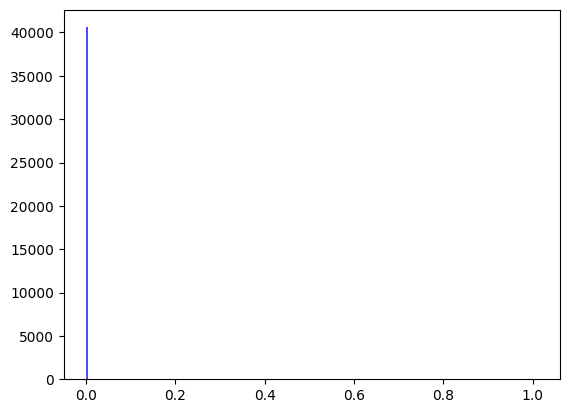

[2024-02-06T21:59:18.946630+00:00] Epochs 0, total loss: 1.08165e+05
[2024-02-06T21:59:18.956188+00:00] Training llk: -8.41859e-01
[2024-02-06T21:59:18.956809+00:00] Testing llk: -5.24655e-01
[2024-02-06T21:59:18.957323+00:00] MAE:3.58379, MRE:0.51459
saving model


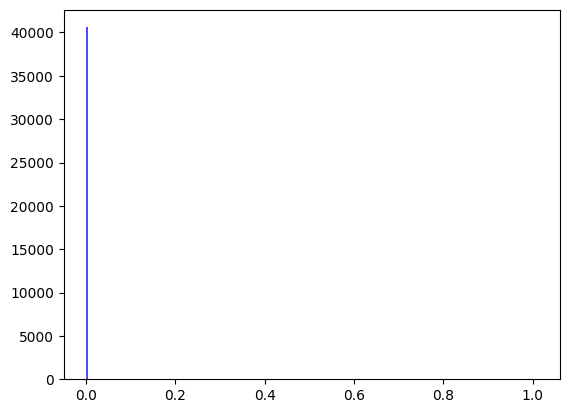

[2024-02-06T21:59:21.165765+00:00] Epochs 1, total loss: 8.73406e+04
[2024-02-06T21:59:21.166711+00:00] Training llk: -6.79778e-01
[2024-02-06T21:59:21.167114+00:00] Testing llk: -4.33116e-01
[2024-02-06T21:59:21.167492+00:00] MAE:3.53612, MRE:0.48966
saving model


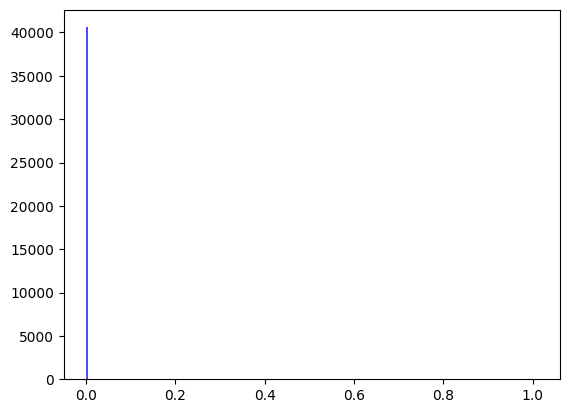

[2024-02-06T21:59:24.426399+00:00] Epochs 2, total loss: 8.25993e+04
[2024-02-06T21:59:24.442683+00:00] Training llk: -6.42876e-01
[2024-02-06T21:59:24.442885+00:00] Testing llk: -2.56104e-01
[2024-02-06T21:59:24.442974+00:00] MAE:3.39818, MRE:0.45354
saving model


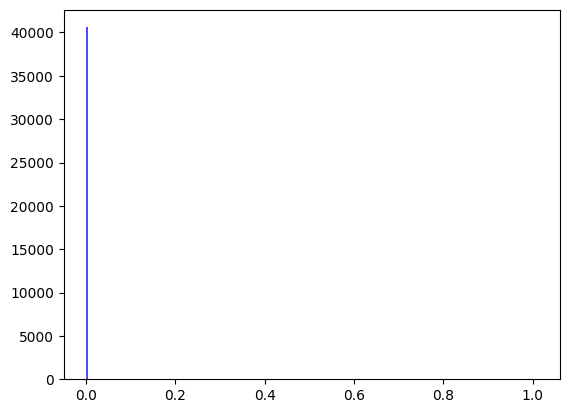

[2024-02-06T21:59:27.547371+00:00] Epochs 3, total loss: 8.13131e+04
[2024-02-06T21:59:27.548611+00:00] Training llk: -6.32865e-01
[2024-02-06T21:59:27.549258+00:00] Testing llk: -1.22701e-01
[2024-02-06T21:59:27.549816+00:00] MAE:3.26114, MRE:0.42613
saving model


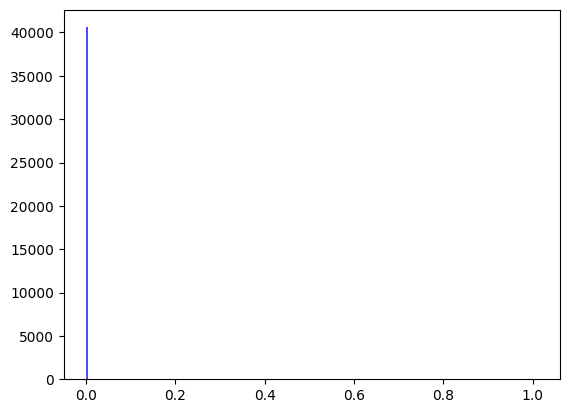

[2024-02-06T21:59:30.656994+00:00] Epochs 4, total loss: 7.64285e+04
[2024-02-06T21:59:30.657247+00:00] Training llk: -5.94848e-01
[2024-02-06T21:59:30.657348+00:00] Testing llk: -8.50274e-02
[2024-02-06T21:59:30.657431+00:00] MAE:3.22201, MRE:0.42484
saving model


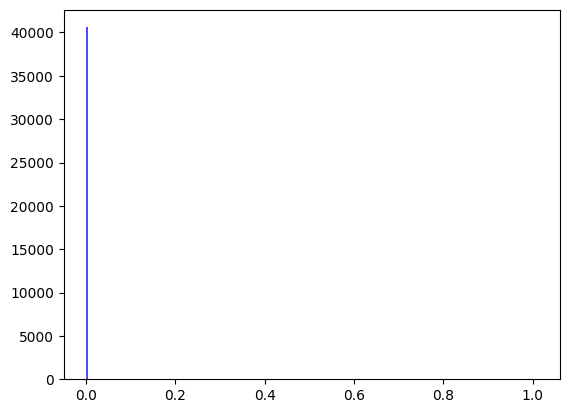

[2024-02-06T21:59:33.136621+00:00] Epochs 5, total loss: 8.72788e+04
[2024-02-06T21:59:33.137605+00:00] Training llk: -6.79297e-01
[2024-02-06T21:59:33.137767+00:00] Testing llk: -1.03051e-01
[2024-02-06T21:59:33.137864+00:00] MAE:3.25530, MRE:0.44191
saving model


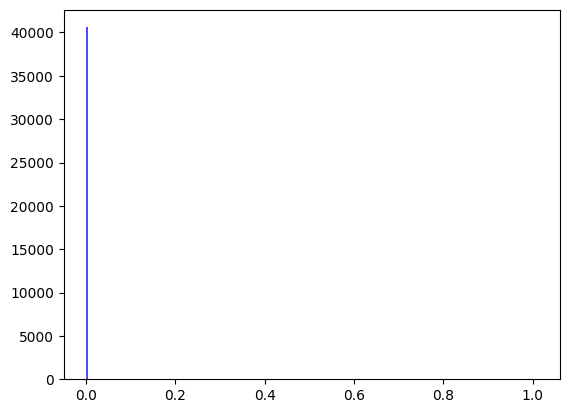

[2024-02-06T21:59:35.633965+00:00] Epochs 6, total loss: 8.20513e+04
[2024-02-06T21:59:35.635361+00:00] Training llk: -6.38611e-01
[2024-02-06T21:59:35.636060+00:00] Testing llk: -1.21337e-01
[2024-02-06T21:59:35.636711+00:00] MAE:3.28632, MRE:0.45872
saving model


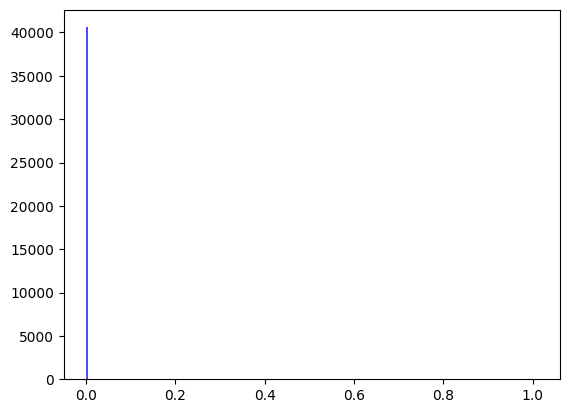

[2024-02-06T21:59:39.134276+00:00] Epochs 7, total loss: 8.10166e+04
[2024-02-06T21:59:39.134528+00:00] Training llk: -6.30558e-01
[2024-02-06T21:59:39.135961+00:00] Testing llk: -9.93541e-02
[2024-02-06T21:59:39.136104+00:00] MAE:3.26535, MRE:0.46004
saving model


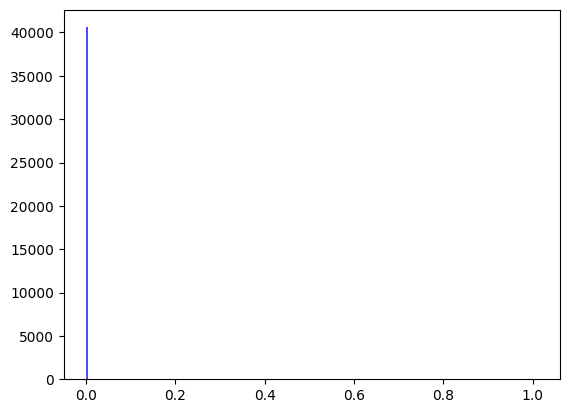

[2024-02-06T21:59:40.423649+00:00] Epochs 8, total loss: 7.18808e+04
[2024-02-06T21:59:40.424416+00:00] Training llk: -5.59454e-01
[2024-02-06T21:59:40.424778+00:00] Testing llk: -5.21572e-02
[2024-02-06T21:59:40.425088+00:00] MAE:3.20737, MRE:0.45136
saving model


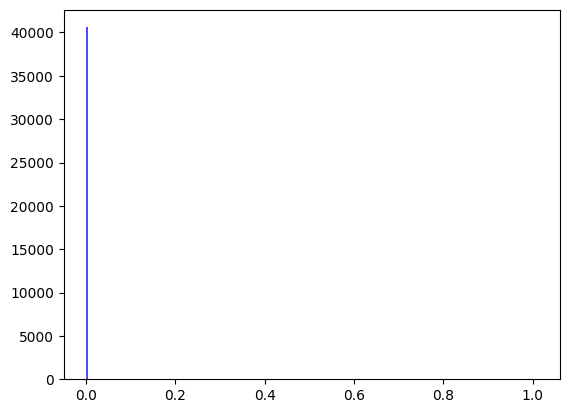

[2024-02-06T21:59:41.626867+00:00] Epochs 9, total loss: 7.91057e+04
[2024-02-06T21:59:41.627943+00:00] Training llk: -6.15685e-01
[2024-02-06T21:59:41.628072+00:00] Testing llk: -4.75361e-02
[2024-02-06T21:59:41.628199+00:00] MAE:3.20627, MRE:0.45645
saving model


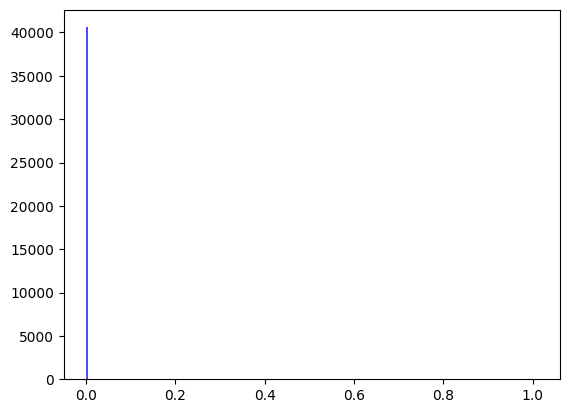

[2024-02-06T21:59:42.814848+00:00] Epochs 10, total loss: 7.51164e+04
[2024-02-06T21:59:42.815605+00:00] Training llk: -5.84636e-01
[2024-02-06T21:59:42.815946+00:00] Testing llk: -5.37671e-02
[2024-02-06T21:59:42.816243+00:00] MAE:3.22002, MRE:0.46452
saving model


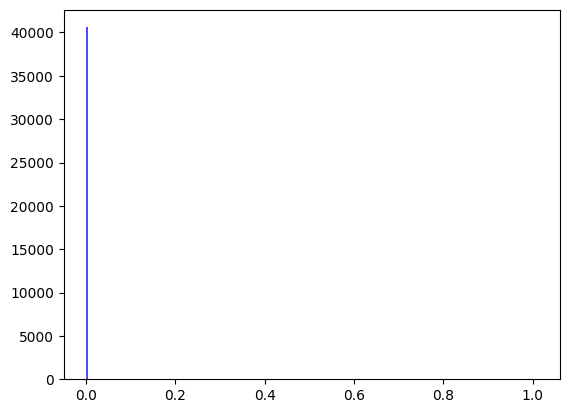

[2024-02-06T21:59:44.341510+00:00] Epochs 11, total loss: 7.25884e+04
[2024-02-06T21:59:44.342266+00:00] Training llk: -5.64961e-01
[2024-02-06T21:59:44.342574+00:00] Testing llk: -3.82893e-02
[2024-02-06T21:59:44.342892+00:00] MAE:3.20226, MRE:0.46447
saving model


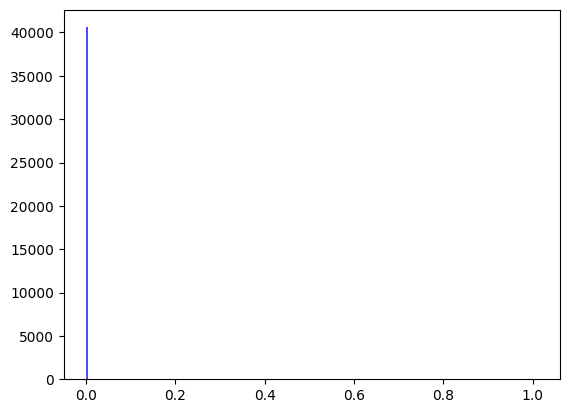

[2024-02-06T21:59:45.545470+00:00] Epochs 12, total loss: 7.39921e+04
[2024-02-06T21:59:45.546110+00:00] Training llk: -5.75886e-01
[2024-02-06T21:59:45.546226+00:00] Testing llk: -3.04765e-02
[2024-02-06T21:59:45.546308+00:00] MAE:3.19476, MRE:0.46642
saving model


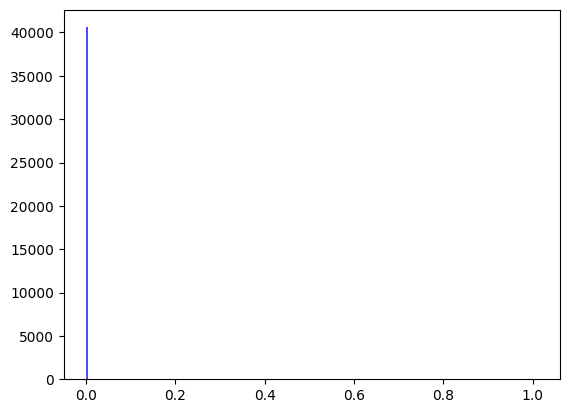

[2024-02-06T21:59:46.746900+00:00] Epochs 13, total loss: 7.35428e+04
[2024-02-06T21:59:46.747092+00:00] Training llk: -5.72389e-01
[2024-02-06T21:59:46.747178+00:00] Testing llk: -2.26950e-02
[2024-02-06T21:59:46.747425+00:00] MAE:3.18669, MRE:0.46784
saving model


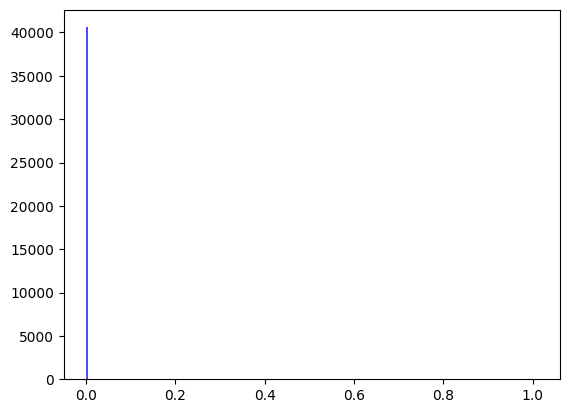

[2024-02-06T21:59:47.964355+00:00] Epochs 14, total loss: 7.01530e+04
[2024-02-06T21:59:47.964550+00:00] Training llk: -5.46006e-01
[2024-02-06T21:59:47.964637+00:00] Testing llk: -1.78209e-02
[2024-02-06T21:59:47.964718+00:00] MAE:3.18244, MRE:0.46977
saving model


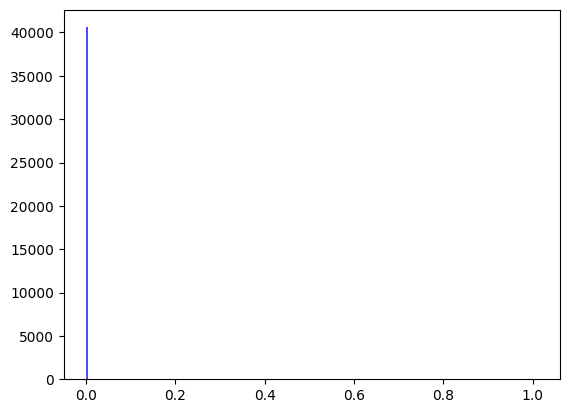

[2024-02-06T21:59:49.178230+00:00] Epochs 15, total loss: 7.93255e+04
[2024-02-06T21:59:49.179004+00:00] Training llk: -6.17396e-01
[2024-02-06T21:59:49.179314+00:00] Testing llk: -2.25877e-02
[2024-02-06T21:59:49.179597+00:00] MAE:3.19226, MRE:0.47446
saving model


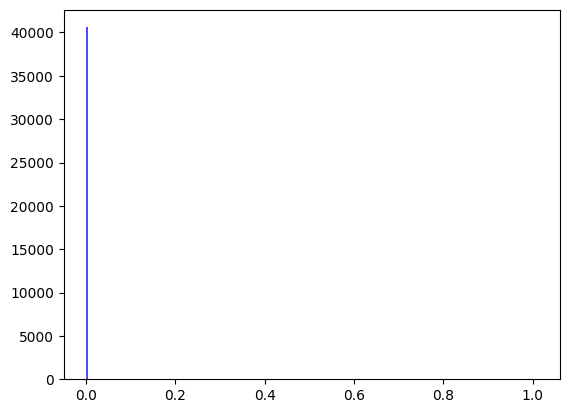

[2024-02-06T21:59:50.892018+00:00] Epochs 16, total loss: 7.85419e+04
[2024-02-06T21:59:50.892263+00:00] Training llk: -6.11297e-01
[2024-02-06T21:59:50.892358+00:00] Testing llk: -3.95419e-02
[2024-02-06T21:59:50.892432+00:00] MAE:3.21909, MRE:0.48265
saving model


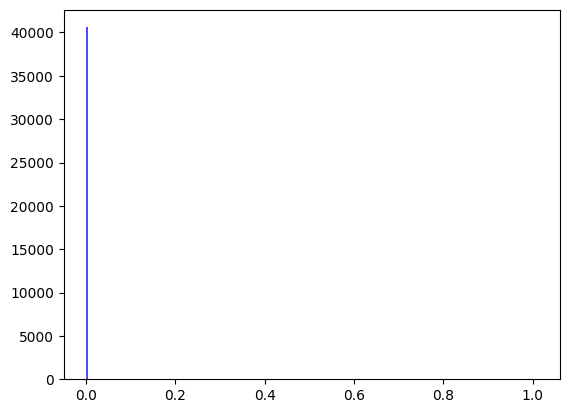

[2024-02-06T21:59:52.356762+00:00] Epochs 17, total loss: 7.92393e+04
[2024-02-06T21:59:52.357513+00:00] Training llk: -6.16725e-01
[2024-02-06T21:59:52.357880+00:00] Testing llk: -2.38034e-02
[2024-02-06T21:59:52.358177+00:00] MAE:3.19875, MRE:0.48034
saving model


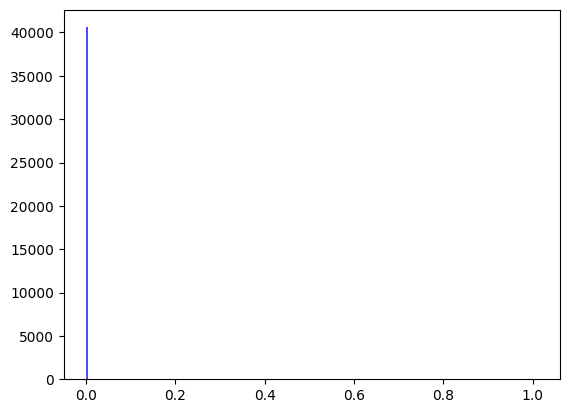

[2024-02-06T21:59:53.822153+00:00] Epochs 18, total loss: 7.64109e+04
[2024-02-06T21:59:53.822356+00:00] Training llk: -5.94711e-01
[2024-02-06T21:59:53.822443+00:00] Testing llk: -6.96319e-03
[2024-02-06T21:59:53.822513+00:00] MAE:3.17571, MRE:0.47749
saving model


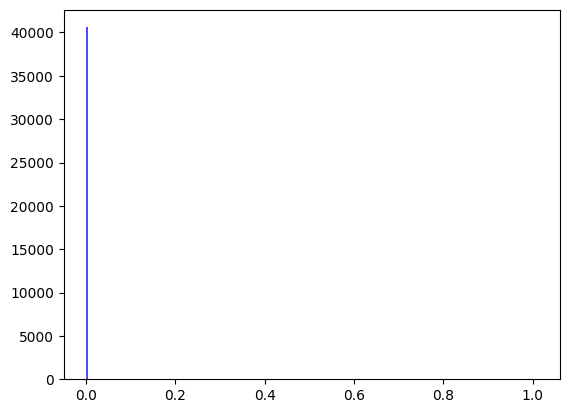

[2024-02-06T21:59:55.045632+00:00] Epochs 19, total loss: 7.28741e+04
[2024-02-06T21:59:55.046414+00:00] Training llk: -5.67184e-01
[2024-02-06T21:59:55.046794+00:00] Testing llk: -3.75436e-03
[2024-02-06T21:59:55.046897+00:00] MAE:3.17275, MRE:0.47875
saving model


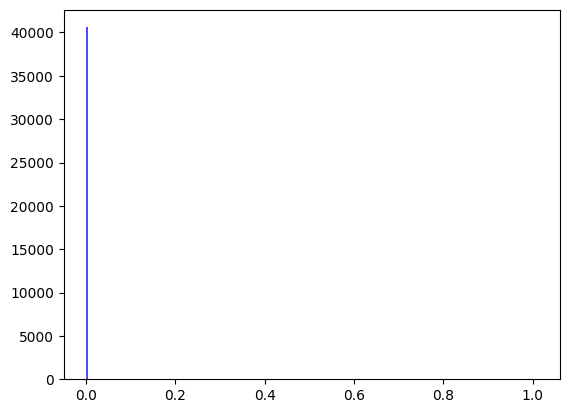

[2024-02-06T21:59:56.211226+00:00] Epochs 20, total loss: 7.62423e+04
[2024-02-06T21:59:56.211420+00:00] Training llk: -5.93399e-01
[2024-02-06T21:59:56.211506+00:00] Testing llk: -1.26314e-02
[2024-02-06T21:59:56.211573+00:00] MAE:3.18795, MRE:0.48356
saving model


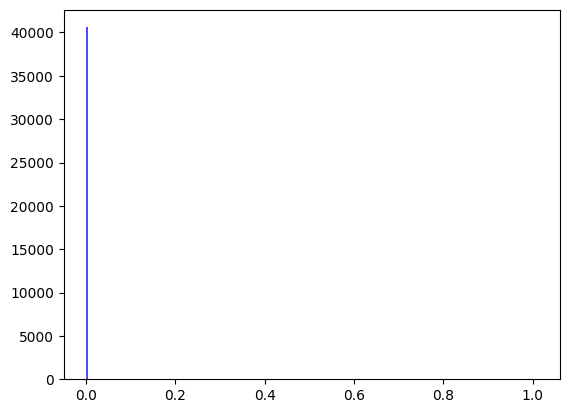

[2024-02-06T21:59:57.397157+00:00] Epochs 21, total loss: 7.73079e+04
[2024-02-06T21:59:57.397914+00:00] Training llk: -6.01693e-01
[2024-02-06T21:59:57.398530+00:00] Testing llk: -1.14208e-02
[2024-02-06T21:59:57.398917+00:00] MAE:3.18768, MRE:0.48500
saving model


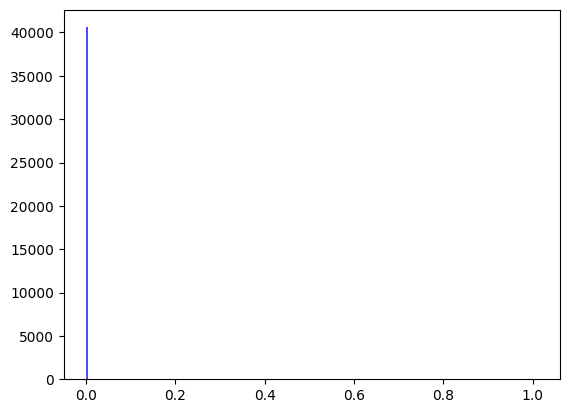

[2024-02-06T21:59:58.576476+00:00] Epochs 22, total loss: 7.58882e+04
[2024-02-06T21:59:58.577069+00:00] Training llk: -5.90643e-01
[2024-02-06T21:59:58.577176+00:00] Testing llk: 4.99166e-03
[2024-02-06T21:59:58.577251+00:00] MAE:3.16397, MRE:0.48160
saving model


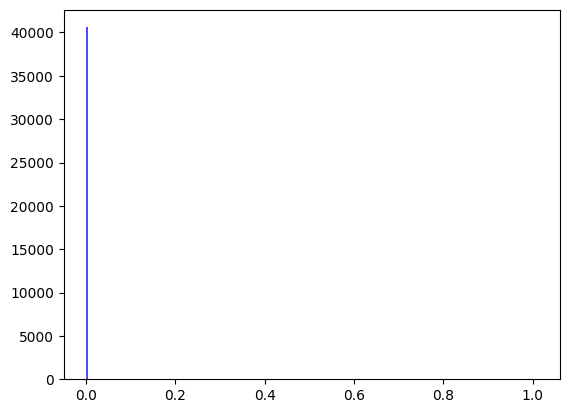

[2024-02-06T21:59:59.758780+00:00] Epochs 23, total loss: 8.16207e+04
[2024-02-06T21:59:59.758993+00:00] Training llk: -6.35260e-01
[2024-02-06T21:59:59.759081+00:00] Testing llk: -1.82226e-02
[2024-02-06T21:59:59.759150+00:00] MAE:3.20038, MRE:0.49023
saving model


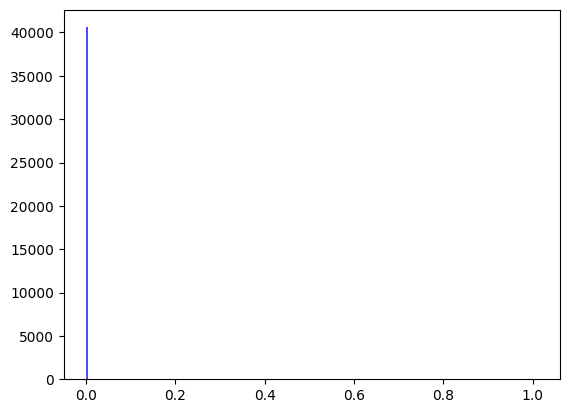

[2024-02-06T22:00:00.974299+00:00] Epochs 24, total loss: 7.69336e+04
[2024-02-06T22:00:00.974500+00:00] Training llk: -5.98779e-01
[2024-02-06T22:00:00.974587+00:00] Testing llk: -1.85319e-02
[2024-02-06T22:00:00.974657+00:00] MAE:3.20194, MRE:0.49164
saving model


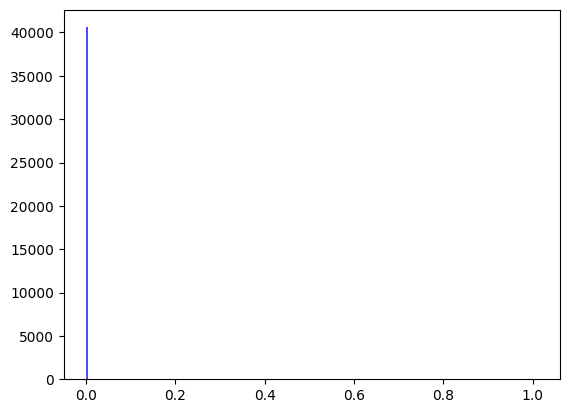

[2024-02-06T22:00:02.805900+00:00] Epochs 25, total loss: 7.56203e+04
[2024-02-06T22:00:02.806981+00:00] Training llk: -5.88558e-01
[2024-02-06T22:00:02.807480+00:00] Testing llk: 5.96206e-03
[2024-02-06T22:00:02.807985+00:00] MAE:3.16595, MRE:0.48543
saving model


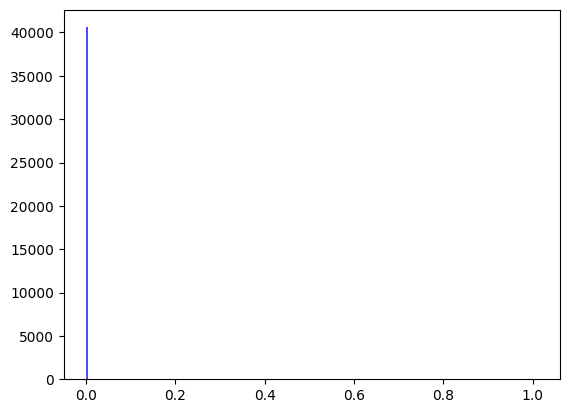

[2024-02-06T22:00:04.441352+00:00] Epochs 26, total loss: 7.70754e+04
[2024-02-06T22:00:04.441938+00:00] Training llk: -5.99883e-01
[2024-02-06T22:00:04.442041+00:00] Testing llk: 3.76308e-03
[2024-02-06T22:00:04.442115+00:00] MAE:3.17031, MRE:0.48723
saving model


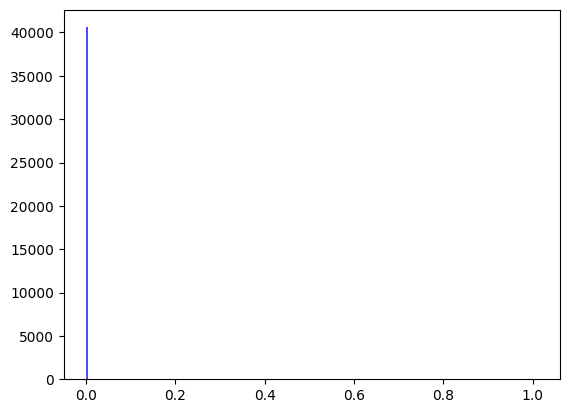

[2024-02-06T22:00:05.679067+00:00] Epochs 27, total loss: 7.50443e+04
[2024-02-06T22:00:05.679273+00:00] Training llk: -5.84075e-01
[2024-02-06T22:00:05.679358+00:00] Testing llk: 5.37115e-03
[2024-02-06T22:00:05.679427+00:00] MAE:3.16870, MRE:0.48780
saving model


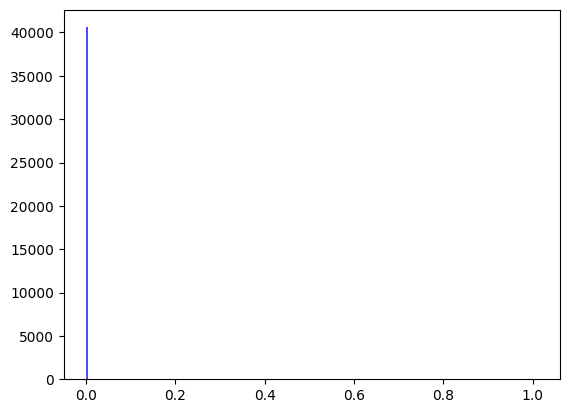

[2024-02-06T22:00:06.900452+00:00] Epochs 28, total loss: 7.22840e+04
[2024-02-06T22:00:06.900655+00:00] Training llk: -5.62591e-01
[2024-02-06T22:00:06.900780+00:00] Testing llk: 1.06231e-02
[2024-02-06T22:00:06.900849+00:00] MAE:3.16127, MRE:0.48717
saving model


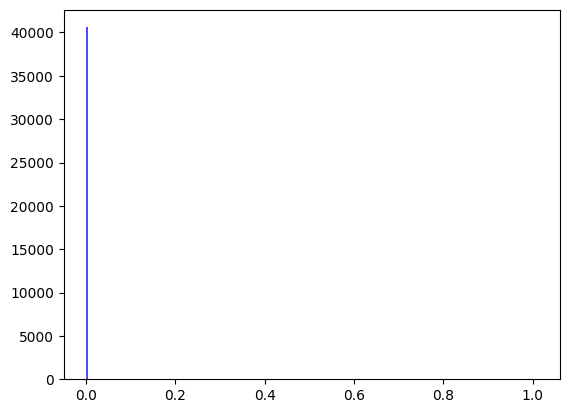

[2024-02-06T22:00:08.111819+00:00] Epochs 29, total loss: 7.70906e+04
[2024-02-06T22:00:08.112574+00:00] Training llk: -6.00002e-01
[2024-02-06T22:00:08.112937+00:00] Testing llk: 6.19518e-05
[2024-02-06T22:00:08.113040+00:00] MAE:3.17844, MRE:0.49127
saving model


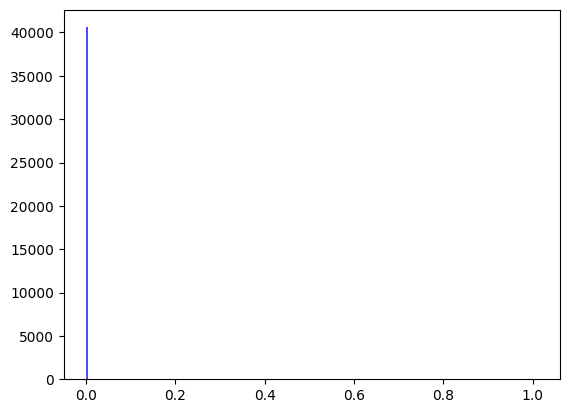

[2024-02-06T22:00:09.334218+00:00] Epochs 30, total loss: 7.22687e+04
[2024-02-06T22:00:09.334984+00:00] Training llk: -5.62473e-01
[2024-02-06T22:00:09.335104+00:00] Testing llk: 2.59715e-02
[2024-02-06T22:00:09.335191+00:00] MAE:3.13817, MRE:0.48440
saving model


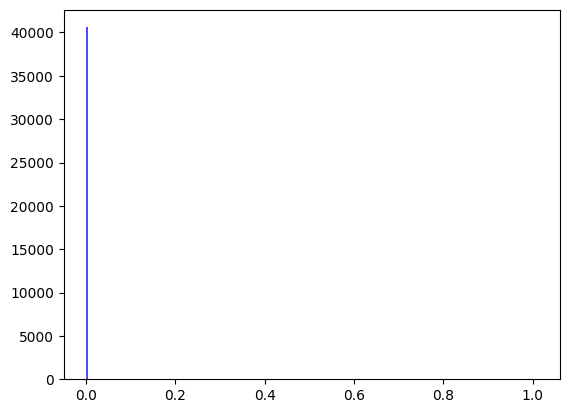

[2024-02-06T22:00:10.847539+00:00] Epochs 31, total loss: 7.91350e+04
[2024-02-06T22:00:10.847756+00:00] Training llk: -6.15913e-01
[2024-02-06T22:00:10.847855+00:00] Testing llk: -1.87387e-03
[2024-02-06T22:00:10.847927+00:00] MAE:3.18275, MRE:0.49352
saving model


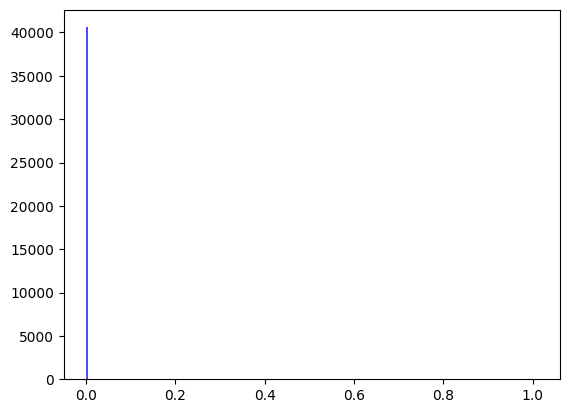

[2024-02-06T22:00:12.078232+00:00] Epochs 32, total loss: 8.17868e+04
[2024-02-06T22:00:12.078436+00:00] Training llk: -6.36552e-01
[2024-02-06T22:00:12.078525+00:00] Testing llk: -1.82658e-02
[2024-02-06T22:00:12.078592+00:00] MAE:3.20768, MRE:0.49909
saving model


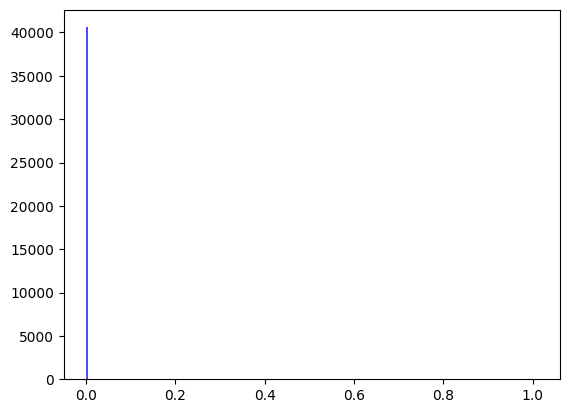

[2024-02-06T22:00:13.307024+00:00] Epochs 33, total loss: 7.25777e+04
[2024-02-06T22:00:13.307227+00:00] Training llk: -5.64877e-01
[2024-02-06T22:00:13.307314+00:00] Testing llk: 2.21756e-02
[2024-02-06T22:00:13.307383+00:00] MAE:3.14622, MRE:0.48780
saving model


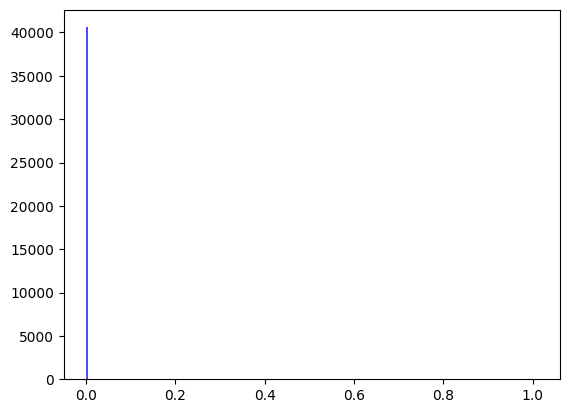

[2024-02-06T22:00:14.754283+00:00] Epochs 34, total loss: 7.60647e+04
[2024-02-06T22:00:14.755349+00:00] Training llk: -5.92017e-01
[2024-02-06T22:00:14.755855+00:00] Testing llk: 1.90200e-02
[2024-02-06T22:00:14.756325+00:00] MAE:3.15183, MRE:0.48938
saving model


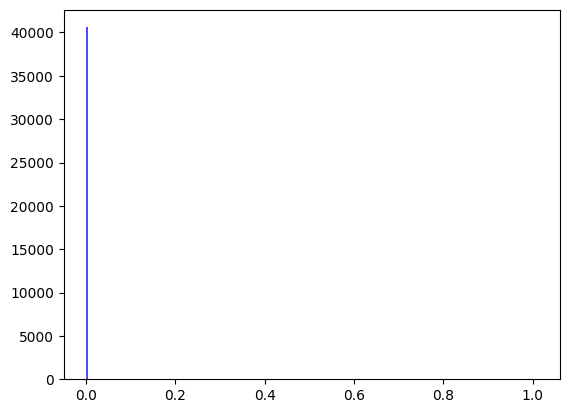

[2024-02-06T22:00:16.583191+00:00] Epochs 35, total loss: 8.50426e+04
[2024-02-06T22:00:16.583418+00:00] Training llk: -6.61892e-01
[2024-02-06T22:00:16.583499+00:00] Testing llk: -1.79829e-02
[2024-02-06T22:00:16.583576+00:00] MAE:3.20873, MRE:0.50084
saving model


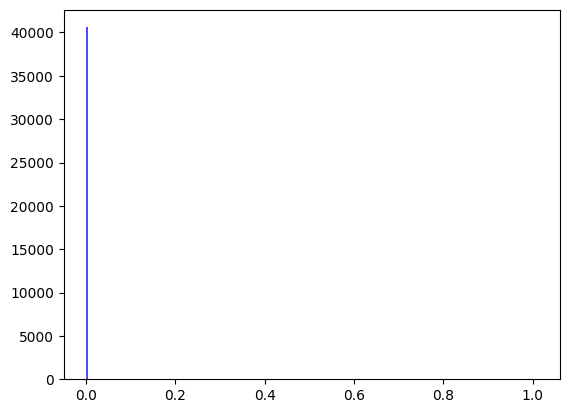

[2024-02-06T22:00:17.798408+00:00] Epochs 36, total loss: 7.74004e+04
[2024-02-06T22:00:17.799232+00:00] Training llk: -6.02413e-01
[2024-02-06T22:00:17.799549+00:00] Testing llk: -1.48675e-03
[2024-02-06T22:00:17.799862+00:00] MAE:3.18466, MRE:0.49651
saving model


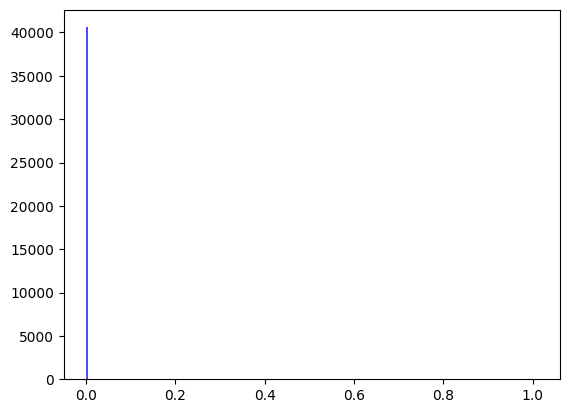

[2024-02-06T22:00:18.996052+00:00] Epochs 37, total loss: 7.06522e+04
[2024-02-06T22:00:18.996249+00:00] Training llk: -5.49891e-01
[2024-02-06T22:00:18.996342+00:00] Testing llk: 4.30534e-02
[2024-02-06T22:00:18.996412+00:00] MAE:3.11332, MRE:0.48390
saving model


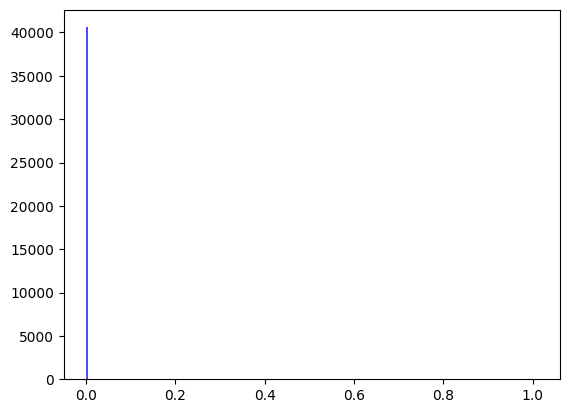

[2024-02-06T22:00:20.484237+00:00] Epochs 38, total loss: 7.44747e+04
[2024-02-06T22:00:20.484454+00:00] Training llk: -5.79642e-01
[2024-02-06T22:00:20.484552+00:00] Testing llk: 1.32764e-02
[2024-02-06T22:00:20.484623+00:00] MAE:3.16258, MRE:0.49308
saving model


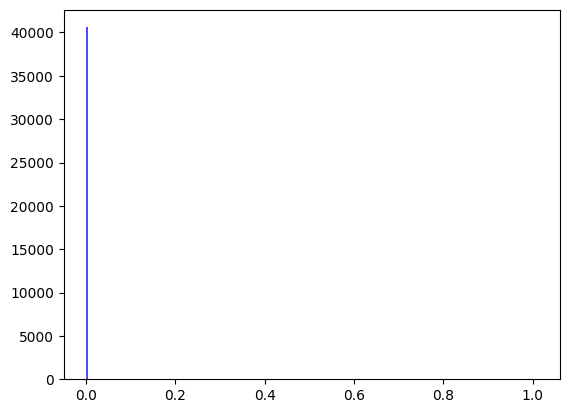

[2024-02-06T22:00:21.727716+00:00] Epochs 39, total loss: 7.43157e+04
[2024-02-06T22:00:21.728040+00:00] Training llk: -5.78404e-01
[2024-02-06T22:00:21.728165+00:00] Testing llk: -2.85923e-03
[2024-02-06T22:00:21.728242+00:00] MAE:3.18779, MRE:0.49823
saving model


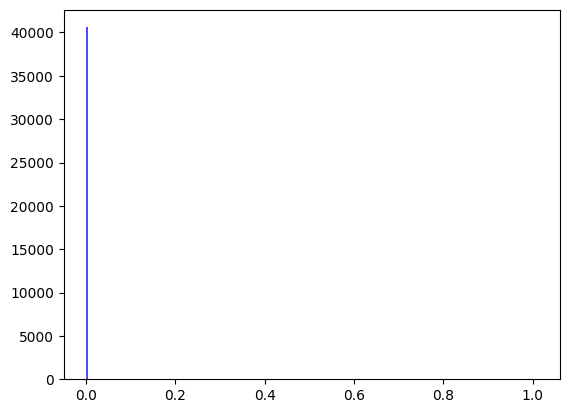

[2024-02-06T22:00:23.009576+00:00] Epochs 40, total loss: 7.40971e+04
[2024-02-06T22:00:23.010379+00:00] Training llk: -5.76703e-01
[2024-02-06T22:00:23.010806+00:00] Testing llk: 2.58774e-02
[2024-02-06T22:00:23.010923+00:00] MAE:3.14312, MRE:0.49026
saving model


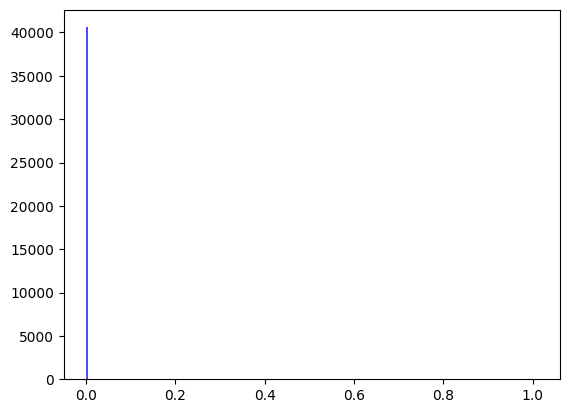

[2024-02-06T22:00:24.244225+00:00] Epochs 41, total loss: 7.49548e+04
[2024-02-06T22:00:24.244768+00:00] Training llk: -5.83379e-01
[2024-02-06T22:00:24.244873+00:00] Testing llk: 2.14313e-02
[2024-02-06T22:00:24.246225+00:00] MAE:3.15061, MRE:0.49193
saving model


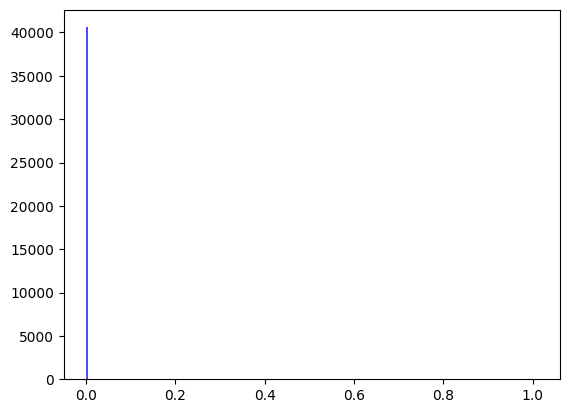

[2024-02-06T22:00:25.469480+00:00] Epochs 42, total loss: 7.96650e+04
[2024-02-06T22:00:25.470078+00:00] Training llk: -6.20038e-01
[2024-02-06T22:00:25.470196+00:00] Testing llk: 2.54912e-04
[2024-02-06T22:00:25.471481+00:00] MAE:3.18392, MRE:0.49840
saving model


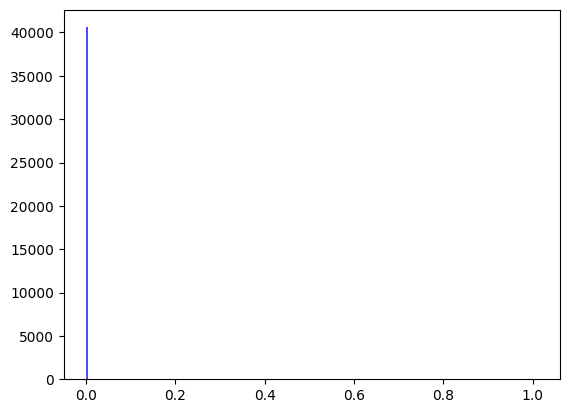

[2024-02-06T22:00:26.800447+00:00] Epochs 43, total loss: 7.03746e+04
[2024-02-06T22:00:26.801540+00:00] Training llk: -5.47731e-01
[2024-02-06T22:00:26.802078+00:00] Testing llk: 2.65598e-02
[2024-02-06T22:00:26.802552+00:00] MAE:3.14281, MRE:0.49107
saving model


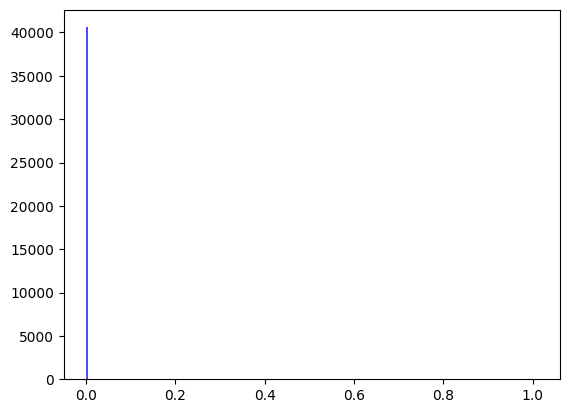

[2024-02-06T22:00:28.591725+00:00] Epochs 44, total loss: 6.89971e+04
[2024-02-06T22:00:28.592912+00:00] Training llk: -5.37009e-01
[2024-02-06T22:00:28.593481+00:00] Testing llk: 3.84815e-02
[2024-02-06T22:00:28.594457+00:00] MAE:3.12328, MRE:0.48791
saving model


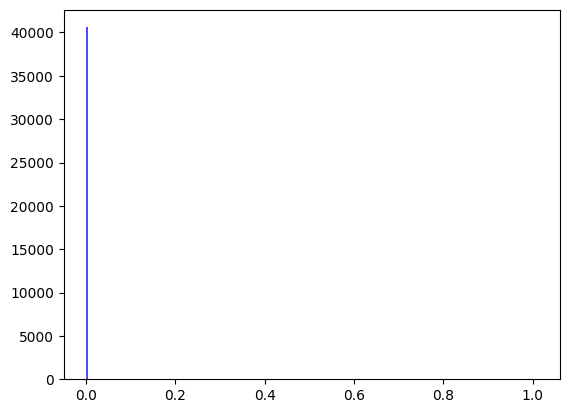

[2024-02-06T22:00:30.248858+00:00] Epochs 45, total loss: 7.20427e+04
[2024-02-06T22:00:30.249057+00:00] Training llk: -5.60713e-01
[2024-02-06T22:00:30.249139+00:00] Testing llk: 2.08010e-02
[2024-02-06T22:00:30.249213+00:00] MAE:3.15264, MRE:0.49340
saving model


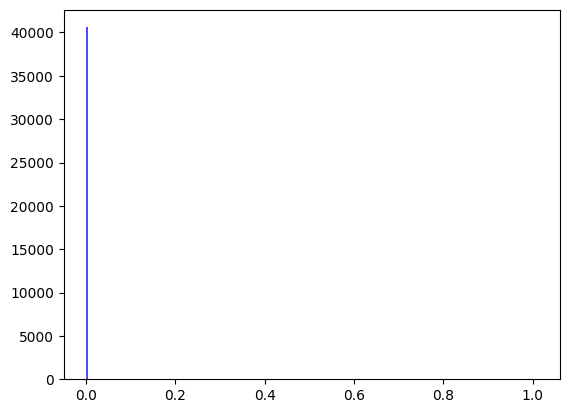

[2024-02-06T22:00:31.455404+00:00] Epochs 46, total loss: 6.85238e+04
[2024-02-06T22:00:31.456174+00:00] Training llk: -5.33326e-01
[2024-02-06T22:00:31.456308+00:00] Testing llk: 2.50265e-02
[2024-02-06T22:00:31.456378+00:00] MAE:3.14602, MRE:0.49241
saving model


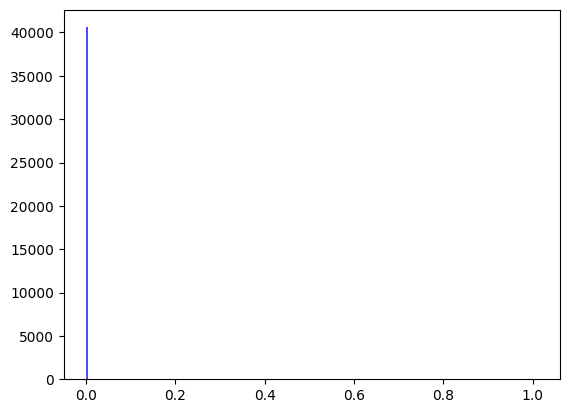

[2024-02-06T22:00:32.653732+00:00] Epochs 47, total loss: 7.21498e+04
[2024-02-06T22:00:32.654484+00:00] Training llk: -5.61547e-01
[2024-02-06T22:00:32.654606+00:00] Testing llk: 2.66440e-02
[2024-02-06T22:00:32.655658+00:00] MAE:3.14352, MRE:0.49211
saving model


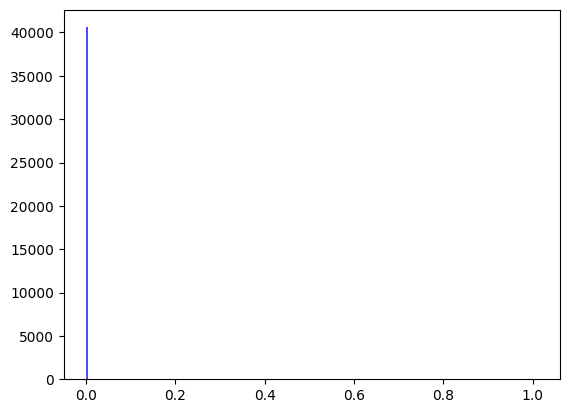

[2024-02-06T22:00:33.873482+00:00] Epochs 48, total loss: 7.15556e+04
[2024-02-06T22:00:33.874152+00:00] Training llk: -5.56923e-01
[2024-02-06T22:00:33.874273+00:00] Testing llk: 3.07696e-02
[2024-02-06T22:00:33.874365+00:00] MAE:3.13694, MRE:0.49114
saving model


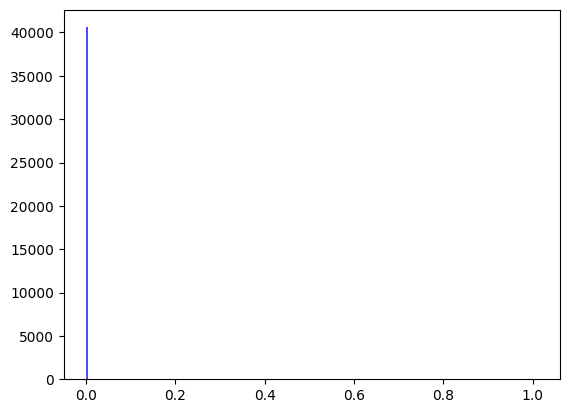

[2024-02-06T22:00:35.181179+00:00] Epochs 49, total loss: 8.18931e+04
[2024-02-06T22:00:35.181931+00:00] Training llk: -6.37380e-01
[2024-02-06T22:00:35.182043+00:00] Testing llk: -6.02693e-03
[2024-02-06T22:00:35.182125+00:00] MAE:3.19481, MRE:0.50206
saving model


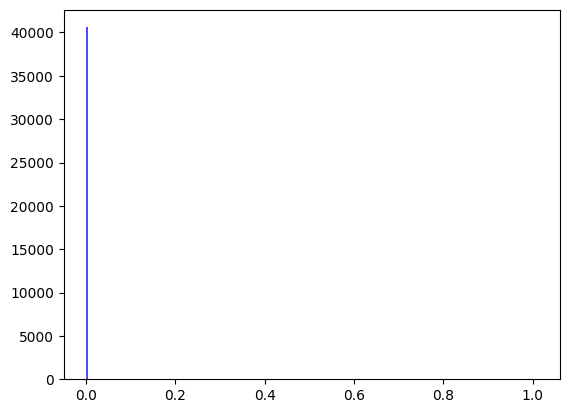

[2024-02-06T22:00:36.385137+00:00] Epochs 50, total loss: 7.80315e+04
[2024-02-06T22:00:36.385912+00:00] Training llk: -6.07324e-01
[2024-02-06T22:00:36.386028+00:00] Testing llk: 6.03384e-04
[2024-02-06T22:00:36.386106+00:00] MAE:3.18497, MRE:0.50033
saving model


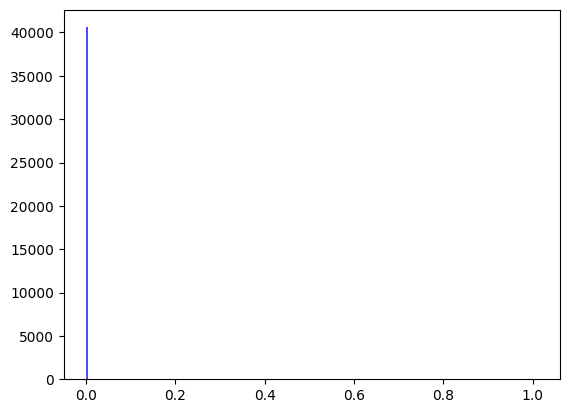

[2024-02-06T22:00:37.600368+00:00] Epochs 51, total loss: 7.20626e+04
[2024-02-06T22:00:37.600964+00:00] Training llk: -5.60868e-01
[2024-02-06T22:00:37.601074+00:00] Testing llk: 4.16426e-02
[2024-02-06T22:00:37.601161+00:00] MAE:3.11924, MRE:0.48862
saving model


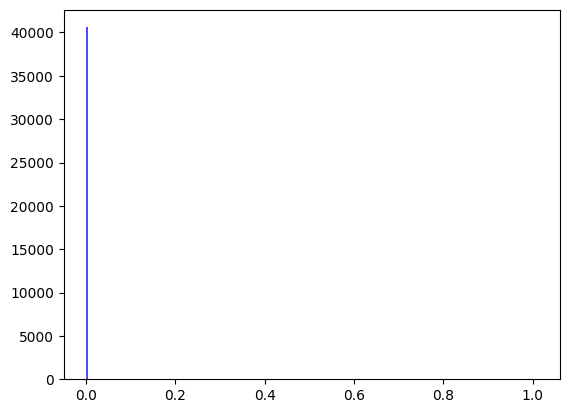

[2024-02-06T22:00:39.224691+00:00] Epochs 52, total loss: 7.66423e+04
[2024-02-06T22:00:39.225893+00:00] Training llk: -5.96512e-01
[2024-02-06T22:00:39.226503+00:00] Testing llk: 1.58653e-02
[2024-02-06T22:00:39.227107+00:00] MAE:3.16159, MRE:0.49623
saving model


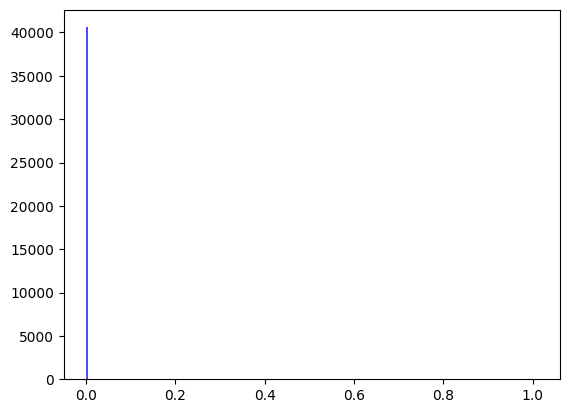

[2024-02-06T22:00:41.077275+00:00] Epochs 53, total loss: 7.26200e+04
[2024-02-06T22:00:41.077515+00:00] Training llk: -5.65206e-01
[2024-02-06T22:00:41.077601+00:00] Testing llk: 7.49225e-03
[2024-02-06T22:00:41.077704+00:00] MAE:3.17470, MRE:0.49870
saving model


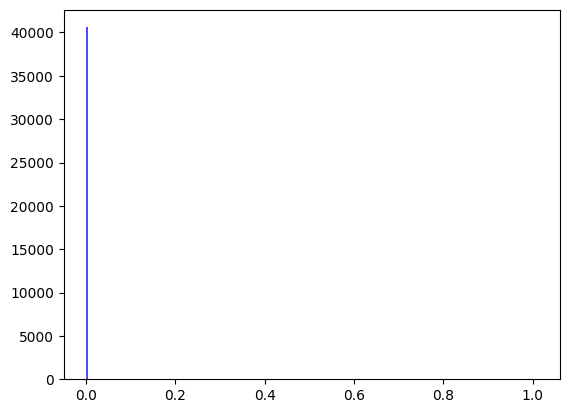

[2024-02-06T22:00:42.397472+00:00] Epochs 54, total loss: 6.83546e+04
[2024-02-06T22:00:42.397703+00:00] Training llk: -5.32008e-01
[2024-02-06T22:00:42.397791+00:00] Testing llk: 4.15298e-02
[2024-02-06T22:00:42.397860+00:00] MAE:3.11964, MRE:0.48892
saving model


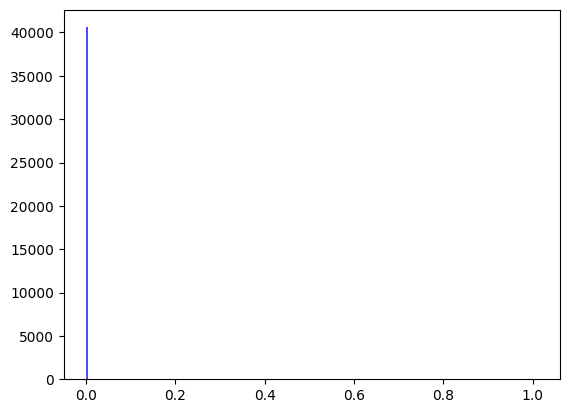

[2024-02-06T22:00:43.612400+00:00] Epochs 55, total loss: 7.39270e+04
[2024-02-06T22:00:43.612994+00:00] Training llk: -5.75379e-01
[2024-02-06T22:00:43.613104+00:00] Testing llk: 2.83717e-02
[2024-02-06T22:00:43.613192+00:00] MAE:3.14167, MRE:0.49284
saving model


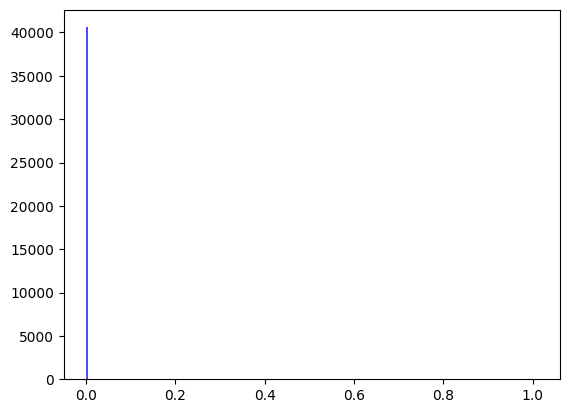

[2024-02-06T22:00:44.851339+00:00] Epochs 56, total loss: 7.64235e+04
[2024-02-06T22:00:44.851546+00:00] Training llk: -5.94809e-01
[2024-02-06T22:00:44.851632+00:00] Testing llk: -1.90249e-03
[2024-02-06T22:00:44.851718+00:00] MAE:3.18923, MRE:0.50166
saving model


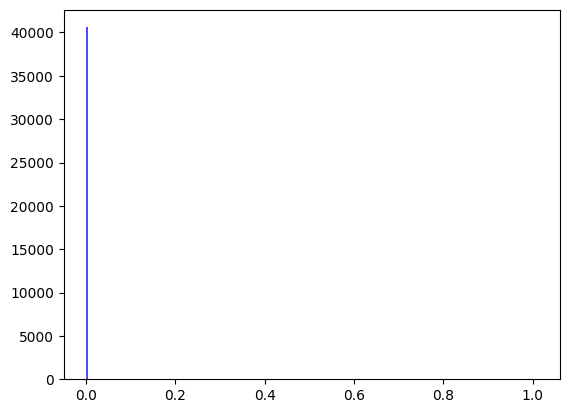

[2024-02-06T22:00:46.126332+00:00] Epochs 57, total loss: 7.85299e+04
[2024-02-06T22:00:46.126535+00:00] Training llk: -6.11204e-01
[2024-02-06T22:00:46.126623+00:00] Testing llk: 1.64490e-02
[2024-02-06T22:00:46.126715+00:00] MAE:3.16100, MRE:0.49648
saving model


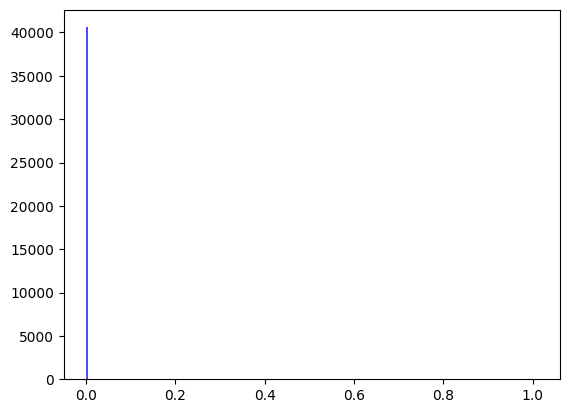

[2024-02-06T22:00:47.578451+00:00] Epochs 58, total loss: 7.12564e+04
[2024-02-06T22:00:47.578657+00:00] Training llk: -5.54593e-01
[2024-02-06T22:00:47.578757+00:00] Testing llk: 2.48821e-02
[2024-02-06T22:00:47.578824+00:00] MAE:3.14760, MRE:0.49417
saving model


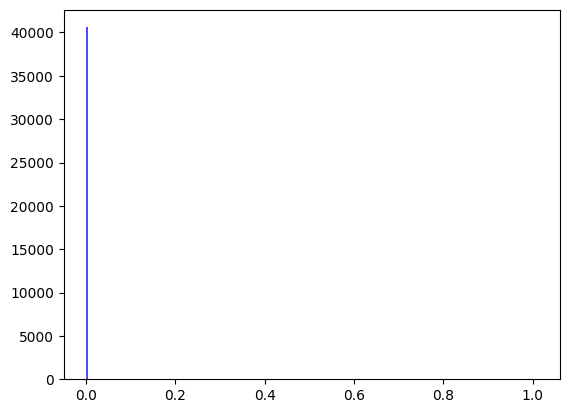

[2024-02-06T22:00:48.779265+00:00] Epochs 59, total loss: 6.97694e+04
[2024-02-06T22:00:48.779795+00:00] Training llk: -5.43020e-01
[2024-02-06T22:00:48.779891+00:00] Testing llk: 3.36743e-02
[2024-02-06T22:00:48.779962+00:00] MAE:3.13322, MRE:0.49168
saving model


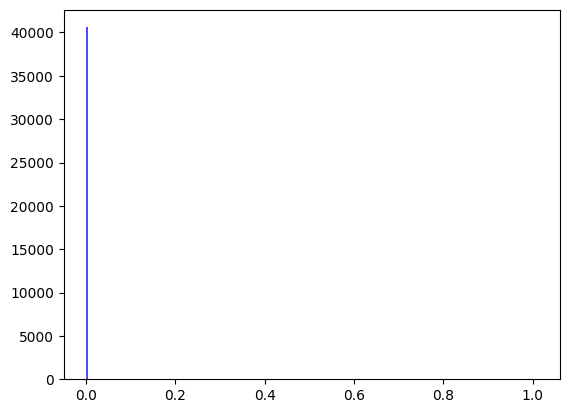

[2024-02-06T22:00:49.989853+00:00] Epochs 60, total loss: 7.61854e+04
[2024-02-06T22:00:49.990601+00:00] Training llk: -5.92956e-01
[2024-02-06T22:00:49.990982+00:00] Testing llk: 1.87265e-02
[2024-02-06T22:00:49.991283+00:00] MAE:3.15756, MRE:0.49605
saving model


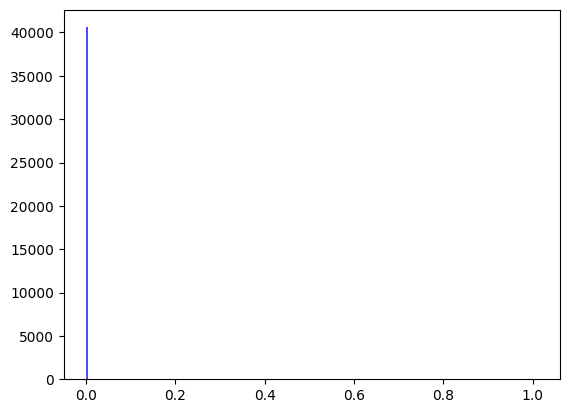

[2024-02-06T22:00:51.189970+00:00] Epochs 61, total loss: 7.53198e+04
[2024-02-06T22:00:51.190839+00:00] Training llk: -5.86219e-01
[2024-02-06T22:00:51.190968+00:00] Testing llk: 1.23534e-02
[2024-02-06T22:00:51.191887+00:00] MAE:3.16768, MRE:0.49797
saving model


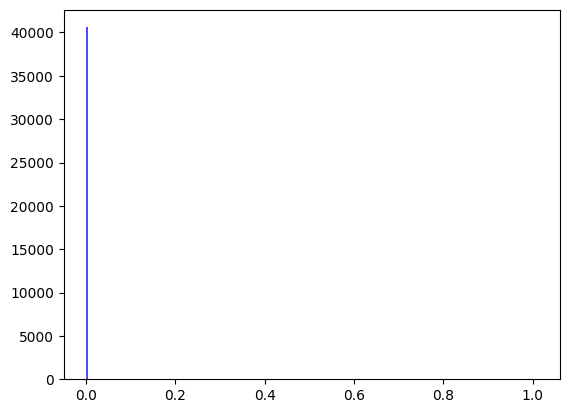

[2024-02-06T22:00:52.882207+00:00] Epochs 62, total loss: 7.37210e+04
[2024-02-06T22:00:52.883582+00:00] Training llk: -5.73776e-01
[2024-02-06T22:00:52.884328+00:00] Testing llk: 3.55987e-02
[2024-02-06T22:00:52.885750+00:00] MAE:3.13024, MRE:0.49142
saving model


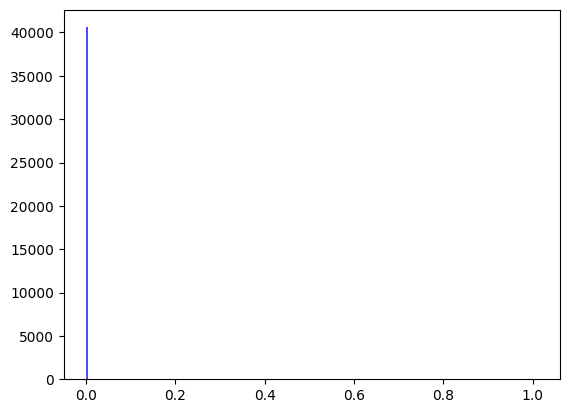

[2024-02-06T22:00:54.414432+00:00] Epochs 63, total loss: 7.68700e+04
[2024-02-06T22:00:54.415022+00:00] Training llk: -5.98285e-01
[2024-02-06T22:00:54.415134+00:00] Testing llk: 4.40955e-03
[2024-02-06T22:00:54.415214+00:00] MAE:3.18015, MRE:0.50051
saving model


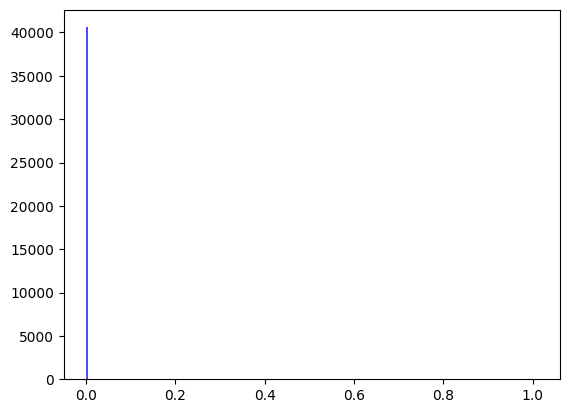

[2024-02-06T22:00:55.605808+00:00] Epochs 64, total loss: 7.61382e+04
[2024-02-06T22:00:55.606569+00:00] Training llk: -5.92589e-01
[2024-02-06T22:00:55.606934+00:00] Testing llk: 1.91312e-02
[2024-02-06T22:00:55.607049+00:00] MAE:3.15714, MRE:0.49623
saving model


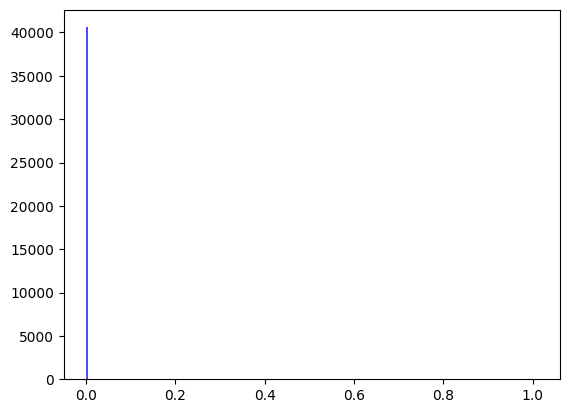

[2024-02-06T22:00:56.819413+00:00] Epochs 65, total loss: 6.87008e+04
[2024-02-06T22:00:56.819731+00:00] Training llk: -5.34703e-01
[2024-02-06T22:00:56.819862+00:00] Testing llk: 3.88647e-02
[2024-02-06T22:00:56.819949+00:00] MAE:3.12483, MRE:0.49055
saving model


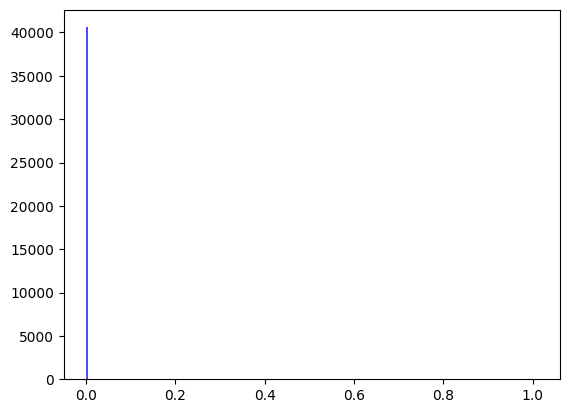

[2024-02-06T22:00:58.353896+00:00] Epochs 66, total loss: 7.36952e+04
[2024-02-06T22:00:58.354091+00:00] Training llk: -5.73575e-01
[2024-02-06T22:00:58.354180+00:00] Testing llk: 3.04310e-02
[2024-02-06T22:00:58.354246+00:00] MAE:3.13886, MRE:0.49297
saving model


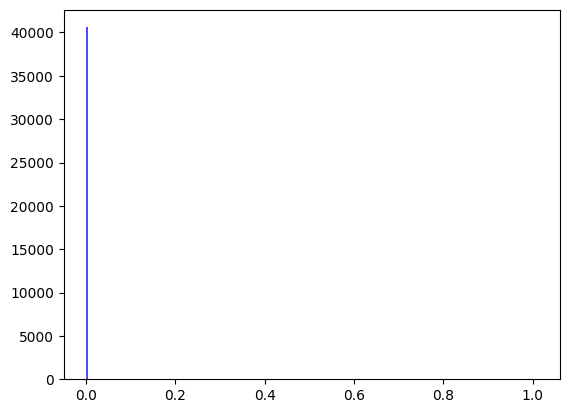

[2024-02-06T22:00:59.573924+00:00] Epochs 67, total loss: 7.12958e+04
[2024-02-06T22:00:59.574133+00:00] Training llk: -5.54900e-01
[2024-02-06T22:00:59.574224+00:00] Testing llk: 2.03921e-02
[2024-02-06T22:00:59.574296+00:00] MAE:3.15513, MRE:0.49587
saving model


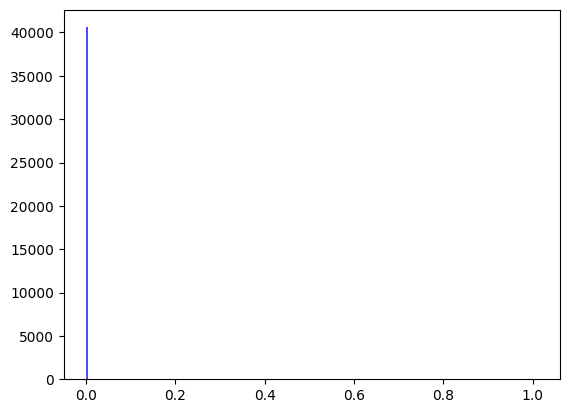

[2024-02-06T22:01:00.815283+00:00] Epochs 68, total loss: 7.59249e+04
[2024-02-06T22:01:00.815840+00:00] Training llk: -5.90929e-01
[2024-02-06T22:01:00.815953+00:00] Testing llk: 2.34602e-02
[2024-02-06T22:01:00.816037+00:00] MAE:3.15023, MRE:0.49501
saving model


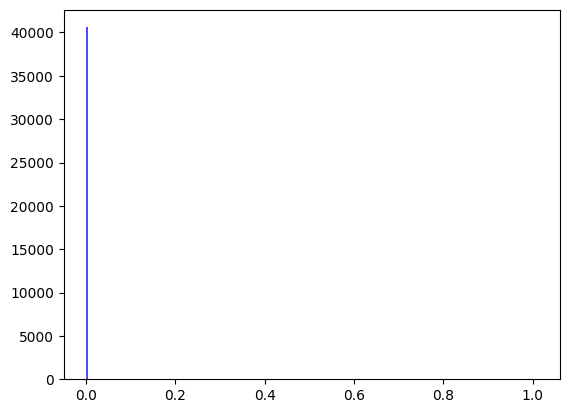

[2024-02-06T22:01:02.051947+00:00] Epochs 69, total loss: 7.32683e+04
[2024-02-06T22:01:02.053404+00:00] Training llk: -5.70253e-01
[2024-02-06T22:01:02.054206+00:00] Testing llk: 2.97320e-02
[2024-02-06T22:01:02.054915+00:00] MAE:3.14007, MRE:0.49326
saving model


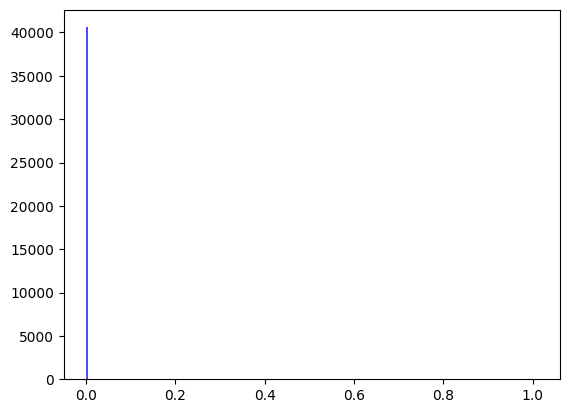

[2024-02-06T22:01:03.327194+00:00] Epochs 70, total loss: 7.89430e+04
[2024-02-06T22:01:03.327977+00:00] Training llk: -6.14419e-01
[2024-02-06T22:01:03.328091+00:00] Testing llk: -5.81967e-03
[2024-02-06T22:01:03.328173+00:00] MAE:3.19565, MRE:0.50352
saving model


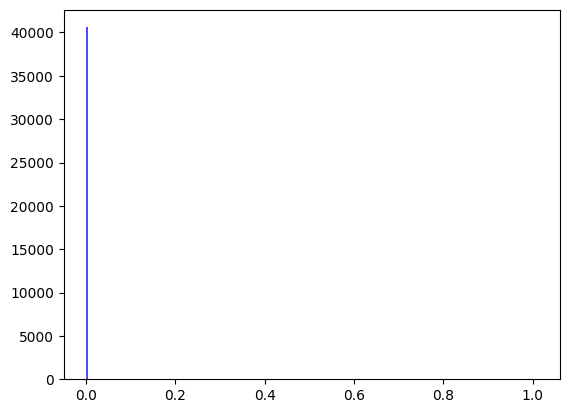

[2024-02-06T22:01:04.892827+00:00] Epochs 71, total loss: 7.88324e+04
[2024-02-06T22:01:04.894019+00:00] Training llk: -6.13558e-01
[2024-02-06T22:01:04.894648+00:00] Testing llk: 2.16160e-02
[2024-02-06T22:01:04.895262+00:00] MAE:3.15332, MRE:0.49570
saving model


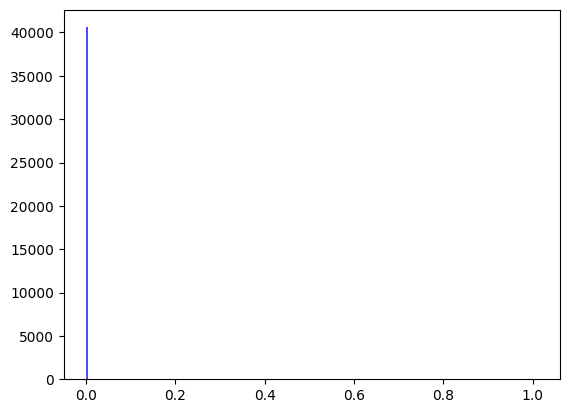

[2024-02-06T22:01:06.882599+00:00] Epochs 72, total loss: 8.01251e+04
[2024-02-06T22:01:06.882842+00:00] Training llk: -6.23619e-01
[2024-02-06T22:01:06.882930+00:00] Testing llk: 8.76114e-03
[2024-02-06T22:01:06.882998+00:00] MAE:3.17360, MRE:0.49945
saving model


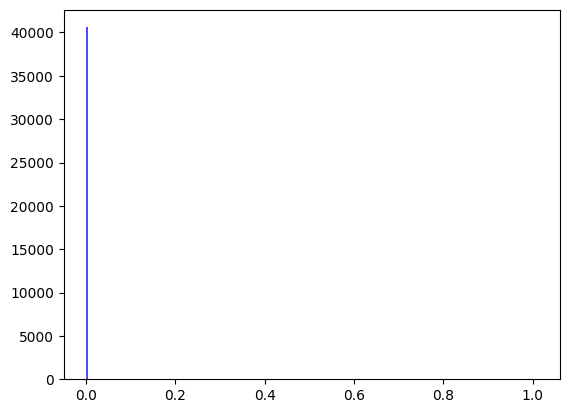

[2024-02-06T22:01:08.142696+00:00] Epochs 73, total loss: 7.70644e+04
[2024-02-06T22:01:08.142893+00:00] Training llk: -5.99797e-01
[2024-02-06T22:01:08.142977+00:00] Testing llk: 1.35037e-02
[2024-02-06T22:01:08.143046+00:00] MAE:3.16620, MRE:0.49807
saving model


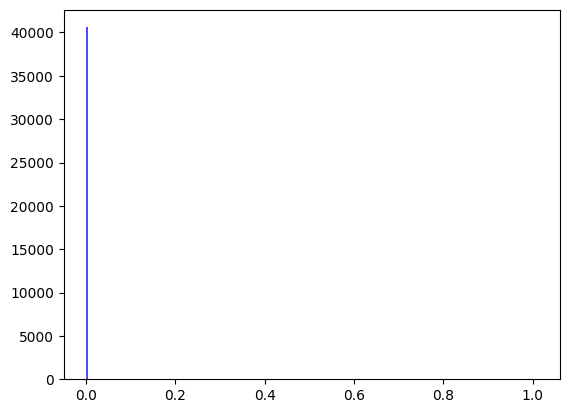

[2024-02-06T22:01:09.370311+00:00] Epochs 74, total loss: 8.02623e+04
[2024-02-06T22:01:09.371443+00:00] Training llk: -6.24687e-01
[2024-02-06T22:01:09.371567+00:00] Testing llk: 7.84728e-03
[2024-02-06T22:01:09.371678+00:00] MAE:3.17490, MRE:0.49957
saving model


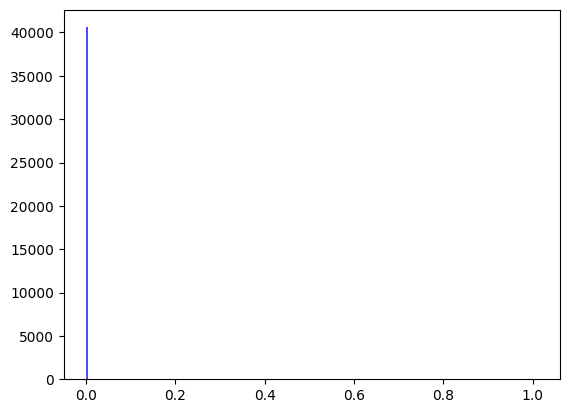

[2024-02-06T22:01:10.611895+00:00] Epochs 75, total loss: 8.07343e+04
[2024-02-06T22:01:10.612097+00:00] Training llk: -6.28361e-01
[2024-02-06T22:01:10.612185+00:00] Testing llk: 5.17267e-03
[2024-02-06T22:01:10.612254+00:00] MAE:3.17893, MRE:0.50023
saving model


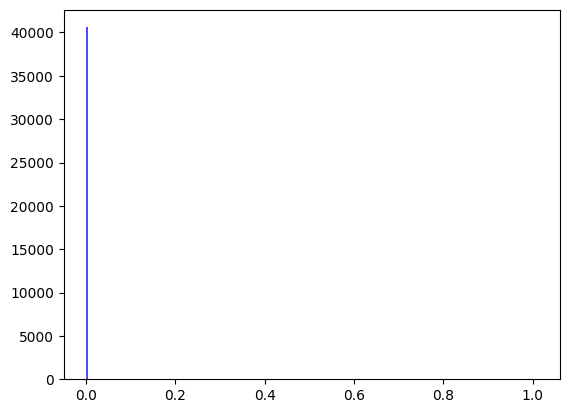

[2024-02-06T22:01:11.840211+00:00] Epochs 76, total loss: 7.72149e+04
[2024-02-06T22:01:11.840409+00:00] Training llk: -6.00969e-01
[2024-02-06T22:01:11.840494+00:00] Testing llk: 1.23602e-02
[2024-02-06T22:01:11.840562+00:00] MAE:3.16773, MRE:0.49806
saving model


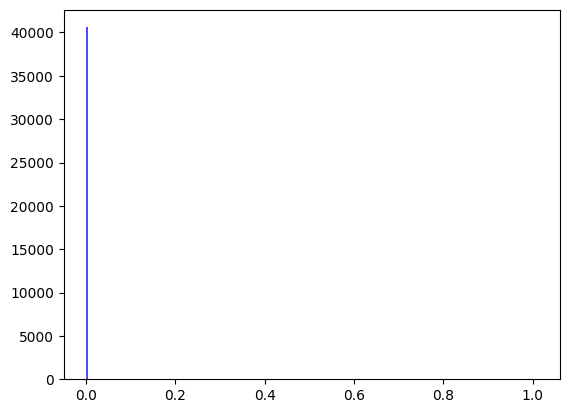

[2024-02-06T22:01:13.036879+00:00] Epochs 77, total loss: 7.65092e+04
[2024-02-06T22:01:13.037075+00:00] Training llk: -5.95477e-01
[2024-02-06T22:01:13.037155+00:00] Testing llk: 2.34731e-02
[2024-02-06T22:01:13.037223+00:00] MAE:3.15001, MRE:0.49475
saving model


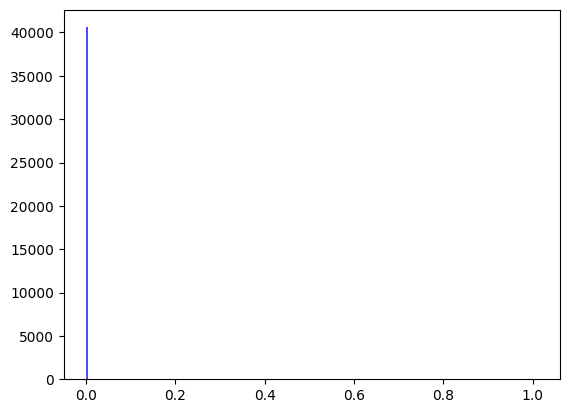

[2024-02-06T22:01:14.236690+00:00] Epochs 78, total loss: 8.02608e+04
[2024-02-06T22:01:14.237419+00:00] Training llk: -6.24675e-01
[2024-02-06T22:01:14.237837+00:00] Testing llk: 4.44184e-03
[2024-02-06T22:01:14.237939+00:00] MAE:3.17991, MRE:0.50025
saving model


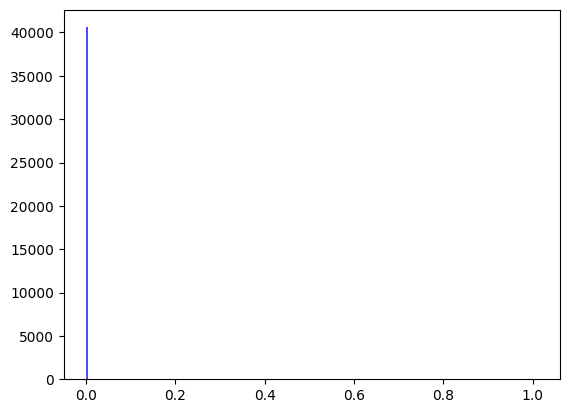

[2024-02-06T22:01:15.711610+00:00] Epochs 79, total loss: 7.50050e+04
[2024-02-06T22:01:15.712388+00:00] Training llk: -5.83770e-01
[2024-02-06T22:01:15.712735+00:00] Testing llk: 1.62146e-02
[2024-02-06T22:01:15.713056+00:00] MAE:3.16161, MRE:0.49686
saving model


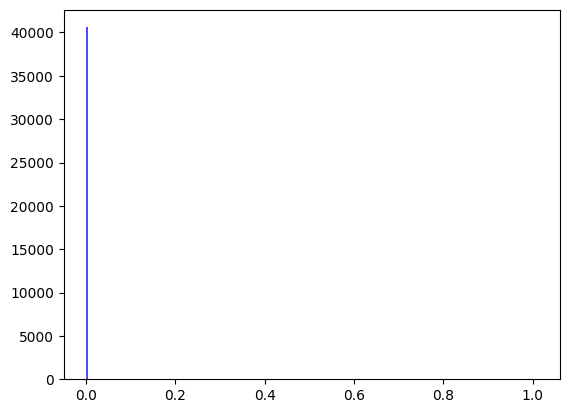

[2024-02-06T22:01:17.287534+00:00] Epochs 80, total loss: 7.37652e+04
[2024-02-06T22:01:17.288569+00:00] Training llk: -5.74120e-01
[2024-02-06T22:01:17.289130+00:00] Testing llk: 2.69152e-02
[2024-02-06T22:01:17.289595+00:00] MAE:3.14448, MRE:0.49382
saving model


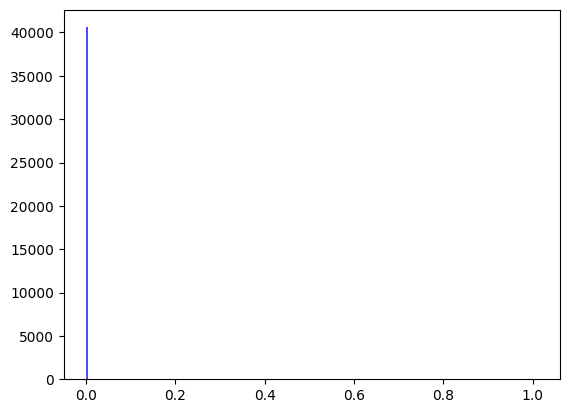

[2024-02-06T22:01:19.034493+00:00] Epochs 81, total loss: 7.69011e+04
[2024-02-06T22:01:19.035278+00:00] Training llk: -5.98527e-01
[2024-02-06T22:01:19.035607+00:00] Testing llk: 1.26143e-02
[2024-02-06T22:01:19.035931+00:00] MAE:3.16738, MRE:0.49804
saving model


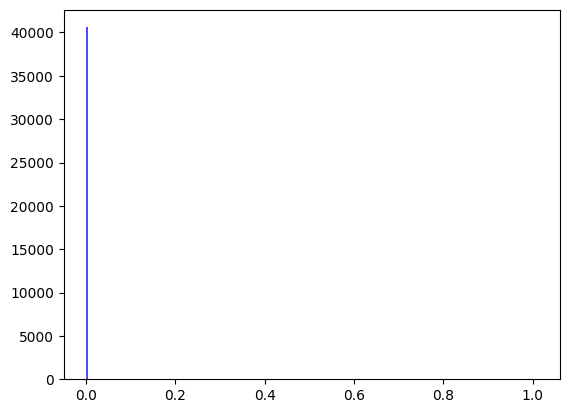

[2024-02-06T22:01:20.246705+00:00] Epochs 82, total loss: 8.07388e+04
[2024-02-06T22:01:20.246904+00:00] Training llk: -6.28396e-01
[2024-02-06T22:01:20.246981+00:00] Testing llk: 1.44156e-03
[2024-02-06T22:01:20.247051+00:00] MAE:3.18463, MRE:0.50130
saving model


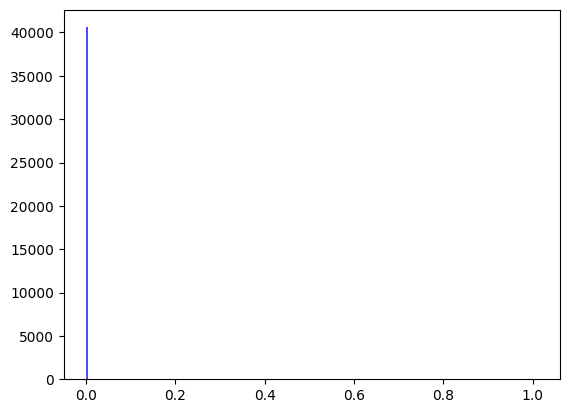

[2024-02-06T22:01:21.503516+00:00] Epochs 83, total loss: 7.92440e+04
[2024-02-06T22:01:21.503733+00:00] Training llk: -6.16761e-01
[2024-02-06T22:01:21.503821+00:00] Testing llk: 7.55628e-03
[2024-02-06T22:01:21.503893+00:00] MAE:3.17521, MRE:0.49947
saving model


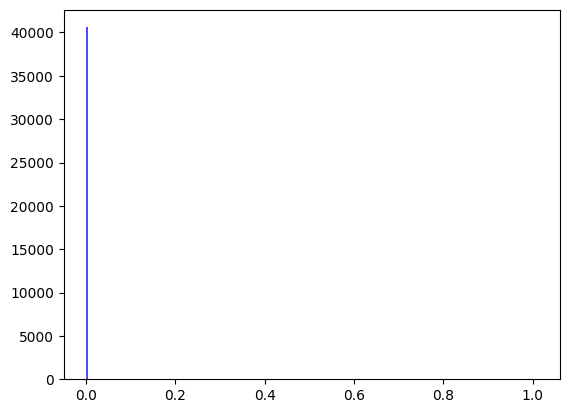

[2024-02-06T22:01:22.751010+00:00] Epochs 84, total loss: 7.95176e+04
[2024-02-06T22:01:22.751807+00:00] Training llk: -6.18891e-01
[2024-02-06T22:01:22.752135+00:00] Testing llk: 1.73887e-02
[2024-02-06T22:01:22.752440+00:00] MAE:3.15983, MRE:0.49662
saving model


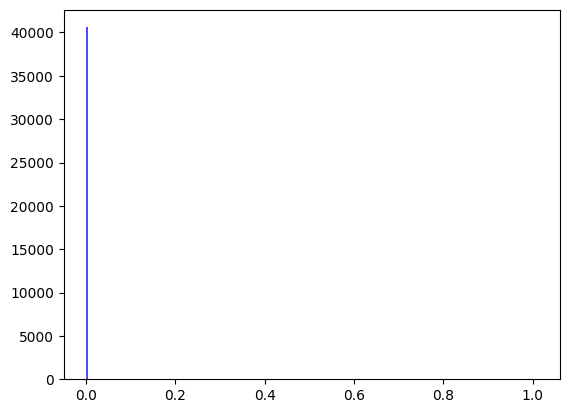

[2024-02-06T22:01:24.400007+00:00] Epochs 85, total loss: 8.28219e+04
[2024-02-06T22:01:24.400871+00:00] Training llk: -6.44609e-01
[2024-02-06T22:01:24.400994+00:00] Testing llk: -5.05800e-03
[2024-02-06T22:01:24.401081+00:00] MAE:3.19430, MRE:0.50301
saving model


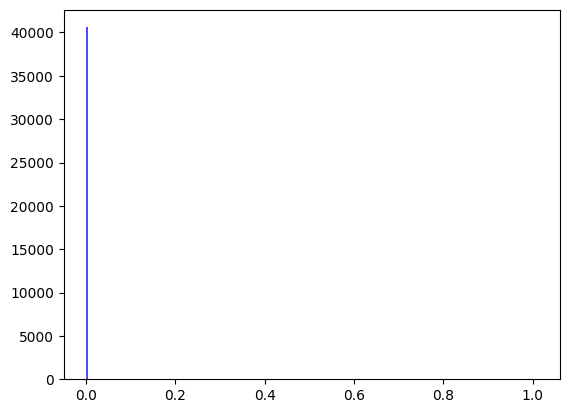

[2024-02-06T22:01:25.625384+00:00] Epochs 86, total loss: 7.47678e+04
[2024-02-06T22:01:25.625588+00:00] Training llk: -5.81923e-01
[2024-02-06T22:01:25.626984+00:00] Testing llk: 2.10217e-02
[2024-02-06T22:01:25.627121+00:00] MAE:3.15391, MRE:0.49541
saving model


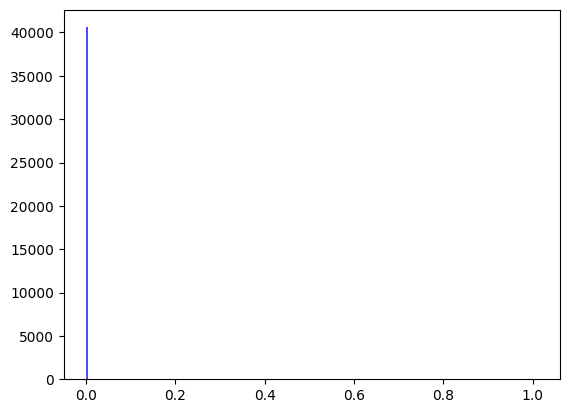

[2024-02-06T22:01:27.216058+00:00] Epochs 87, total loss: 7.26026e+04
[2024-02-06T22:01:27.216260+00:00] Training llk: -5.65071e-01
[2024-02-06T22:01:27.216344+00:00] Testing llk: 2.50832e-02
[2024-02-06T22:01:27.216411+00:00] MAE:3.14746, MRE:0.49435
saving model


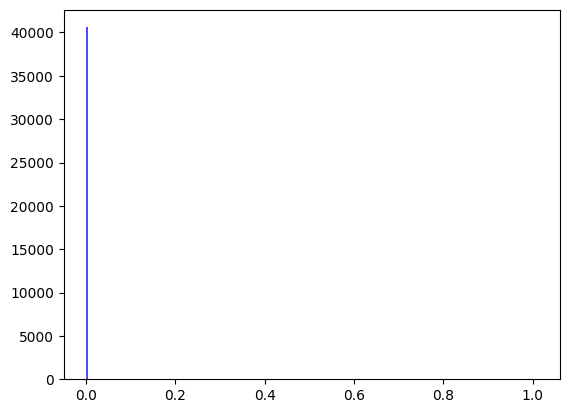

[2024-02-06T22:01:28.472963+00:00] Epochs 88, total loss: 7.75784e+04
[2024-02-06T22:01:28.473159+00:00] Training llk: -6.03798e-01
[2024-02-06T22:01:28.473242+00:00] Testing llk: 1.21063e-02
[2024-02-06T22:01:28.473311+00:00] MAE:3.16818, MRE:0.49820
saving model


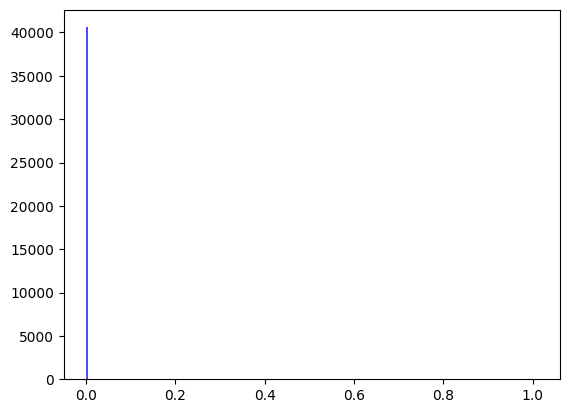

[2024-02-06T22:01:30.157588+00:00] Epochs 89, total loss: 7.59513e+04
[2024-02-06T22:01:30.158770+00:00] Training llk: -5.91134e-01
[2024-02-06T22:01:30.159344+00:00] Testing llk: 1.77785e-02
[2024-02-06T22:01:30.159935+00:00] MAE:3.15928, MRE:0.49659
saving model


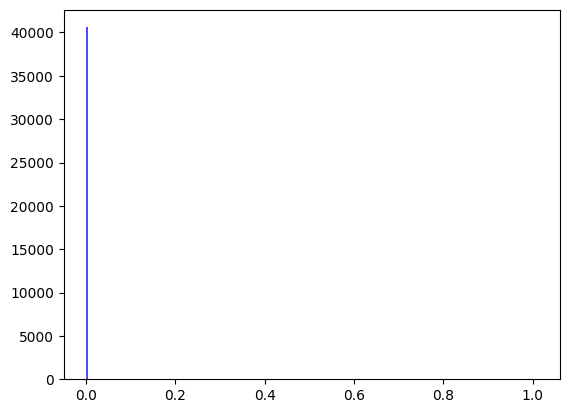

[2024-02-06T22:01:31.693686+00:00] Epochs 90, total loss: 7.10346e+04
[2024-02-06T22:01:31.693879+00:00] Training llk: -5.52868e-01
[2024-02-06T22:01:31.693963+00:00] Testing llk: 4.05870e-02
[2024-02-06T22:01:31.694030+00:00] MAE:3.12192, MRE:0.49004
saving model


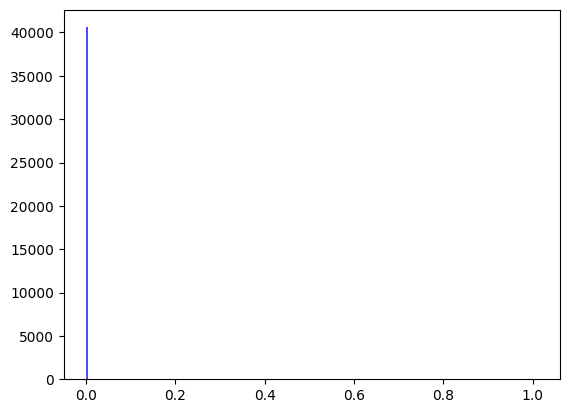

[2024-02-06T22:01:32.891863+00:00] Epochs 91, total loss: 7.69400e+04
[2024-02-06T22:01:32.892065+00:00] Training llk: -5.98829e-01
[2024-02-06T22:01:32.892148+00:00] Testing llk: 6.43380e-03
[2024-02-06T22:01:32.892218+00:00] MAE:3.17705, MRE:0.49993
saving model


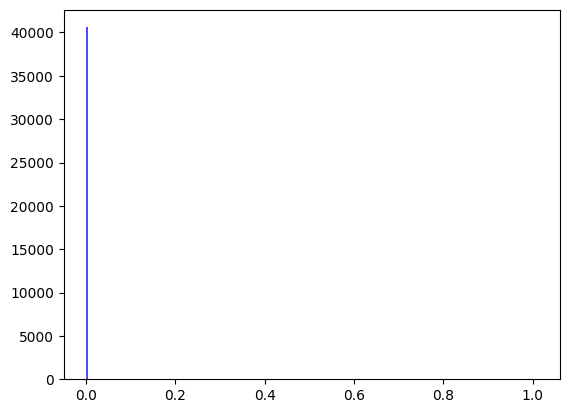

[2024-02-06T22:01:34.097883+00:00] Epochs 92, total loss: 7.79762e+04
[2024-02-06T22:01:34.098085+00:00] Training llk: -6.06894e-01
[2024-02-06T22:01:34.098170+00:00] Testing llk: 7.58947e-03
[2024-02-06T22:01:34.098241+00:00] MAE:3.17527, MRE:0.49961
saving model


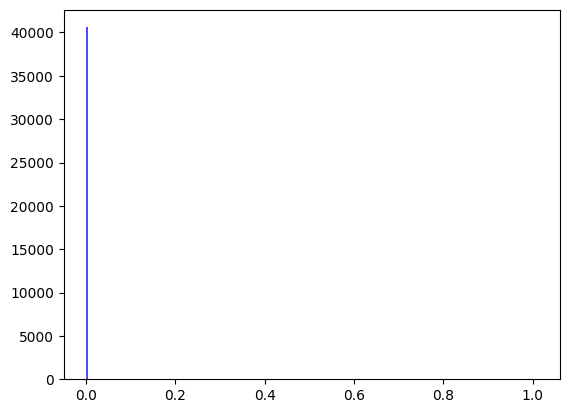

[2024-02-06T22:01:35.542697+00:00] Epochs 93, total loss: 7.94996e+04
[2024-02-06T22:01:35.542896+00:00] Training llk: -6.18751e-01
[2024-02-06T22:01:35.542979+00:00] Testing llk: 2.42756e-02
[2024-02-06T22:01:35.543051+00:00] MAE:3.14897, MRE:0.49484
saving model


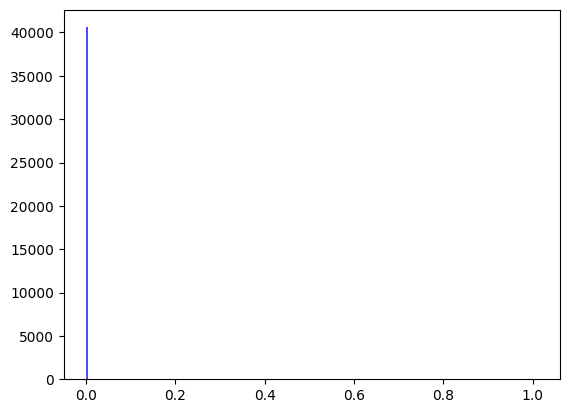

[2024-02-06T22:01:36.775712+00:00] Epochs 94, total loss: 7.55682e+04
[2024-02-06T22:01:36.775907+00:00] Training llk: -5.88153e-01
[2024-02-06T22:01:36.775986+00:00] Testing llk: 1.23037e-02
[2024-02-06T22:01:36.776053+00:00] MAE:3.16802, MRE:0.49833
saving model


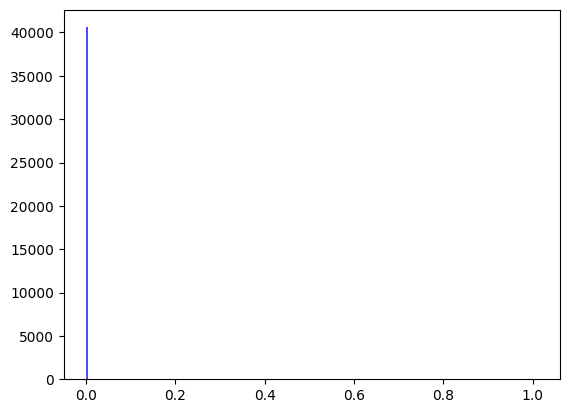

[2024-02-06T22:01:37.996835+00:00] Epochs 95, total loss: 7.32148e+04
[2024-02-06T22:01:37.997626+00:00] Training llk: -5.69836e-01
[2024-02-06T22:01:37.998009+00:00] Testing llk: 3.21349e-02
[2024-02-06T22:01:37.998310+00:00] MAE:3.13614, MRE:0.49260
saving model


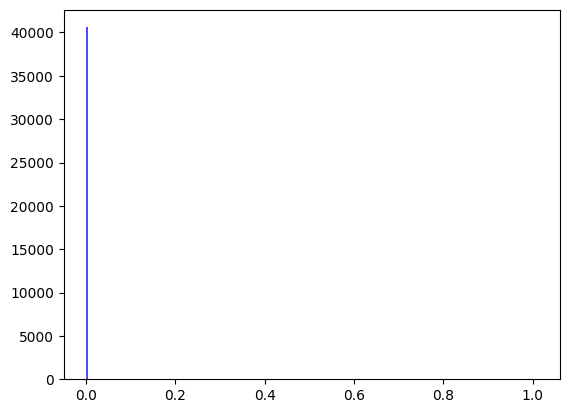

[2024-02-06T22:01:39.201156+00:00] Epochs 96, total loss: 7.84831e+04
[2024-02-06T22:01:39.202000+00:00] Training llk: -6.10839e-01
[2024-02-06T22:01:39.202336+00:00] Testing llk: 9.79845e-03
[2024-02-06T22:01:39.202621+00:00] MAE:3.17201, MRE:0.49918
saving model


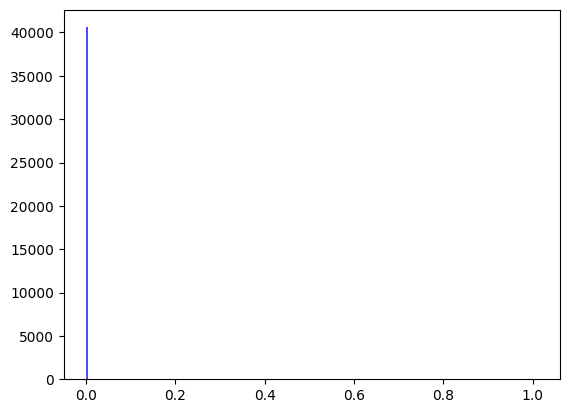

[2024-02-06T22:01:40.387313+00:00] Epochs 97, total loss: 7.64620e+04
[2024-02-06T22:01:40.387513+00:00] Training llk: -5.95109e-01
[2024-02-06T22:01:40.387601+00:00] Testing llk: 1.43144e-02
[2024-02-06T22:01:40.387687+00:00] MAE:3.16500, MRE:0.49792
saving model


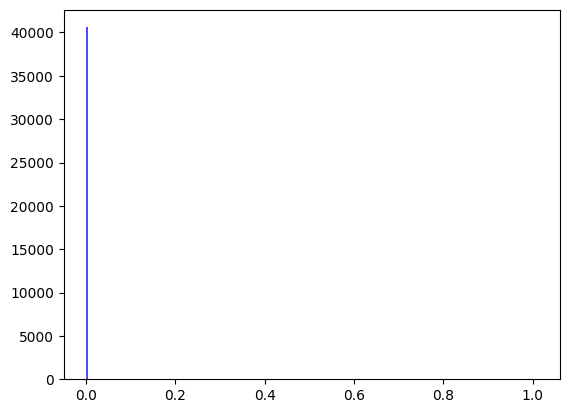

[2024-02-06T22:01:41.852098+00:00] Epochs 98, total loss: 7.21498e+04
[2024-02-06T22:01:41.853293+00:00] Training llk: -5.61547e-01
[2024-02-06T22:01:41.856985+00:00] Testing llk: 3.90801e-02
[2024-02-06T22:01:41.857576+00:00] MAE:3.12474, MRE:0.49083
saving model


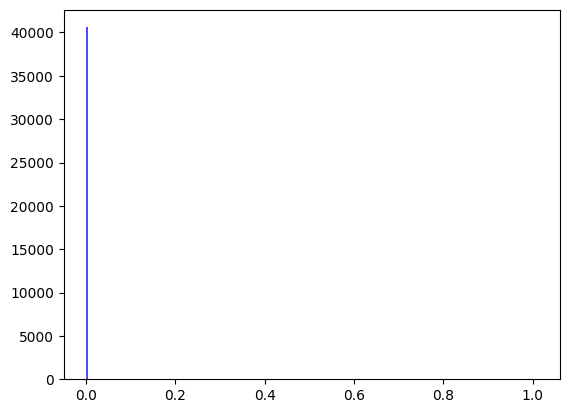

[2024-02-06T22:01:43.656806+00:00] Epochs 99, total loss: 7.86635e+04
[2024-02-06T22:01:43.657140+00:00] Training llk: -6.12244e-01
[2024-02-06T22:01:43.657248+00:00] Testing llk: 5.92890e-03
[2024-02-06T22:01:43.657321+00:00] MAE:3.17815, MRE:0.50050
saving model
training done!


In [ ]:
for Tm in [100.]:
  print(Tm)
  T = [buffer_end_time, Tm]
  tau_max = 10.
  baserate = true_mu
  nsample = 10
  n_class = 1
  int_res = 200
  hid_dim = 1
  batch_size = 100
  train_size = 1000
  lr = 0.05
  epoch = 100
  config = config_generate(T0=str(T[0]),
                          T1=str(T[1]),
                          tau_max=str(tau_max),
                          nsample=str(nsample),
                          int_res=str(int_res),
                          n_class=str(n_class),
                          lr=str(lr),
                          epoch=str(epoch),
                          hid_dim=str(hid_dim),
                          batch_size=str(batch_size))
  config.own_event_embed = False
  config.bptt = 10
  config.alpha = true_alpha

  train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
  train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
  for i in range(train_data.shape[0]):
      seq = raw_train_data[i]
      train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

  train_data_ = generate_event_mark(train_data)

  # seeds = [300, 816, 2999]
  # seeds = [1000, 2000, 3000]
  seeds = [0]

  for seed in seeds:
      # torch.random.manual_seed(seed)
      random.seed(seed)

      train_idx = np.arange(train_data_.shape[0])
      # random.shuffle(train_idx)
      train_data2 = train_data_[train_idx[:train_size]]
      buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

      rmtpp_model = RMTPP_new(config, device)
      num_paras = count_parameters(rmtpp_model)
      print("#parameters: %d" % num_paras)

      for name, parameter in rmtpp_model.named_parameters():
          if name == "baserate_mu":
              # parameter.data.fill_(random.uniform(0.4, 0.5))
              parameter.data.fill_(baserate)
          else:
              parameter.data.fill_(random.gauss(0, 0.01))

      ts = np.linspace(test_time[0], test_time[1], ngrid)
      true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)


      rmtpp_model, train_llks, test_llks, test_maes, test_mres, wall_time = model_train(train_data2,
                                                                                      test_data_,
                                                                                      buffer_train_data2,
                                                                                      buffer_test_data_,
                                                                                      rmtpp_model,
                                                                                      config,
                                                                                      device,
                                                                                      True, ts, true_lams)


100


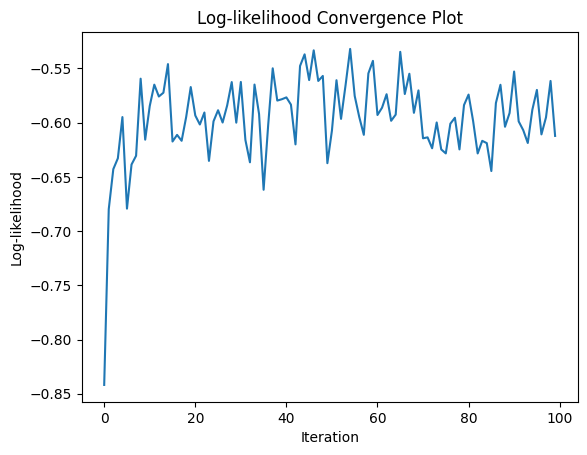

In [ ]:



### This block plots the evolution of log-likelihood during training iterations.
### They will be split off into a separate file for plotting
import scipy.stats as st

# we need to following two variables
print(len(train_llks))
#print(train_lld_batches.shape)
#print(train_llks)

# n_batches, n_iter = train_lld_batches.shape
# lb = np.zeros((n_iter,))
# ub = np.zeros((n_iter,))

# plotting codes
plt.figure()
plt.plot(train_llks)
# for i in range(n_batches):
#   temp = -train_lld_batches[i,:]
#   plt.plot(temp, color = 'black', alpha = 0.05)
# for j in range(n_iter):
#   temp = -train_lld_batches[:,j]

#   lb[j] = min(temp)
#   ub[j] = max(temp)
#   # lb[j] = np.percentile(temp, 2.5)
#   # ub[j] = np.percentile(temp, 97.5)

# plt.fill_between( range(epoch), lb,ub, color='b', alpha=.1)
plt.title('Log-likelihood Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()

# save the training lld for each batch

(50, 686, 2)
(50, 127, 2)


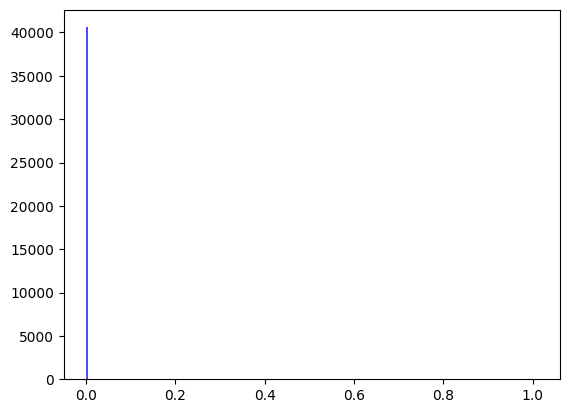

Text(0.5, 1.0, 'Conditional Intensity')

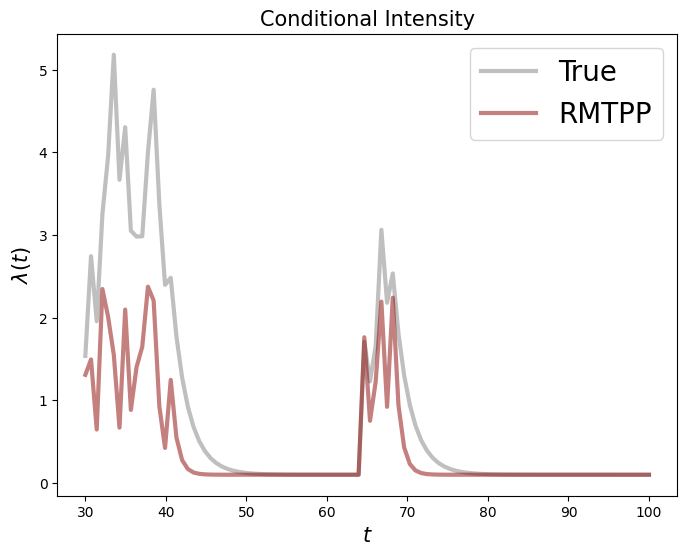

In [ ]:
test_data_1 = np.zeros((raw_test_data_1.shape[0], test_lens.max()))

btest_lens = ((raw_test_data_1 <= buffer_test_time[1]) * (raw_test_data_1 > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data_1 <= test_time[1]) * (raw_test_data_1 > test_time[0])).sum(1)

buffer_test_data1 = np.zeros((raw_test_data_1.shape[0], btest_lens.max()))

for i in range(raw_test_data_1.shape[0]):
    seq = raw_test_data_1[i]
    test_data_1[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data1[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_test_data_1 = np.concatenate((np.ones_like(buffer_test_data1[:, :1]) * buffer_test_time[0], buffer_test_data1), axis=-1)

test_data_1_ = generate_event_mark(test_data_1)
buffer_test_data_1_ = generate_event_mark(buffer_test_data_1)

test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)
true_beta = 0.5

rmtpp_lams = rmtpp_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 10
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, rmtpp_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="RMTPP")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

In [ ]:
mae_tol = 0
mae_tol_cnt = 0
mae = []

print(rmtpp_lams.shape)
print(true_lams.shape)

for plot_idx in range(rmtpp_lams.shape[0]):
  mae.append(np.mean(np.abs(rmtpp_lams[plot_idx] - true_lams[plot_idx])))

print("MAE (first cluster): ", np.mean(np.array(mae)))

np.save('lam_1_pred.npy', rmtpp_lams)
np.save('lam_1_true.npy', true_lams)

mae_tol_cnt += rmtpp_lams.shape[0]
mae_tol += np.mean(np.array(mae)) * rmtpp_lams.shape[0]

(50, 100)
(50, 100)
MAE (first cluster):  3.17814643379901


(100, 686, 2)
(100, 166, 2)


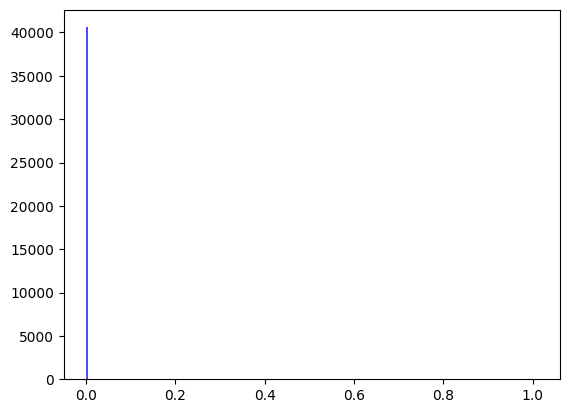

Text(0.5, 1.0, 'Conditional Intensity')

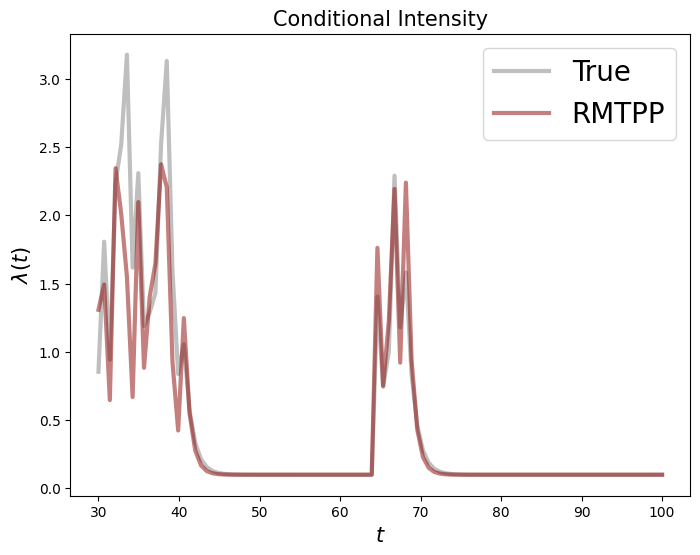

In [ ]:
test_data_2 = np.zeros((raw_test_data_2.shape[0], test_lens.max()))

btest_lens = ((raw_test_data_2 <= buffer_test_time[1]) * (raw_test_data_2 > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data_2 <= test_time[1]) * (raw_test_data_2 > test_time[0])).sum(1)

buffer_test_data2 = np.zeros((raw_test_data_2.shape[0], btest_lens.max()))

for i in range(raw_test_data_2.shape[0]):
    seq = raw_test_data_2[i]
    test_data_2[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data2[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_test_data_2 = np.concatenate((np.ones_like(buffer_test_data2[:, :1]) * buffer_test_time[0], buffer_test_data2), axis=-1)

test_data_2_ = generate_event_mark(test_data_2)
buffer_test_data_2_ = generate_event_mark(buffer_test_data_2)

test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)
true_beta = 1.0

rmtpp_lams = rmtpp_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 10
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, rmtpp_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="RMTPP")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

In [ ]:
mae = []

print(rmtpp_lams.shape)
print(true_lams.shape)

for plot_idx in range(rmtpp_lams.shape[0]):
  mae.append(np.mean(np.abs(rmtpp_lams[plot_idx] - true_lams[plot_idx])))

print("MAE (second cluster): ", np.mean(np.array(mae)))

np.save('lam_2_pred.npy', rmtpp_lams)
np.save('lam_2_true.npy', true_lams)

mae_tol_cnt += rmtpp_lams.shape[0]
mae_tol += np.mean(np.array(mae)) * rmtpp_lams.shape[0]


(50, 100)
(50, 100)
MAE (second cluster):  1.2863749258245598


(150, 474, 2)
(150, 152, 2)


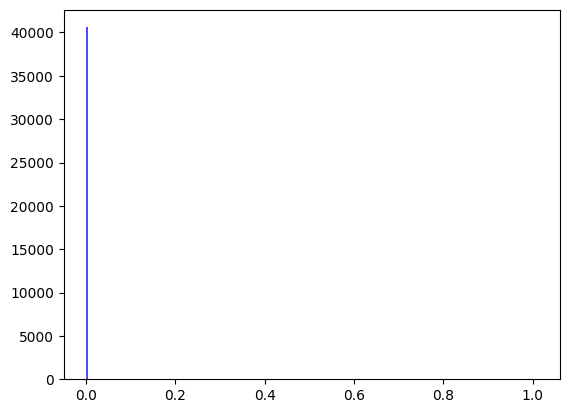

Text(0.5, 1.0, 'Conditional Intensity')

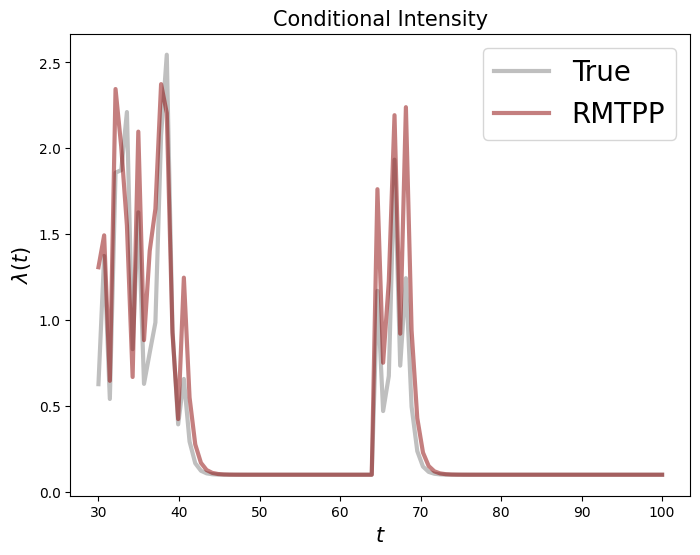

In [ ]:
test_data_3 = np.zeros((raw_test_data_3.shape[0], test_lens.max()))

btest_lens = ((raw_test_data_3 <= buffer_test_time[1]) * (raw_test_data_3 > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data_3 <= test_time[1]) * (raw_test_data_3 > test_time[0])).sum(1)

buffer_test_data3 = np.zeros((raw_test_data_3.shape[0], btest_lens.max()))

for i in range(raw_test_data_3.shape[0]):
    seq = raw_test_data_3[i]
    test_data_3[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data3[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_test_data_3 = np.concatenate((np.ones_like(buffer_test_data3[:, :1]) * buffer_test_time[0], buffer_test_data3), axis=-1)

test_data_3_ = generate_event_mark(test_data_3)
buffer_test_data_3_ = generate_event_mark(buffer_test_data_3)

test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)
true_beta = 1.5

rmtpp_lams = rmtpp_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 10
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, rmtpp_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="RMTPP")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

In [ ]:
mae = []

for plot_idx in range(rmtpp_lams.shape[0]):
  mae.append(np.mean(np.abs(rmtpp_lams[plot_idx] - true_lams[plot_idx])))

print("MAE (third cluster): ", np.mean(np.array(mae)))

np.save('lam_3_pred.npy', rmtpp_lams)
np.save('lam_3_true.npy', true_lams)

mae_tol_cnt += rmtpp_lams.shape[0]
mae_tol += np.mean(np.array(mae)) * rmtpp_lams.shape[0]


MAE (third cluster):  0.7642631831218623


In [ ]:
MAE_res = mae_tol / mae_tol_cnt
print(MAE_res)

1.742928180915144


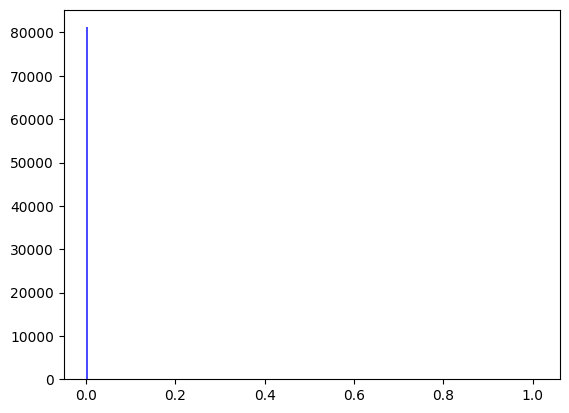

Text(0.5, 1.0, 'Conditional Intensity')

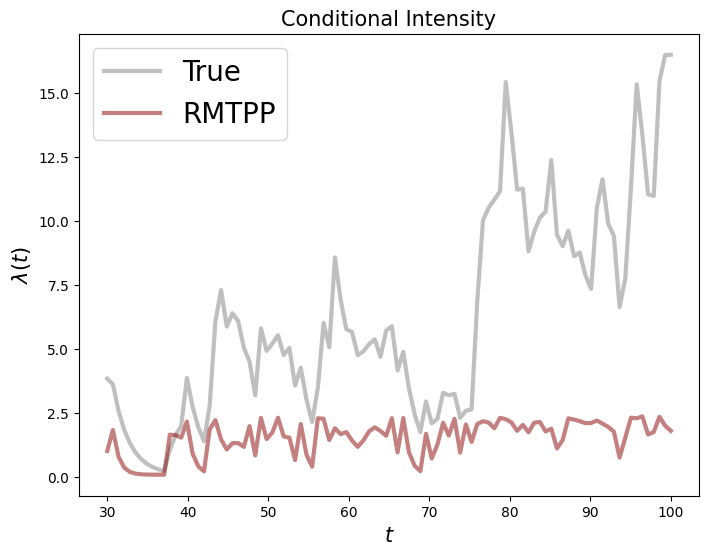

In [ ]:
ts = np.linspace(test_time[0], test_time[1], ngrid)

rmtpp_lams = rmtpp_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 0
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, rmtpp_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="RMTPP")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

In [ ]:
# Second data set

true_mu = 0.1
true_alpha = 1.0
true_beta = 2.0
raw_train_data = np.load('sample_data/training_2_0911.npy', allow_pickle = True)
raw_test_data = np.load('sample_data/testing_2_0911.npy', allow_pickle = True)

buffer_start_time = 15
buffer_end_time = 30
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)

print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 100

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())


(50, 78, 2)
(200, 41, 2)
(50, 38, 2)
(50, 78, 2) (200, 41, 2) (50, 38, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2


100.0
(200, 109, 2)
#parameters: 4485
[2023-10-01T20:05:15.322727+00:00] #Training sequences: 200
[2023-10-01T20:05:15.322991+00:00] #Testing sequences: 50
[2023-10-01T20:05:15.323088+00:00] #Training events: 5327
[2023-10-01T20:05:15.323160+00:00] #Testing events: 1210


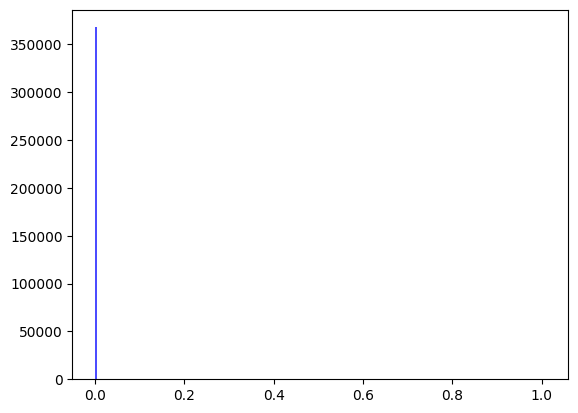

[2023-10-01T20:05:16.414297+00:00] Epochs 0, total loss: 1.65246e+04
[2023-10-01T20:05:16.415217+00:00] Training llk: -1.06164e+00
[2023-10-01T20:05:16.415332+00:00] Testing llk: -1.37002e+00
[2023-10-01T20:05:16.415420+00:00] MAE:0.10736, MRE:0.14360
saving model


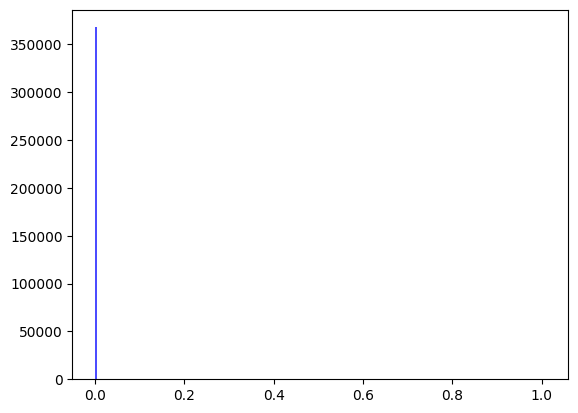

[2023-10-01T20:05:17.410264+00:00] Epochs 1, total loss: 1.42209e+04
[2023-10-01T20:05:17.411270+00:00] Training llk: -8.02827e-01
[2023-10-01T20:05:17.411388+00:00] Testing llk: -1.05224e+00
[2023-10-01T20:05:17.411466+00:00] MAE:0.10790, MRE:0.27812
saving model


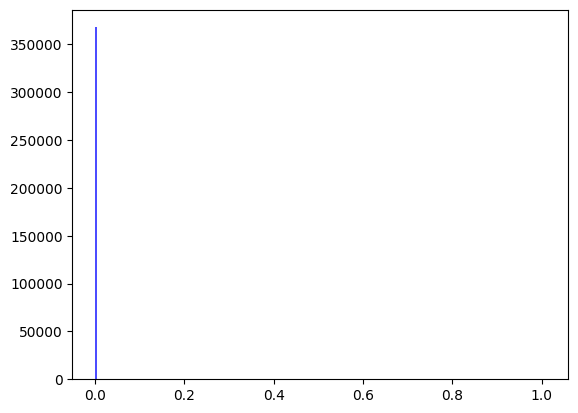

[2023-10-01T20:05:18.354303+00:00] Epochs 2, total loss: 1.27461e+04
[2023-10-01T20:05:18.354531+00:00] Training llk: -7.83332e-01
[2023-10-01T20:05:18.354626+00:00] Testing llk: -1.03147e+00
[2023-10-01T20:05:18.354708+00:00] MAE:0.14412, MRE:0.35903
saving model


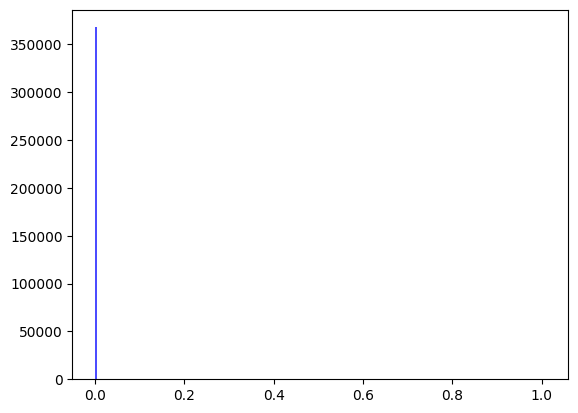

[2023-10-01T20:05:19.299039+00:00] Epochs 3, total loss: 1.45513e+04
[2023-10-01T20:05:19.299276+00:00] Training llk: -8.00145e-01
[2023-10-01T20:05:19.299396+00:00] Testing llk: -1.04830e+00
[2023-10-01T20:05:19.299473+00:00] MAE:0.09207, MRE:0.19825
saving model


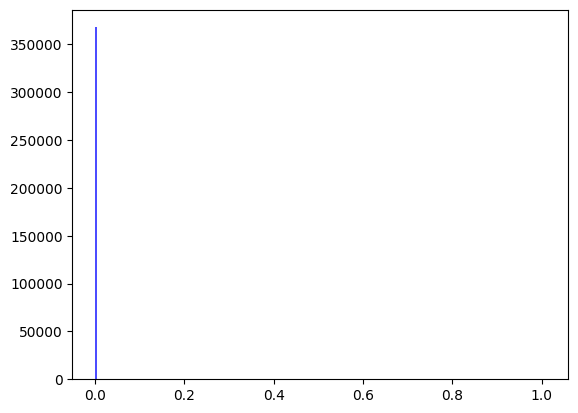

[2023-10-01T20:05:20.246162+00:00] Epochs 4, total loss: 1.14995e+04
[2023-10-01T20:05:20.246481+00:00] Training llk: -7.75531e-01
[2023-10-01T20:05:20.246588+00:00] Testing llk: -1.01999e+00
[2023-10-01T20:05:20.246662+00:00] MAE:0.11392, MRE:0.25803
saving model


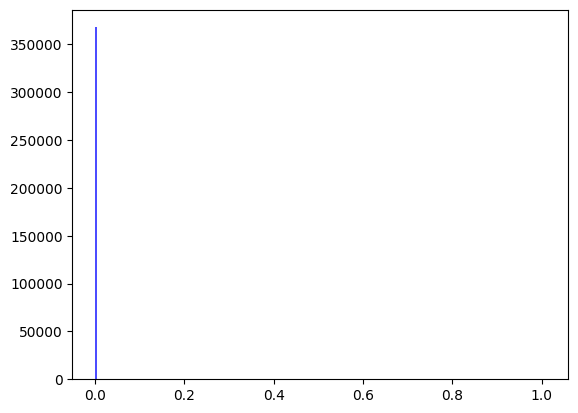

[2023-10-01T20:05:21.461414+00:00] Epochs 5, total loss: 1.20535e+04
[2023-10-01T20:05:21.461629+00:00] Training llk: -7.72734e-01
[2023-10-01T20:05:21.461712+00:00] Testing llk: -1.01666e+00
[2023-10-01T20:05:21.461778+00:00] MAE:0.11296, MRE:0.24851
saving model


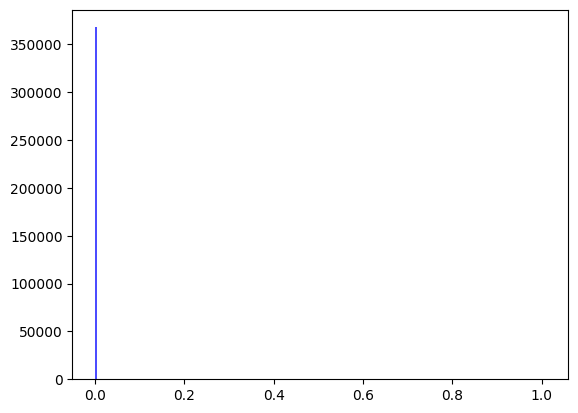

[2023-10-01T20:05:22.408076+00:00] Epochs 6, total loss: 1.35648e+04
[2023-10-01T20:05:22.408861+00:00] Training llk: -7.78790e-01
[2023-10-01T20:05:22.409157+00:00] Testing llk: -1.02304e+00
[2023-10-01T20:05:22.409261+00:00] MAE:0.09740, MRE:0.20039
saving model


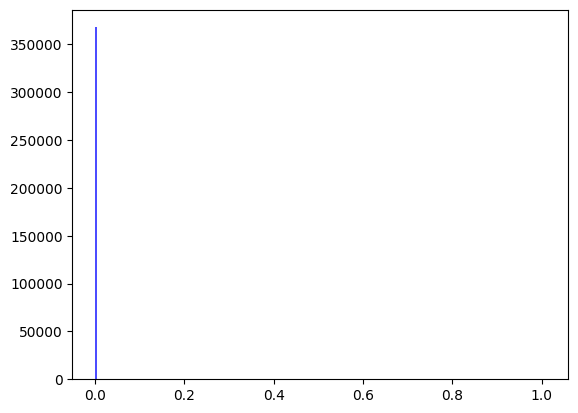

[2023-10-01T20:05:23.382533+00:00] Epochs 7, total loss: 1.30013e+04
[2023-10-01T20:05:23.383352+00:00] Training llk: -7.69544e-01
[2023-10-01T20:05:23.383660+00:00] Testing llk: -1.01260e+00
[2023-10-01T20:05:23.383956+00:00] MAE:0.10639, MRE:0.21902
saving model


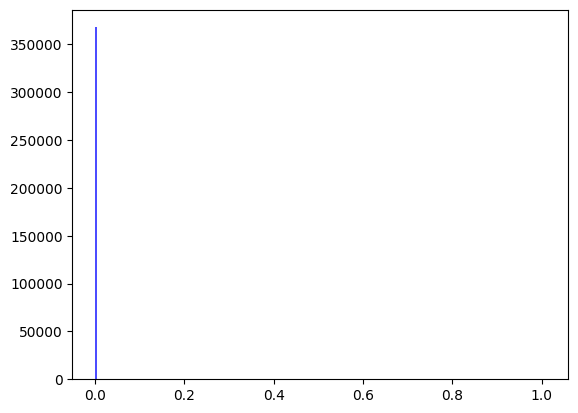

[2023-10-01T20:05:24.337911+00:00] Epochs 8, total loss: 1.18354e+04
[2023-10-01T20:05:24.338157+00:00] Training llk: -7.66550e-01
[2023-10-01T20:05:24.338276+00:00] Testing llk: -1.00922e+00
[2023-10-01T20:05:24.338353+00:00] MAE:0.10755, MRE:0.21611
saving model


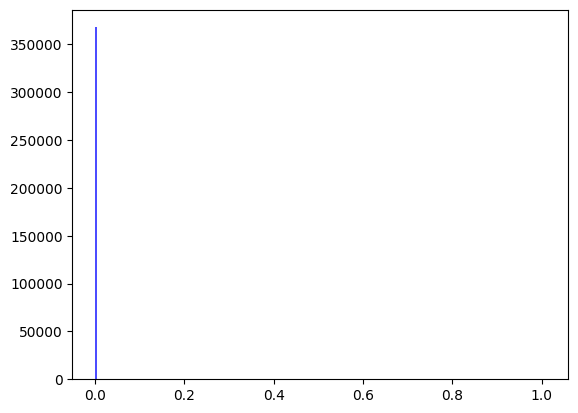

[2023-10-01T20:05:25.619387+00:00] Epochs 9, total loss: 1.25361e+04
[2023-10-01T20:05:25.620586+00:00] Training llk: -7.68491e-01
[2023-10-01T20:05:25.621162+00:00] Testing llk: -1.01111e+00
[2023-10-01T20:05:25.621671+00:00] MAE:0.09919, MRE:0.19049
saving model


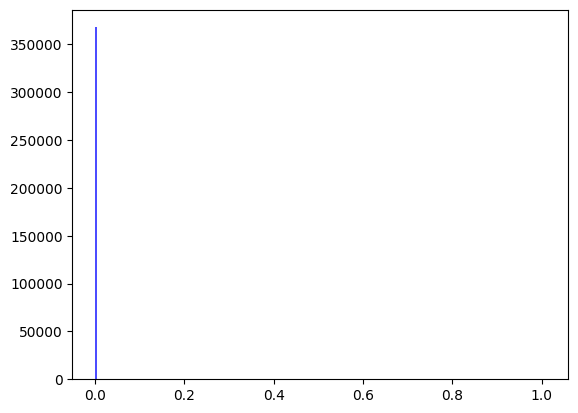

[2023-10-01T20:05:27.198690+00:00] Epochs 10, total loss: 1.12835e+04
[2023-10-01T20:05:27.198964+00:00] Training llk: -7.61885e-01
[2023-10-01T20:05:27.199099+00:00] Testing llk: -1.00407e+00
[2023-10-01T20:05:27.199178+00:00] MAE:0.11016, MRE:0.21138
saving model


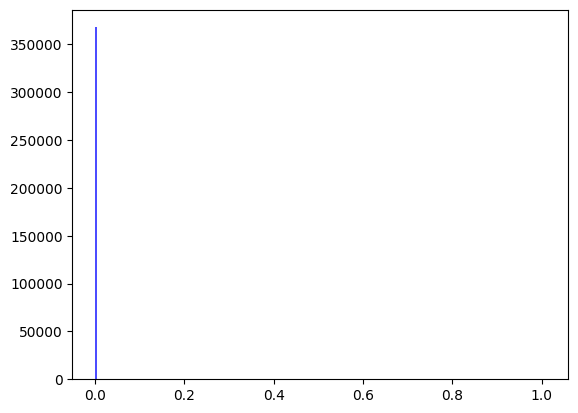

[2023-10-01T20:05:28.706321+00:00] Epochs 11, total loss: 1.25561e+04
[2023-10-01T20:05:28.707047+00:00] Training llk: -7.63615e-01
[2023-10-01T20:05:28.707171+00:00] Testing llk: -1.00561e+00
[2023-10-01T20:05:28.707255+00:00] MAE:0.10055, MRE:0.18509
saving model


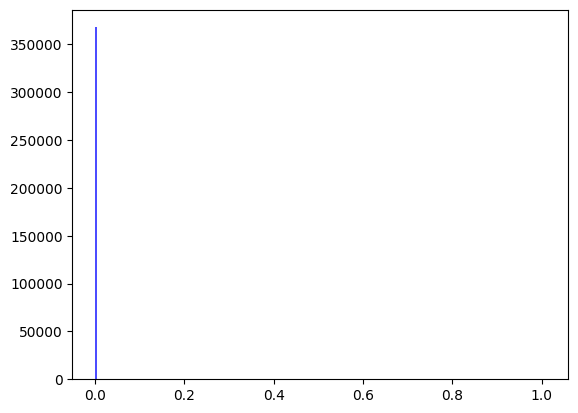

[2023-10-01T20:05:29.732001+00:00] Epochs 12, total loss: 1.21311e+04
[2023-10-01T20:05:29.732264+00:00] Training llk: -7.61244e-01
[2023-10-01T20:05:29.732367+00:00] Testing llk: -1.00301e+00
[2023-10-01T20:05:29.732452+00:00] MAE:0.10206, MRE:0.18423
saving model


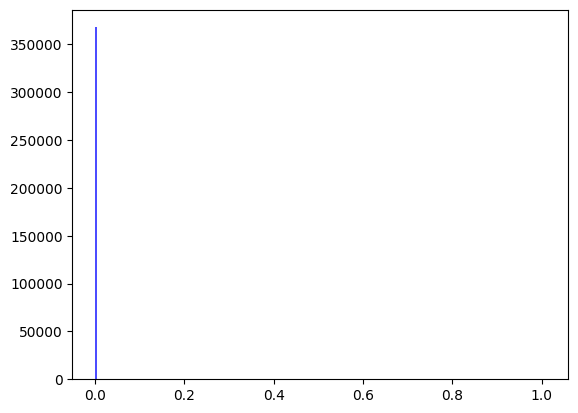

[2023-10-01T20:05:30.882390+00:00] Epochs 13, total loss: 1.11371e+04
[2023-10-01T20:05:30.882632+00:00] Training llk: -7.58543e-01
[2023-10-01T20:05:30.882744+00:00] Testing llk: -1.00019e+00
[2023-10-01T20:05:30.882824+00:00] MAE:0.10610, MRE:0.18879
saving model


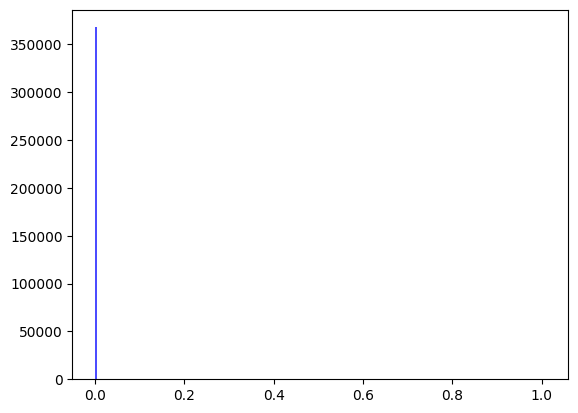

[2023-10-01T20:05:31.957262+00:00] Epochs 14, total loss: 1.16448e+04
[2023-10-01T20:05:31.957571+00:00] Training llk: -7.59791e-01
[2023-10-01T20:05:31.957670+00:00] Testing llk: -1.00135e+00
[2023-10-01T20:05:31.957754+00:00] MAE:0.09951, MRE:0.17144
saving model


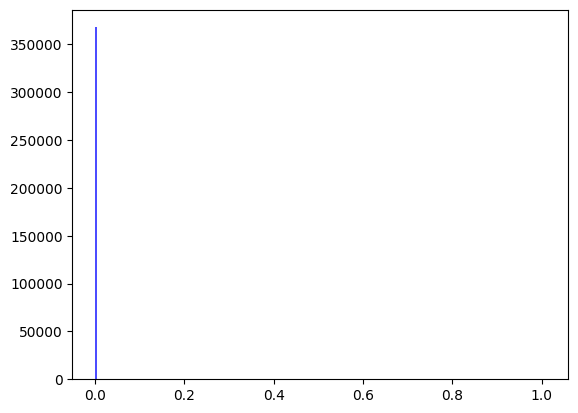

[2023-10-01T20:05:33.011895+00:00] Epochs 15, total loss: 1.31293e+04
[2023-10-01T20:05:33.012135+00:00] Training llk: -7.59202e-01
[2023-10-01T20:05:33.012243+00:00] Testing llk: -1.00069e+00
[2023-10-01T20:05:33.012324+00:00] MAE:0.09841, MRE:0.16582
saving model


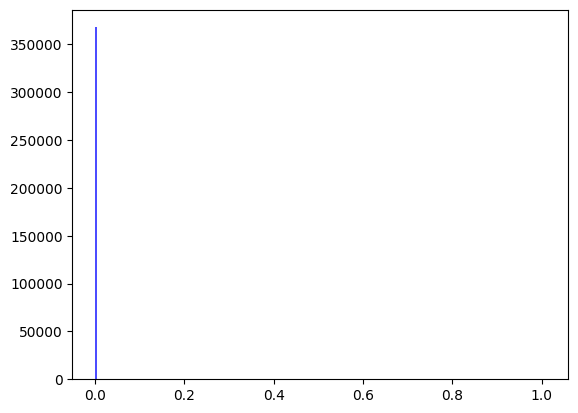

[2023-10-01T20:05:34.221814+00:00] Epochs 16, total loss: 1.29289e+04
[2023-10-01T20:05:34.222033+00:00] Training llk: -7.58412e-01
[2023-10-01T20:05:34.222122+00:00] Testing llk: -9.99839e-01
[2023-10-01T20:05:34.222199+00:00] MAE:0.09792, MRE:0.16163
saving model


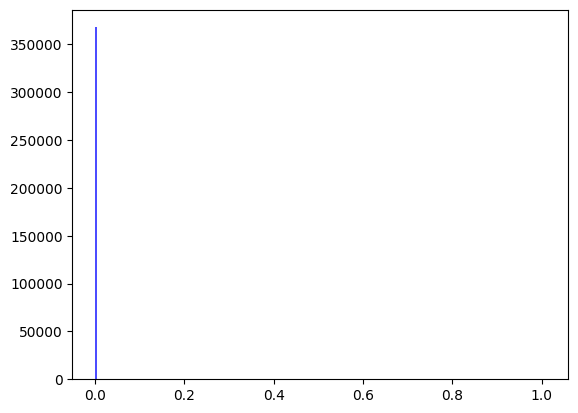

[2023-10-01T20:05:35.182426+00:00] Epochs 17, total loss: 1.16809e+04
[2023-10-01T20:05:35.183293+00:00] Training llk: -7.57033e-01
[2023-10-01T20:05:35.183607+00:00] Testing llk: -9.98392e-01
[2023-10-01T20:05:35.183890+00:00] MAE:0.09929, MRE:0.16178
saving model


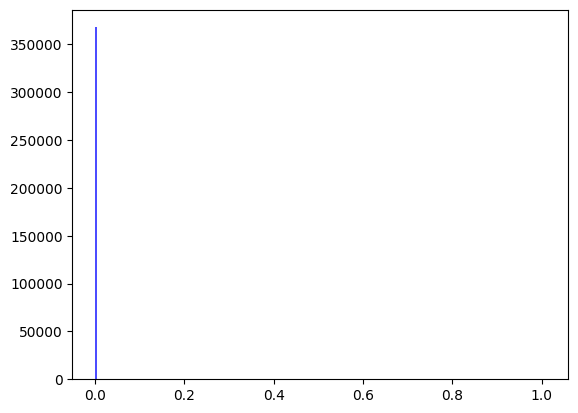

[2023-10-01T20:05:36.140662+00:00] Epochs 18, total loss: 1.08770e+04
[2023-10-01T20:05:36.140892+00:00] Training llk: -7.56405e-01
[2023-10-01T20:05:36.140989+00:00] Testing llk: -9.97740e-01
[2023-10-01T20:05:36.141083+00:00] MAE:0.09929, MRE:0.15946
saving model


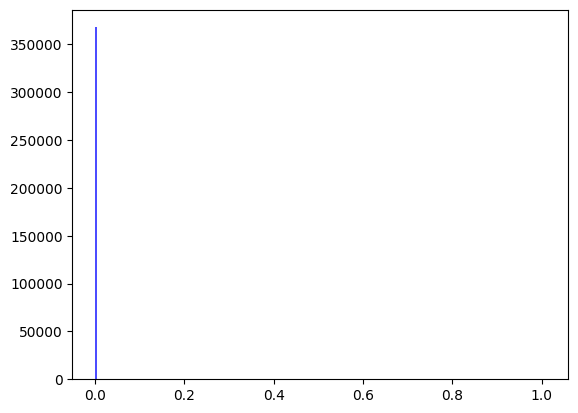

[2023-10-01T20:05:37.111378+00:00] Epochs 19, total loss: 1.23557e+04
[2023-10-01T20:05:37.111637+00:00] Training llk: -7.56197e-01
[2023-10-01T20:05:37.111748+00:00] Testing llk: -9.97526e-01
[2023-10-01T20:05:37.111848+00:00] MAE:0.09834, MRE:0.15532
saving model


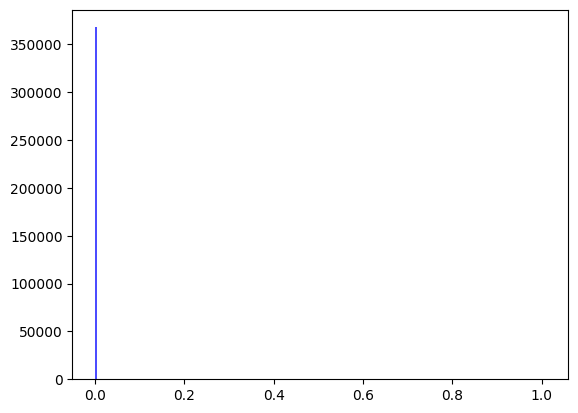

[2023-10-01T20:05:38.280801+00:00] Epochs 20, total loss: 1.28163e+04
[2023-10-01T20:05:38.281899+00:00] Training llk: -7.53778e-01
[2023-10-01T20:05:38.282466+00:00] Testing llk: -9.95186e-01
[2023-10-01T20:05:38.282972+00:00] MAE:0.10447, MRE:0.16440
saving model


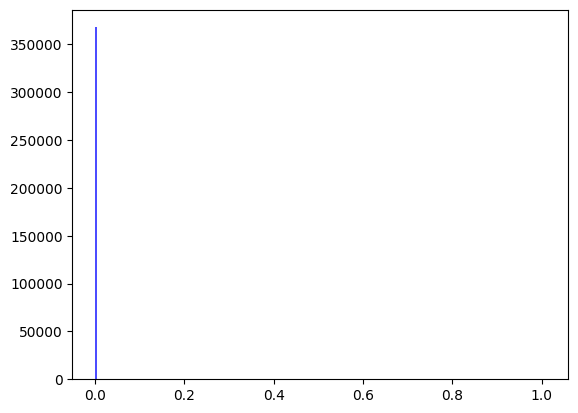

[2023-10-01T20:05:39.824233+00:00] Epochs 21, total loss: 1.20414e+04
[2023-10-01T20:05:39.825512+00:00] Training llk: -7.56091e-01
[2023-10-01T20:05:39.826130+00:00] Testing llk: -9.97454e-01
[2023-10-01T20:05:39.826681+00:00] MAE:0.09606, MRE:0.14647
saving model


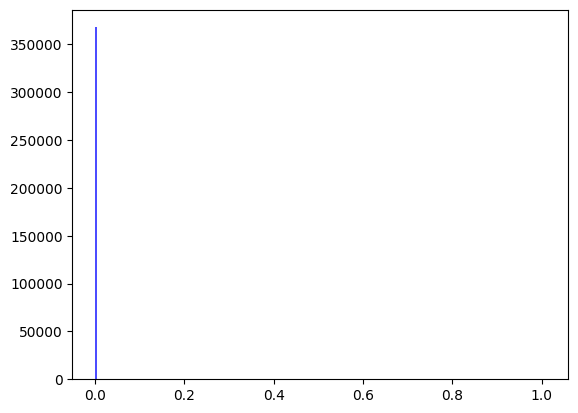

[2023-10-01T20:05:41.343034+00:00] Epochs 22, total loss: 1.20067e+04
[2023-10-01T20:05:41.343249+00:00] Training llk: -7.53044e-01
[2023-10-01T20:05:41.343339+00:00] Testing llk: -9.94497e-01
[2023-10-01T20:05:41.343422+00:00] MAE:0.10428, MRE:0.15984
saving model


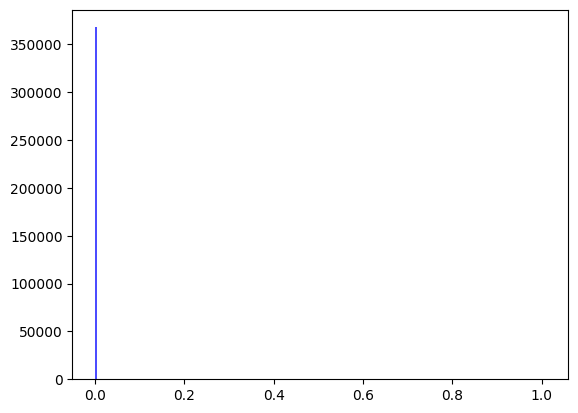

[2023-10-01T20:05:42.360566+00:00] Epochs 23, total loss: 1.14883e+04
[2023-10-01T20:05:42.360797+00:00] Training llk: -7.53146e-01
[2023-10-01T20:05:42.360889+00:00] Testing llk: -9.94572e-01
[2023-10-01T20:05:42.360960+00:00] MAE:0.10235, MRE:0.15442
saving model


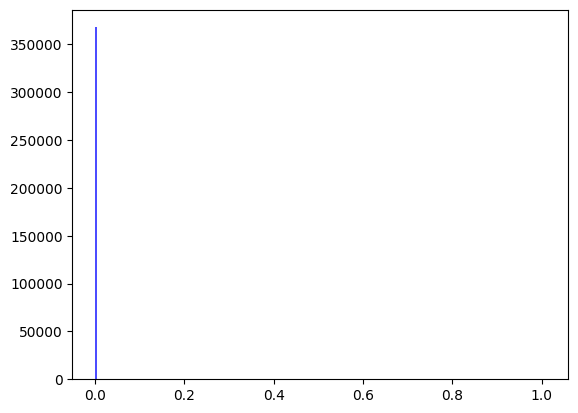

[2023-10-01T20:05:43.357912+00:00] Epochs 24, total loss: 1.09746e+04
[2023-10-01T20:05:43.358145+00:00] Training llk: -7.55695e-01
[2023-10-01T20:05:43.358239+00:00] Testing llk: -9.97133e-01
[2023-10-01T20:05:43.358309+00:00] MAE:0.09454, MRE:0.13880
saving model


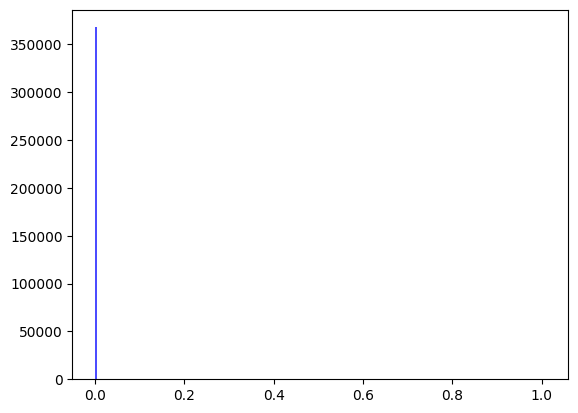

[2023-10-01T20:05:44.329115+00:00] Epochs 25, total loss: 1.17816e+04
[2023-10-01T20:05:44.329339+00:00] Training llk: -7.53631e-01
[2023-10-01T20:05:44.329436+00:00] Testing llk: -9.95052e-01
[2023-10-01T20:05:44.329503+00:00] MAE:0.09904, MRE:0.14584
saving model


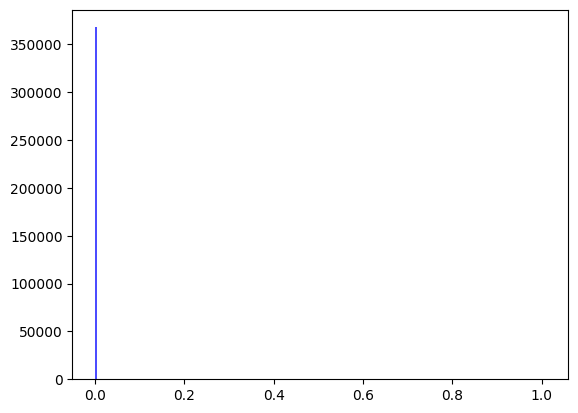

[2023-10-01T20:05:45.315618+00:00] Epochs 26, total loss: 1.21177e+04
[2023-10-01T20:05:45.316135+00:00] Training llk: -7.53526e-01
[2023-10-01T20:05:45.316249+00:00] Testing llk: -9.94972e-01
[2023-10-01T20:05:45.316327+00:00] MAE:0.09877, MRE:0.14418
saving model


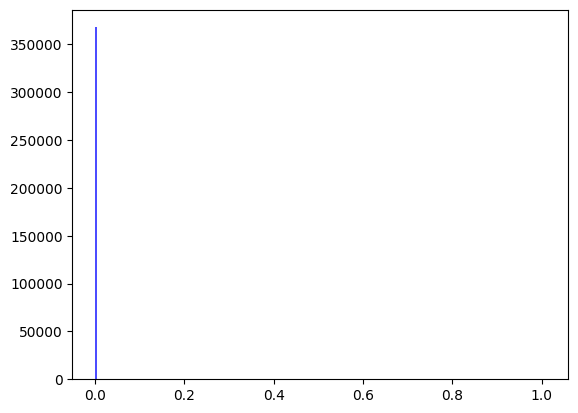

[2023-10-01T20:05:46.369350+00:00] Epochs 27, total loss: 1.32255e+04
[2023-10-01T20:05:46.369711+00:00] Training llk: -7.54834e-01
[2023-10-01T20:05:46.369845+00:00] Testing llk: -9.96333e-01
[2023-10-01T20:05:46.369938+00:00] MAE:0.09487, MRE:0.13590
saving model


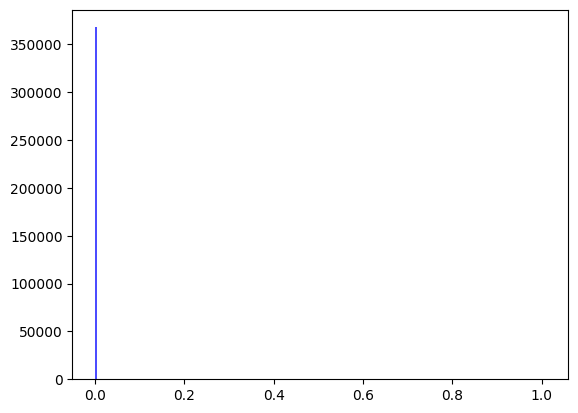

[2023-10-01T20:05:47.776485+00:00] Epochs 28, total loss: 1.18746e+04
[2023-10-01T20:05:47.777512+00:00] Training llk: -7.54678e-01
[2023-10-01T20:05:47.777649+00:00] Testing llk: -9.96205e-01
[2023-10-01T20:05:47.777925+00:00] MAE:0.09480, MRE:0.13475
saving model


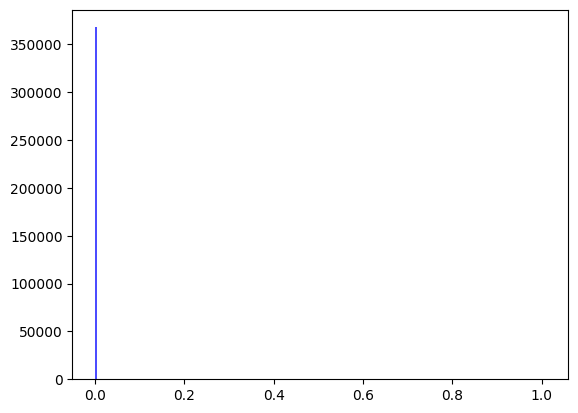

[2023-10-01T20:05:48.805926+00:00] Epochs 29, total loss: 1.23430e+04
[2023-10-01T20:05:48.807124+00:00] Training llk: -7.52513e-01
[2023-10-01T20:05:48.807691+00:00] Testing llk: -9.94098e-01
[2023-10-01T20:05:48.808275+00:00] MAE:0.10041, MRE:0.14350
saving model


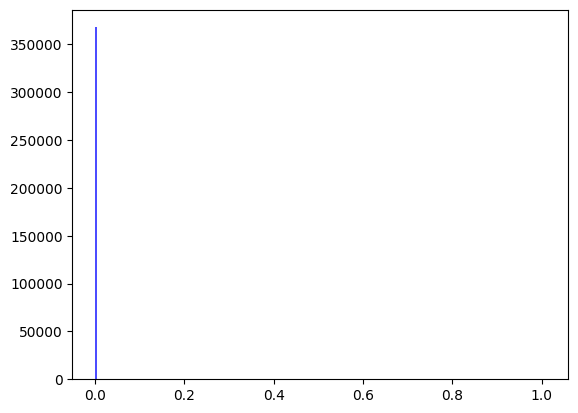

[2023-10-01T20:05:49.809556+00:00] Epochs 30, total loss: 1.22805e+04
[2023-10-01T20:05:49.810376+00:00] Training llk: -7.54247e-01
[2023-10-01T20:05:49.810707+00:00] Testing llk: -9.95843e-01
[2023-10-01T20:05:49.811128+00:00] MAE:0.09497, MRE:0.13289
saving model


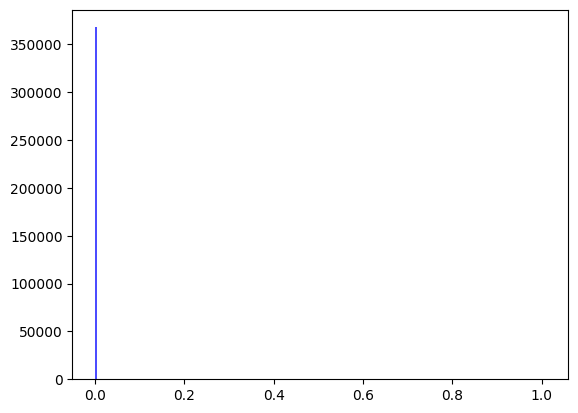

[2023-10-01T20:05:50.903915+00:00] Epochs 31, total loss: 1.28733e+04
[2023-10-01T20:05:50.905123+00:00] Training llk: -7.53795e-01
[2023-10-01T20:05:50.905672+00:00] Testing llk: -9.95428e-01
[2023-10-01T20:05:50.906230+00:00] MAE:0.09567, MRE:0.13299
saving model


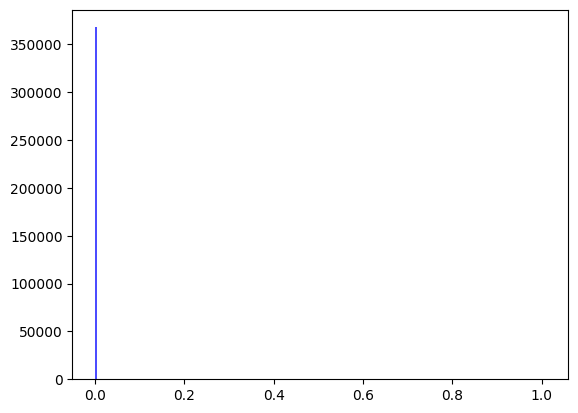

[2023-10-01T20:05:52.325718+00:00] Epochs 32, total loss: 1.13396e+04
[2023-10-01T20:05:52.326841+00:00] Training llk: -7.52697e-01
[2023-10-01T20:05:52.327383+00:00] Testing llk: -9.94383e-01
[2023-10-01T20:05:52.327862+00:00] MAE:0.09844, MRE:0.13685
saving model


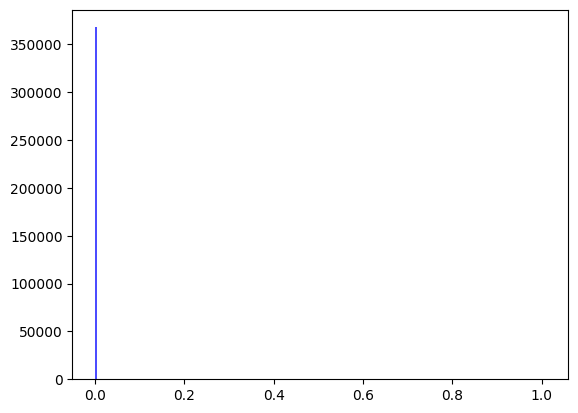

[2023-10-01T20:05:53.680931+00:00] Epochs 33, total loss: 1.16677e+04
[2023-10-01T20:05:53.681157+00:00] Training llk: -7.54441e-01
[2023-10-01T20:05:53.681252+00:00] Testing llk: -9.96172e-01
[2023-10-01T20:05:53.681322+00:00] MAE:0.09369, MRE:0.12798
saving model


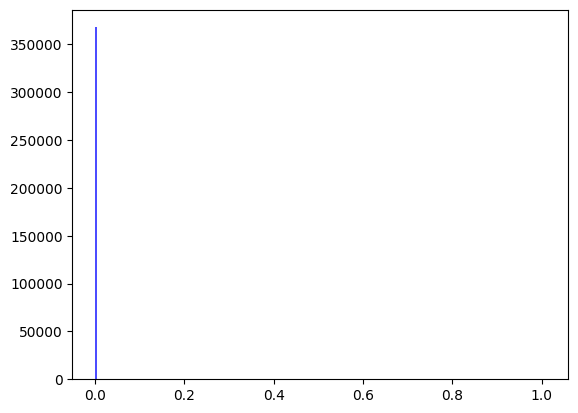

[2023-10-01T20:05:54.926085+00:00] Epochs 34, total loss: 1.17356e+04
[2023-10-01T20:05:54.926359+00:00] Training llk: -7.52128e-01
[2023-10-01T20:05:54.926455+00:00] Testing llk: -9.93914e-01
[2023-10-01T20:05:54.926536+00:00] MAE:0.09998, MRE:0.13810
saving model


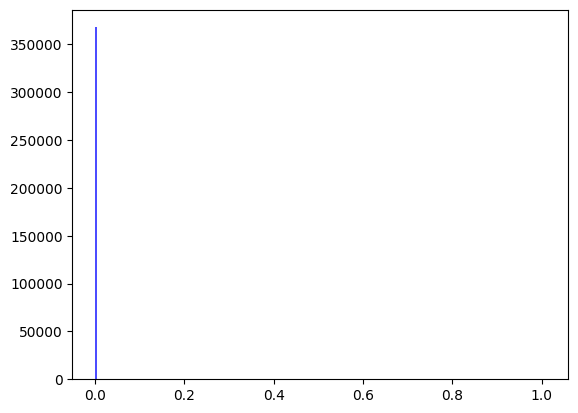

[2023-10-01T20:05:55.874740+00:00] Epochs 35, total loss: 1.15736e+04
[2023-10-01T20:05:55.874951+00:00] Training llk: -7.51042e-01
[2023-10-01T20:05:55.875051+00:00] Testing llk: -9.93114e-01
[2023-10-01T20:05:55.875124+00:00] MAE:0.10570, MRE:0.14673
saving model


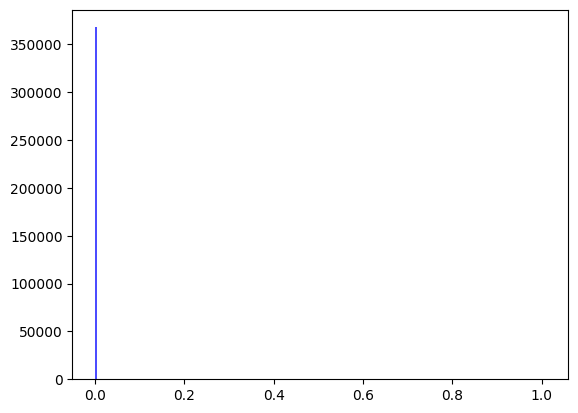

[2023-10-01T20:05:56.873892+00:00] Epochs 36, total loss: 1.14443e+04
[2023-10-01T20:05:56.874146+00:00] Training llk: -7.54280e-01
[2023-10-01T20:05:56.874239+00:00] Testing llk: -9.96091e-01
[2023-10-01T20:05:56.874311+00:00] MAE:0.09364, MRE:0.12639
saving model


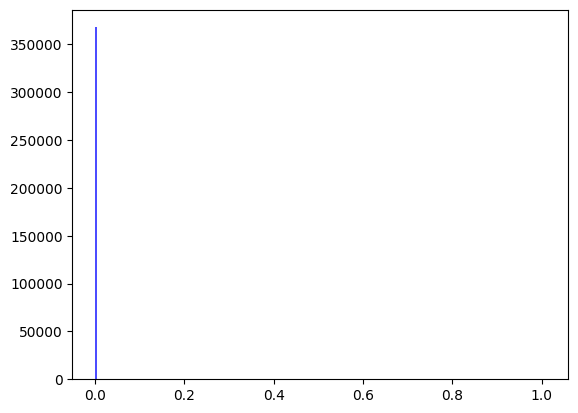

[2023-10-01T20:05:57.839860+00:00] Epochs 37, total loss: 1.14884e+04
[2023-10-01T20:05:57.840128+00:00] Training llk: -7.52957e-01
[2023-10-01T20:05:57.840229+00:00] Testing llk: -9.94779e-01
[2023-10-01T20:05:57.840303+00:00] MAE:0.09681, MRE:0.13122
saving model


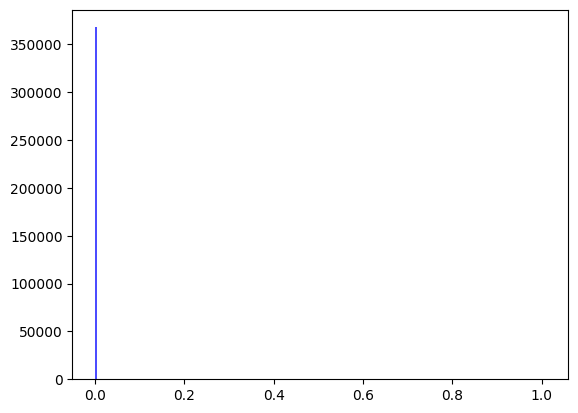

[2023-10-01T20:05:58.857453+00:00] Epochs 38, total loss: 1.33174e+04
[2023-10-01T20:05:58.858407+00:00] Training llk: -7.52799e-01
[2023-10-01T20:05:58.858517+00:00] Testing llk: -9.94664e-01
[2023-10-01T20:05:58.858593+00:00] MAE:0.09711, MRE:0.13108
saving model


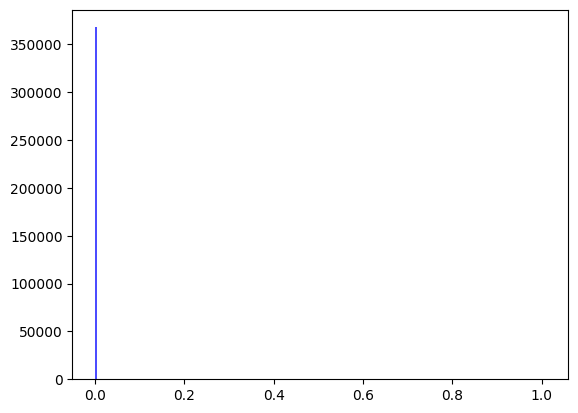

[2023-10-01T20:05:59.861815+00:00] Epochs 39, total loss: 1.33185e+04
[2023-10-01T20:05:59.862103+00:00] Training llk: -7.57269e-01
[2023-10-01T20:05:59.862205+00:00] Testing llk: -9.99417e-01
[2023-10-01T20:05:59.862296+00:00] MAE:0.08810, MRE:0.11524
saving model


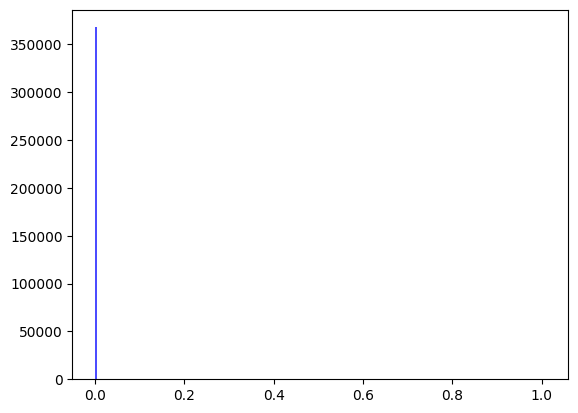

[2023-10-01T20:06:01.145582+00:00] Epochs 40, total loss: 1.24095e+04
[2023-10-01T20:06:01.145806+00:00] Training llk: -7.52136e-01
[2023-10-01T20:06:01.145894+00:00] Testing llk: -9.94109e-01
[2023-10-01T20:06:01.145964+00:00] MAE:0.09906, MRE:0.13315
saving model


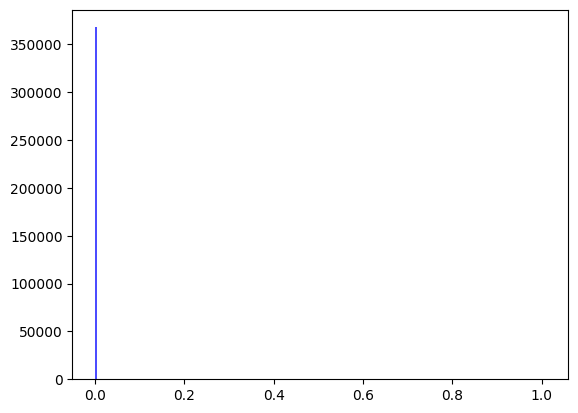

[2023-10-01T20:06:02.162286+00:00] Epochs 41, total loss: 1.22682e+04
[2023-10-01T20:06:02.163603+00:00] Training llk: -7.52306e-01
[2023-10-01T20:06:02.163764+00:00] Testing llk: -9.94297e-01
[2023-10-01T20:06:02.165354+00:00] MAE:0.09838, MRE:0.13159
saving model


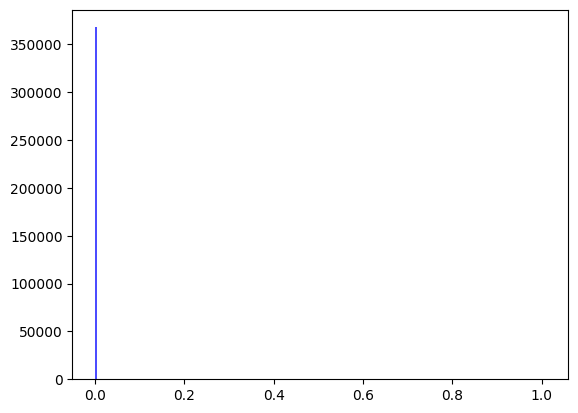

[2023-10-01T20:06:03.203167+00:00] Epochs 42, total loss: 1.16075e+04
[2023-10-01T20:06:03.203394+00:00] Training llk: -7.52221e-01
[2023-10-01T20:06:03.203481+00:00] Testing llk: -9.94258e-01
[2023-10-01T20:06:03.203559+00:00] MAE:0.09859, MRE:0.13137
saving model


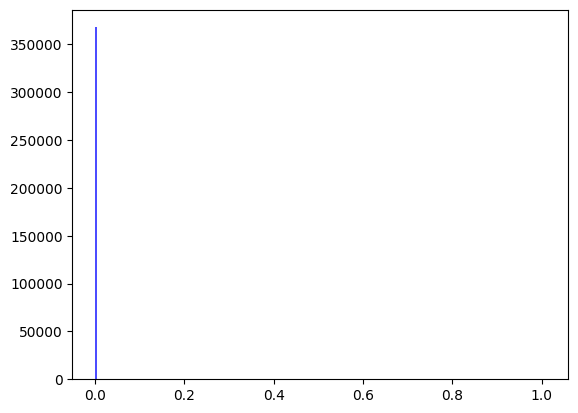

[2023-10-01T20:06:04.560133+00:00] Epochs 43, total loss: 1.32095e+04
[2023-10-01T20:06:04.560404+00:00] Training llk: -7.53551e-01
[2023-10-01T20:06:04.560505+00:00] Testing llk: -9.95582e-01
[2023-10-01T20:06:04.560583+00:00] MAE:0.09465, MRE:0.12459
saving model


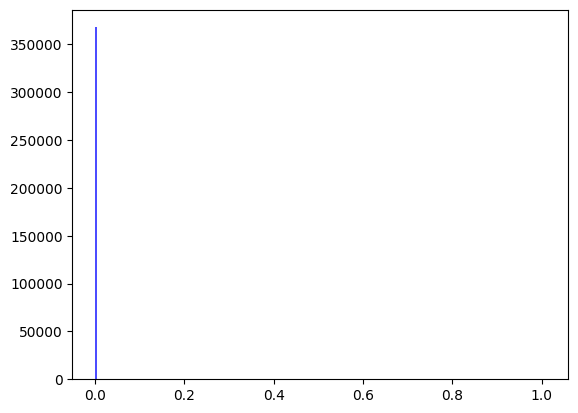

[2023-10-01T20:06:06.176846+00:00] Epochs 44, total loss: 1.16614e+04
[2023-10-01T20:06:06.179139+00:00] Training llk: -7.52235e-01
[2023-10-01T20:06:06.179286+00:00] Testing llk: -9.94330e-01
[2023-10-01T20:06:06.179358+00:00] MAE:0.09845, MRE:0.13035
saving model


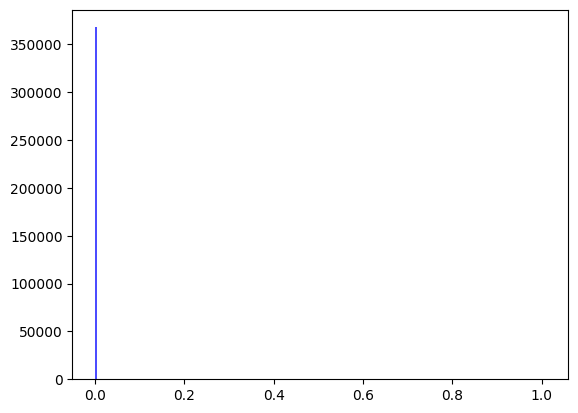

[2023-10-01T20:06:08.509462+00:00] Epochs 45, total loss: 1.06656e+04
[2023-10-01T20:06:08.520185+00:00] Training llk: -7.50752e-01
[2023-10-01T20:06:08.521009+00:00] Testing llk: -9.93338e-01
[2023-10-01T20:06:08.521681+00:00] MAE:0.10806, MRE:0.14472
saving model


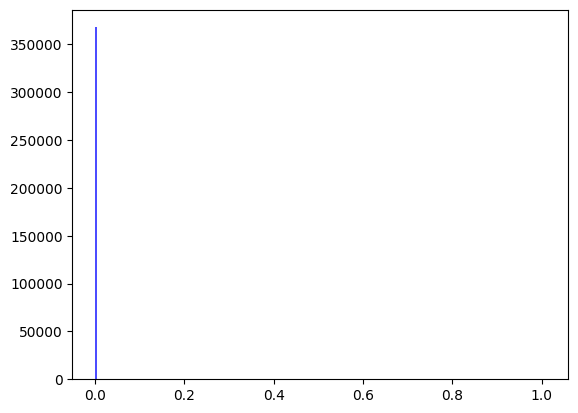

[2023-10-01T20:06:10.486218+00:00] Epochs 46, total loss: 1.19641e+04
[2023-10-01T20:06:10.486445+00:00] Training llk: -7.52160e-01
[2023-10-01T20:06:10.486522+00:00] Testing llk: -9.94310e-01
[2023-10-01T20:06:10.486591+00:00] MAE:0.09868, MRE:0.13010
saving model


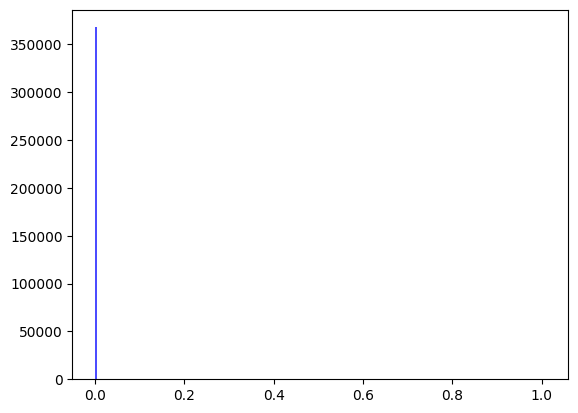

[2023-10-01T20:06:11.453182+00:00] Epochs 47, total loss: 1.25200e+04
[2023-10-01T20:06:11.453404+00:00] Training llk: -7.55519e-01
[2023-10-01T20:06:11.453487+00:00] Testing llk: -9.97737e-01
[2023-10-01T20:06:11.453558+00:00] MAE:0.09048, MRE:0.11662
saving model


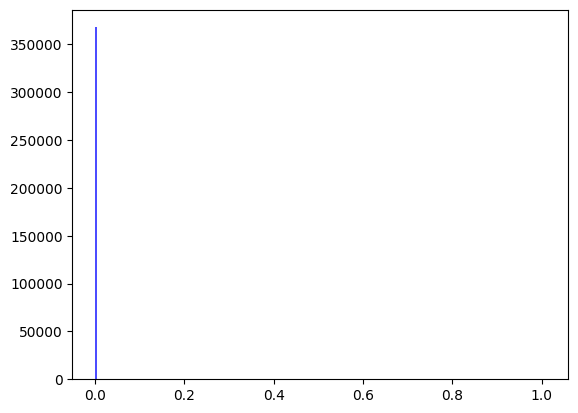

[2023-10-01T20:06:12.433329+00:00] Epochs 48, total loss: 1.23934e+04
[2023-10-01T20:06:12.433543+00:00] Training llk: -7.51863e-01
[2023-10-01T20:06:12.433632+00:00] Testing llk: -9.94088e-01
[2023-10-01T20:06:12.433706+00:00] MAE:0.09982, MRE:0.13142
saving model


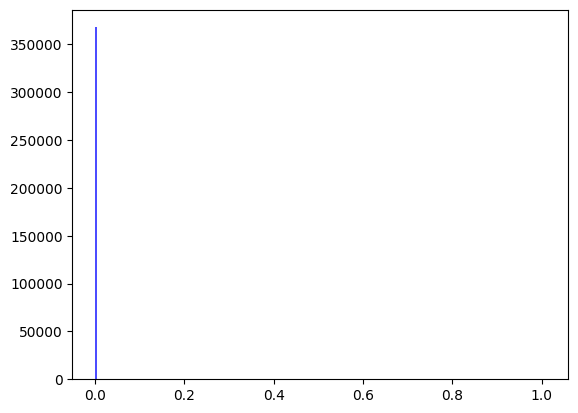

[2023-10-01T20:06:13.386555+00:00] Epochs 49, total loss: 1.26258e+04
[2023-10-01T20:06:13.387428+00:00] Training llk: -7.57184e-01
[2023-10-01T20:06:13.387754+00:00] Testing llk: -9.99578e-01
[2023-10-01T20:06:13.388073+00:00] MAE:0.08783, MRE:0.11188
saving model


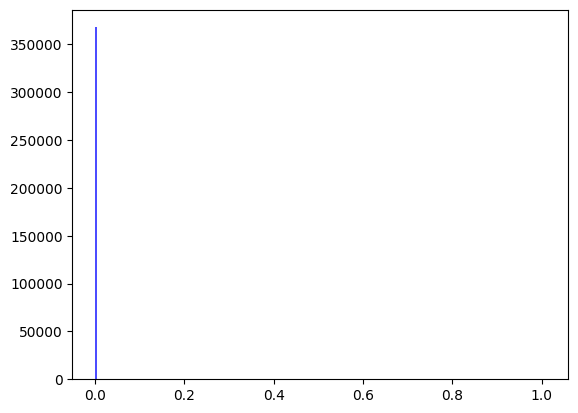

[2023-10-01T20:06:14.319399+00:00] Epochs 50, total loss: 1.17988e+04
[2023-10-01T20:06:14.319722+00:00] Training llk: -7.51869e-01
[2023-10-01T20:06:14.319829+00:00] Testing llk: -9.94129e-01
[2023-10-01T20:06:14.319907+00:00] MAE:0.09979, MRE:0.13098
saving model


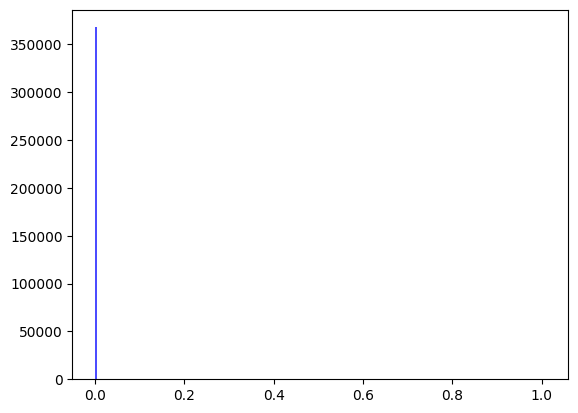

[2023-10-01T20:06:15.278484+00:00] Epochs 51, total loss: 1.18458e+04
[2023-10-01T20:06:15.278700+00:00] Training llk: -7.51628e-01
[2023-10-01T20:06:15.278789+00:00] Testing llk: -9.93935e-01
[2023-10-01T20:06:15.278865+00:00] MAE:0.10089, MRE:0.13258
saving model


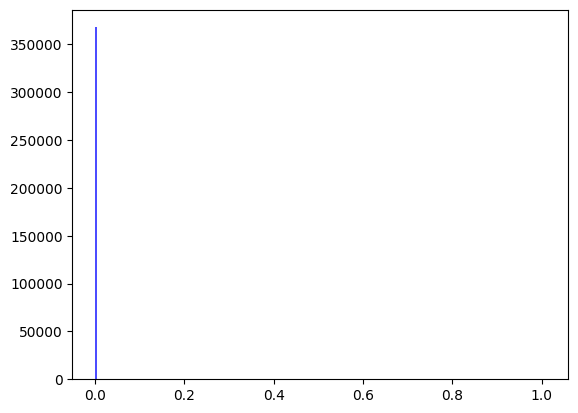

[2023-10-01T20:06:16.618443+00:00] Epochs 52, total loss: 1.16438e+04
[2023-10-01T20:06:16.619586+00:00] Training llk: -7.53252e-01
[2023-10-01T20:06:16.620125+00:00] Testing llk: -9.95437e-01
[2023-10-01T20:06:16.620613+00:00] MAE:0.09525, MRE:0.12375
saving model


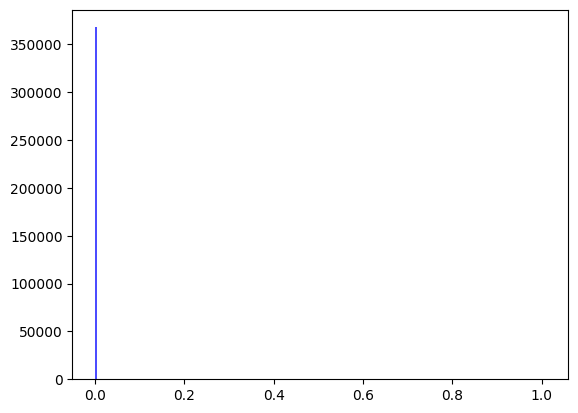

[2023-10-01T20:06:18.179772+00:00] Epochs 53, total loss: 1.22533e+04
[2023-10-01T20:06:18.180903+00:00] Training llk: -7.54183e-01
[2023-10-01T20:06:18.181455+00:00] Testing llk: -9.96385e-01
[2023-10-01T20:06:18.181938+00:00] MAE:0.09302, MRE:0.12017
saving model


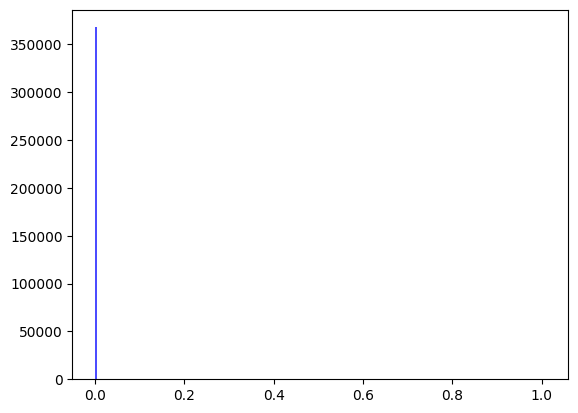

[2023-10-01T20:06:19.576707+00:00] Epochs 54, total loss: 1.18223e+04
[2023-10-01T20:06:19.577877+00:00] Training llk: -7.50847e-01
[2023-10-01T20:06:19.578360+00:00] Testing llk: -9.93458e-01
[2023-10-01T20:06:19.578804+00:00] MAE:0.10680, MRE:0.14153
saving model


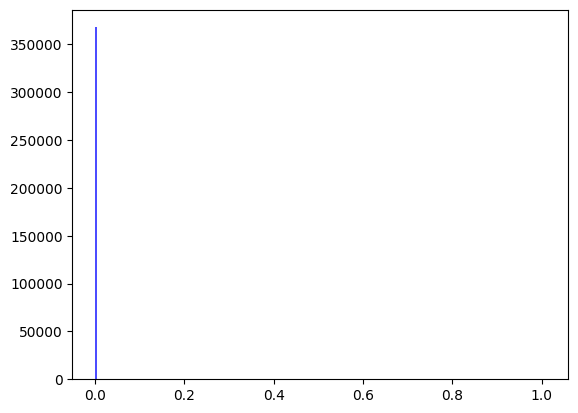

[2023-10-01T20:06:20.576611+00:00] Epochs 55, total loss: 1.16197e+04
[2023-10-01T20:06:20.576842+00:00] Training llk: -7.51362e-01
[2023-10-01T20:06:20.576940+00:00] Testing llk: -9.93719e-01
[2023-10-01T20:06:20.577038+00:00] MAE:0.10232, MRE:0.13489
saving model


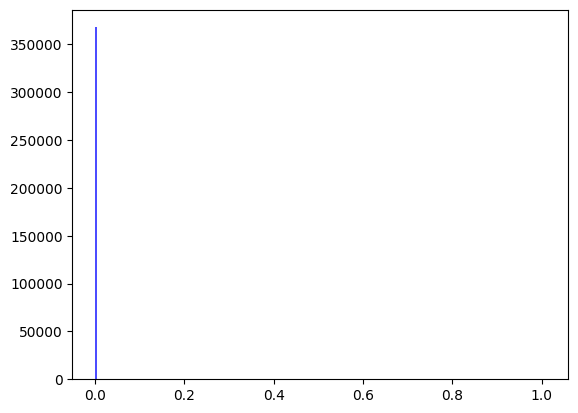

[2023-10-01T20:06:21.571288+00:00] Epochs 56, total loss: 1.15265e+04
[2023-10-01T20:06:21.572229+00:00] Training llk: -7.52550e-01
[2023-10-01T20:06:21.572364+00:00] Testing llk: -9.94758e-01
[2023-10-01T20:06:21.572474+00:00] MAE:0.09730, MRE:0.12695
saving model


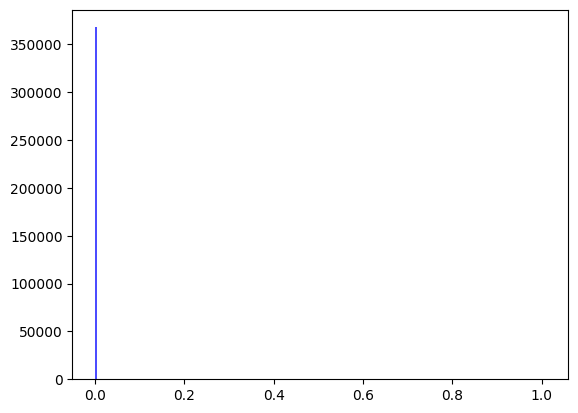

[2023-10-01T20:06:22.571936+00:00] Epochs 57, total loss: 1.11893e+04
[2023-10-01T20:06:22.572527+00:00] Training llk: -7.51428e-01
[2023-10-01T20:06:22.572637+00:00] Testing llk: -9.93801e-01
[2023-10-01T20:06:22.572719+00:00] MAE:0.10197, MRE:0.13398
saving model


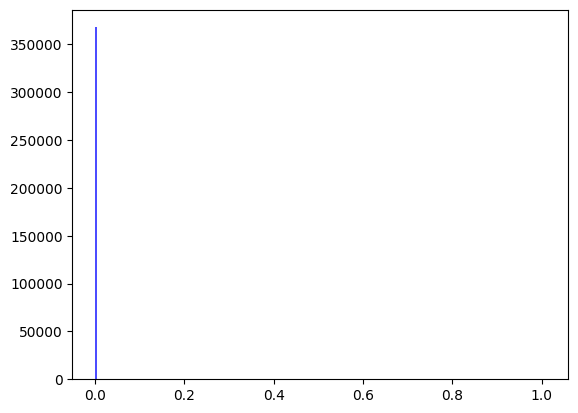

[2023-10-01T20:06:23.927960+00:00] Epochs 58, total loss: 1.17992e+04
[2023-10-01T20:06:23.929295+00:00] Training llk: -7.51497e-01
[2023-10-01T20:06:23.929868+00:00] Testing llk: -9.93869e-01
[2023-10-01T20:06:23.930451+00:00] MAE:0.10159, MRE:0.13326
saving model


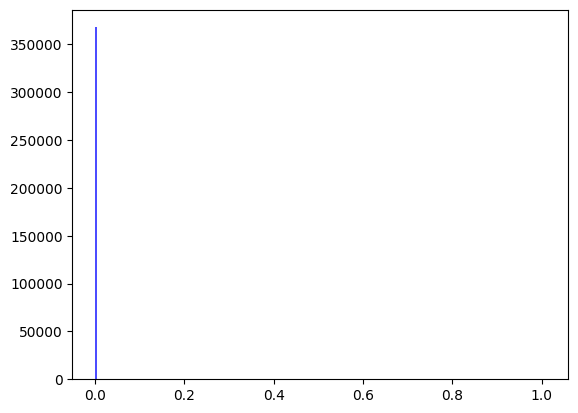

[2023-10-01T20:06:24.940959+00:00] Epochs 59, total loss: 1.19860e+04
[2023-10-01T20:06:24.941829+00:00] Training llk: -7.56257e-01
[2023-10-01T20:06:24.942234+00:00] Testing llk: -9.98621e-01
[2023-10-01T20:06:24.942527+00:00] MAE:0.08918, MRE:0.11360
saving model


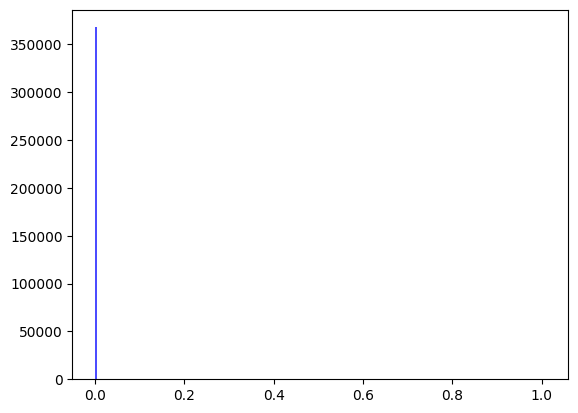

[2023-10-01T20:06:25.938612+00:00] Epochs 60, total loss: 1.19566e+04
[2023-10-01T20:06:25.939617+00:00] Training llk: -7.50821e-01
[2023-10-01T20:06:25.939956+00:00] Testing llk: -9.93544e-01
[2023-10-01T20:06:25.940445+00:00] MAE:0.10761, MRE:0.14198
saving model


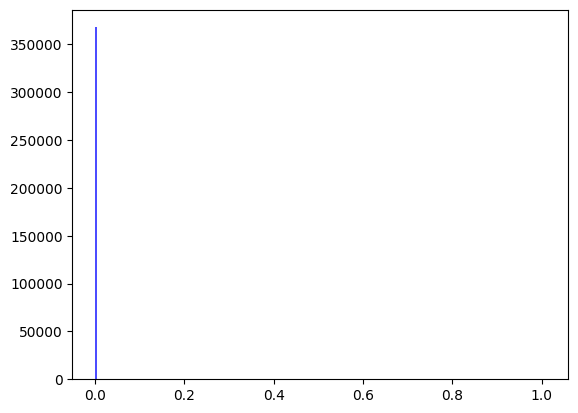

[2023-10-01T20:06:26.950856+00:00] Epochs 61, total loss: 1.25467e+04
[2023-10-01T20:06:26.951138+00:00] Training llk: -7.52648e-01
[2023-10-01T20:06:26.951237+00:00] Testing llk: -9.94883e-01
[2023-10-01T20:06:26.951317+00:00] MAE:0.09698, MRE:0.12611
saving model


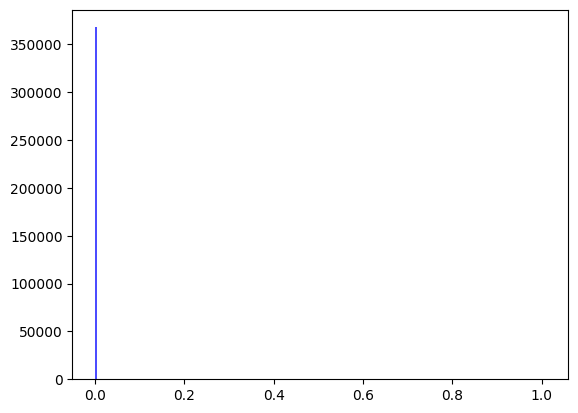

[2023-10-01T20:06:27.929380+00:00] Epochs 62, total loss: 1.29179e+04
[2023-10-01T20:06:27.930281+00:00] Training llk: -7.52943e-01
[2023-10-01T20:06:27.930411+00:00] Testing llk: -9.95175e-01
[2023-10-01T20:06:27.930484+00:00] MAE:0.09610, MRE:0.12464
saving model


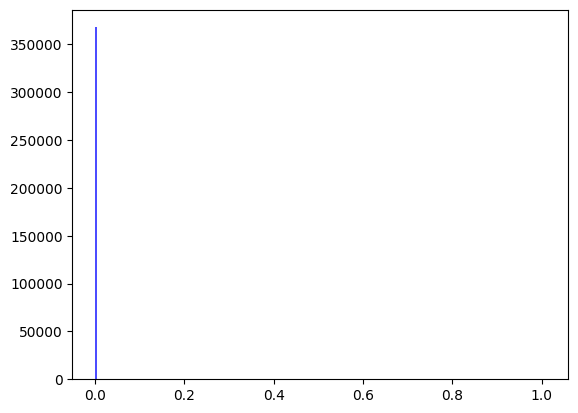

[2023-10-01T20:06:28.886355+00:00] Epochs 63, total loss: 1.29362e+04
[2023-10-01T20:06:28.887283+00:00] Training llk: -7.52590e-01
[2023-10-01T20:06:28.887423+00:00] Testing llk: -9.94859e-01
[2023-10-01T20:06:28.887507+00:00] MAE:0.09717, MRE:0.12608
saving model


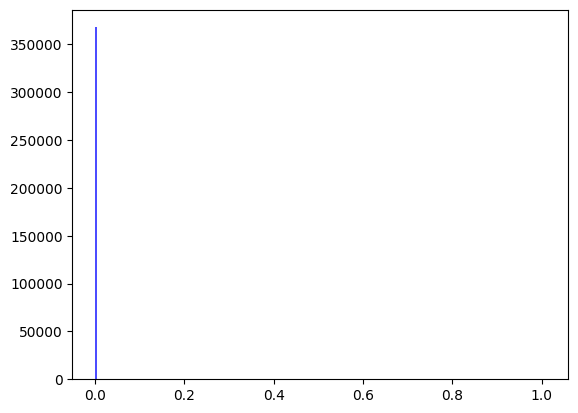

[2023-10-01T20:06:30.432408+00:00] Epochs 64, total loss: 1.10986e+04
[2023-10-01T20:06:30.433617+00:00] Training llk: -7.52655e-01
[2023-10-01T20:06:30.434206+00:00] Testing llk: -9.94933e-01
[2023-10-01T20:06:30.434737+00:00] MAE:0.09697, MRE:0.12564
saving model


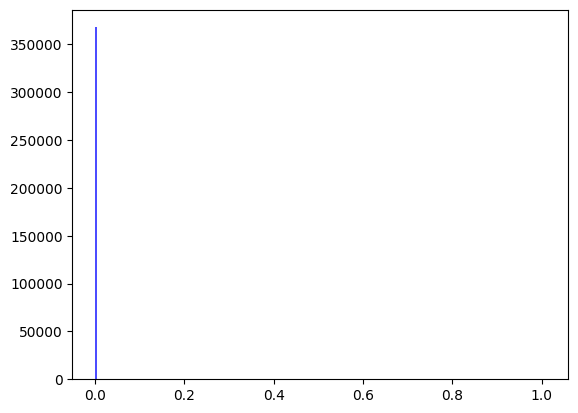

[2023-10-01T20:06:31.873176+00:00] Epochs 65, total loss: 1.12123e+04
[2023-10-01T20:06:31.874289+00:00] Training llk: -7.54578e-01
[2023-10-01T20:06:31.874808+00:00] Testing llk: -9.96867e-01
[2023-10-01T20:06:31.875344+00:00] MAE:0.09216, MRE:0.11807
saving model


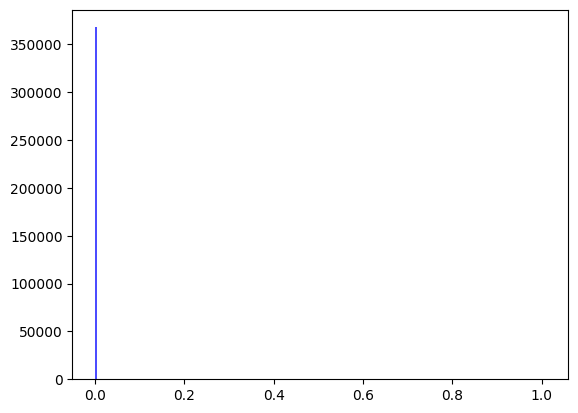

[2023-10-01T20:06:32.933091+00:00] Epochs 66, total loss: 1.33074e+04
[2023-10-01T20:06:32.934268+00:00] Training llk: -7.51666e-01
[2023-10-01T20:06:32.934767+00:00] Testing llk: -9.94036e-01
[2023-10-01T20:06:32.935288+00:00] MAE:0.10076, MRE:0.13164
saving model


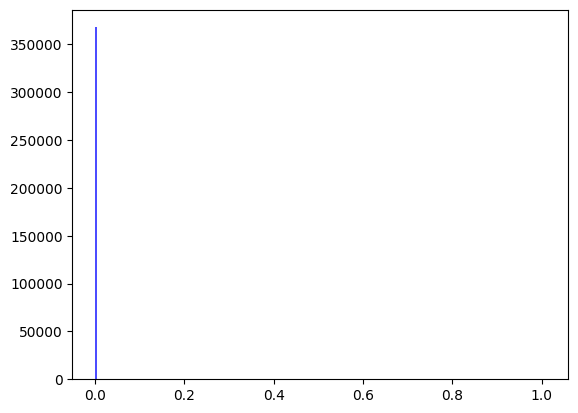

[2023-10-01T20:06:33.870933+00:00] Epochs 67, total loss: 1.24782e+04
[2023-10-01T20:06:33.871209+00:00] Training llk: -7.54487e-01
[2023-10-01T20:06:33.871294+00:00] Testing llk: -9.96742e-01
[2023-10-01T20:06:33.871386+00:00] MAE:0.09236, MRE:0.11868
saving model


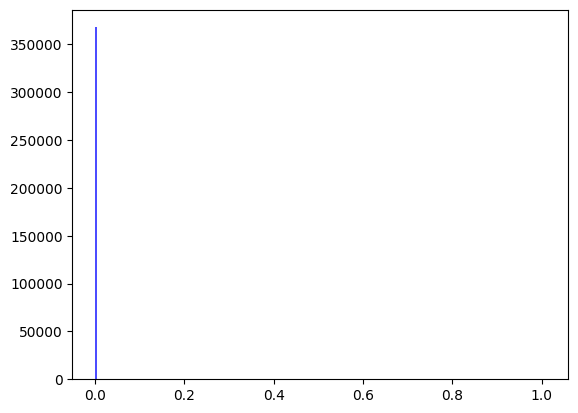

[2023-10-01T20:06:34.847445+00:00] Epochs 68, total loss: 1.15259e+04
[2023-10-01T20:06:34.848363+00:00] Training llk: -7.51594e-01
[2023-10-01T20:06:34.848491+00:00] Testing llk: -9.93954e-01
[2023-10-01T20:06:34.848571+00:00] MAE:0.10110, MRE:0.13240
saving model


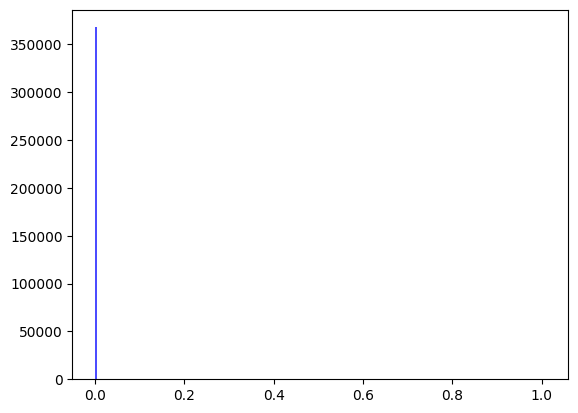

[2023-10-01T20:06:36.057080+00:00] Epochs 69, total loss: 1.27585e+04
[2023-10-01T20:06:36.057956+00:00] Training llk: -7.53639e-01
[2023-10-01T20:06:36.058101+00:00] Testing llk: -9.95878e-01
[2023-10-01T20:06:36.058185+00:00] MAE:0.09425, MRE:0.12162
saving model


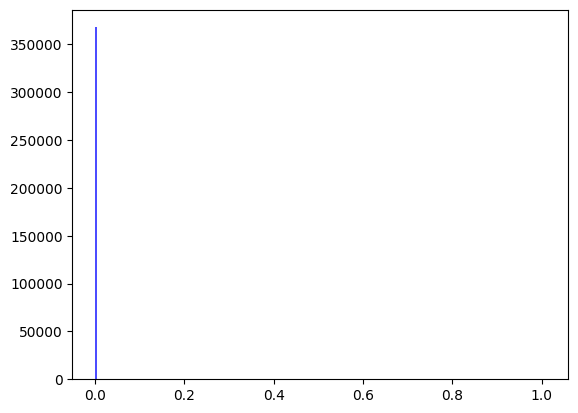

[2023-10-01T20:06:37.030847+00:00] Epochs 70, total loss: 1.25863e+04
[2023-10-01T20:06:37.031154+00:00] Training llk: -7.54021e-01
[2023-10-01T20:06:37.031264+00:00] Testing llk: -9.96266e-01
[2023-10-01T20:06:37.031341+00:00] MAE:0.09336, MRE:0.12022
saving model


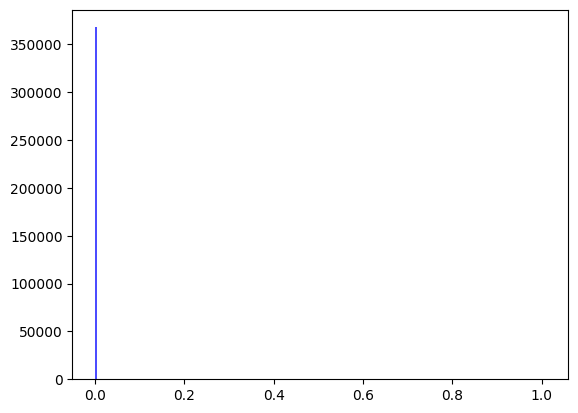

[2023-10-01T20:06:38.009740+00:00] Epochs 71, total loss: 1.18759e+04
[2023-10-01T20:06:38.010874+00:00] Training llk: -7.53960e-01
[2023-10-01T20:06:38.011408+00:00] Testing llk: -9.96201e-01
[2023-10-01T20:06:38.014423+00:00] MAE:0.09350, MRE:0.12045
saving model


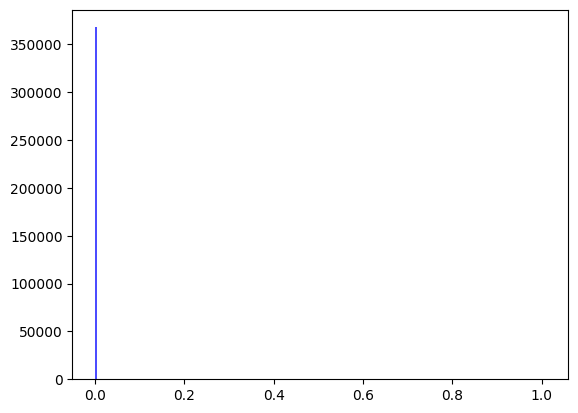

[2023-10-01T20:06:39.024953+00:00] Epochs 72, total loss: 1.23921e+04
[2023-10-01T20:06:39.025281+00:00] Training llk: -7.50892e-01
[2023-10-01T20:06:39.025396+00:00] Testing llk: -9.93564e-01
[2023-10-01T20:06:39.025480+00:00] MAE:0.10655, MRE:0.14025
saving model


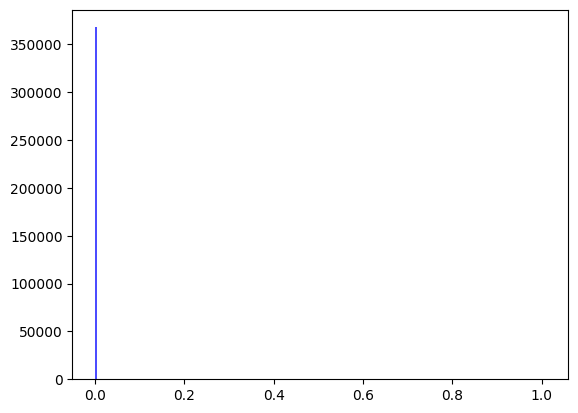

[2023-10-01T20:06:40.060069+00:00] Epochs 73, total loss: 1.16530e+04
[2023-10-01T20:06:40.060347+00:00] Training llk: -7.54182e-01
[2023-10-01T20:06:40.060460+00:00] Testing llk: -9.96446e-01
[2023-10-01T20:06:40.060545+00:00] MAE:0.09300, MRE:0.11951
saving model


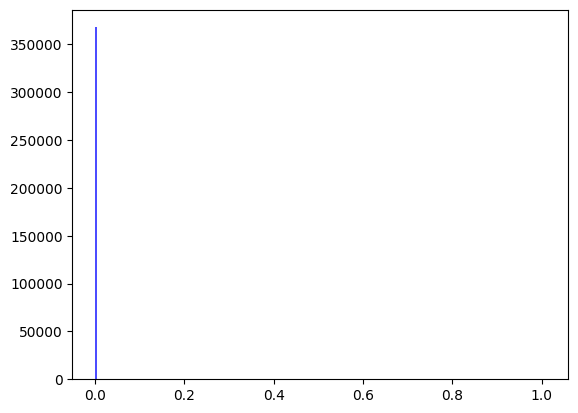

[2023-10-01T20:06:41.017751+00:00] Epochs 74, total loss: 1.18853e+04
[2023-10-01T20:06:41.018834+00:00] Training llk: -7.52330e-01
[2023-10-01T20:06:41.019356+00:00] Testing llk: -9.94627e-01
[2023-10-01T20:06:41.019978+00:00] MAE:0.09805, MRE:0.12734
saving model


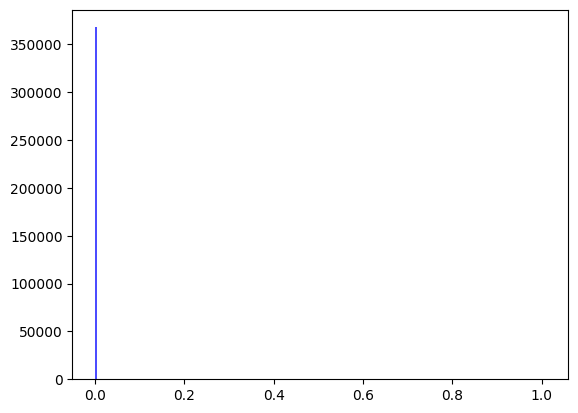

[2023-10-01T20:06:42.940765+00:00] Epochs 75, total loss: 1.16167e+04
[2023-10-01T20:06:42.941891+00:00] Training llk: -7.51289e-01
[2023-10-01T20:06:42.942451+00:00] Testing llk: -9.93785e-01
[2023-10-01T20:06:42.942979+00:00] MAE:0.10295, MRE:0.13464
saving model


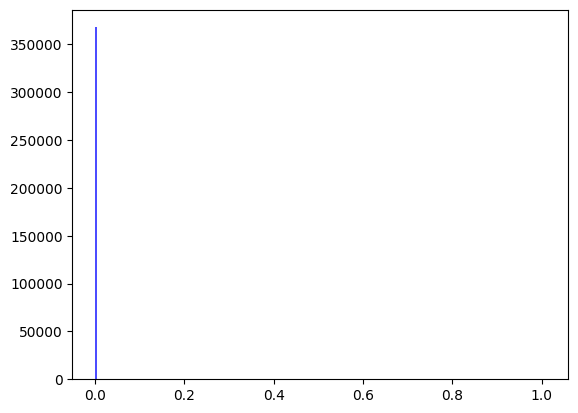

[2023-10-01T20:06:44.425586+00:00] Epochs 76, total loss: 1.19068e+04
[2023-10-01T20:06:44.427173+00:00] Training llk: -7.53418e-01
[2023-10-01T20:06:44.428363+00:00] Testing llk: -9.95711e-01
[2023-10-01T20:06:44.428971+00:00] MAE:0.09480, MRE:0.12194
saving model


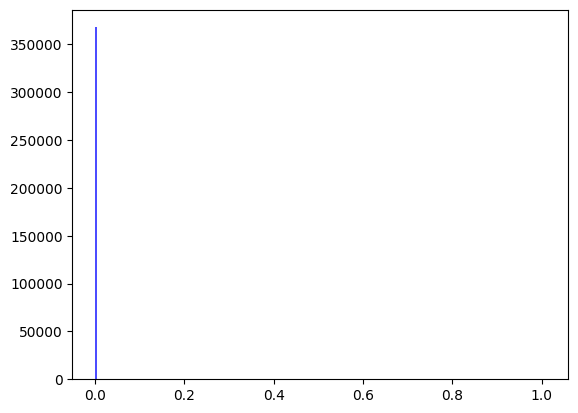

[2023-10-01T20:06:45.663763+00:00] Epochs 77, total loss: 1.19687e+04
[2023-10-01T20:06:45.664049+00:00] Training llk: -7.51337e-01
[2023-10-01T20:06:45.664152+00:00] Testing llk: -9.93863e-01
[2023-10-01T20:06:45.664231+00:00] MAE:0.10273, MRE:0.13389
saving model


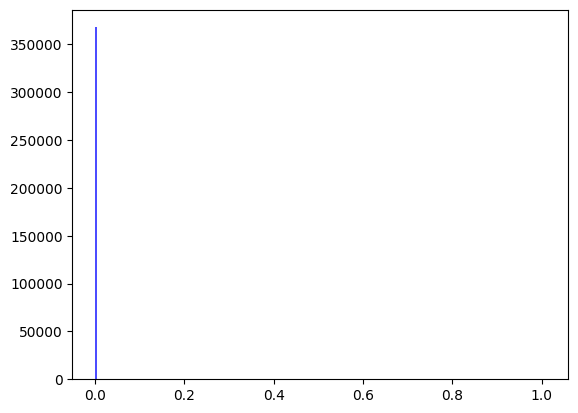

[2023-10-01T20:06:46.694481+00:00] Epochs 78, total loss: 1.14964e+04
[2023-10-01T20:06:46.694856+00:00] Training llk: -7.52233e-01
[2023-10-01T20:06:46.694965+00:00] Testing llk: -9.94619e-01
[2023-10-01T20:06:46.695062+00:00] MAE:0.09846, MRE:0.12719
saving model


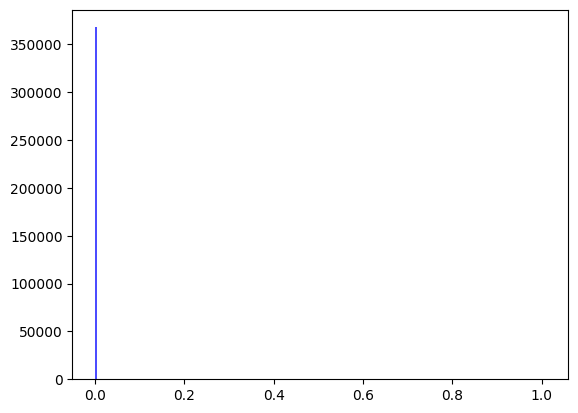

[2023-10-01T20:06:47.710352+00:00] Epochs 79, total loss: 1.13510e+04
[2023-10-01T20:06:47.711526+00:00] Training llk: -7.51742e-01
[2023-10-01T20:06:47.712053+00:00] Testing llk: -9.94193e-01
[2023-10-01T20:06:47.712542+00:00] MAE:0.10052, MRE:0.13036
saving model


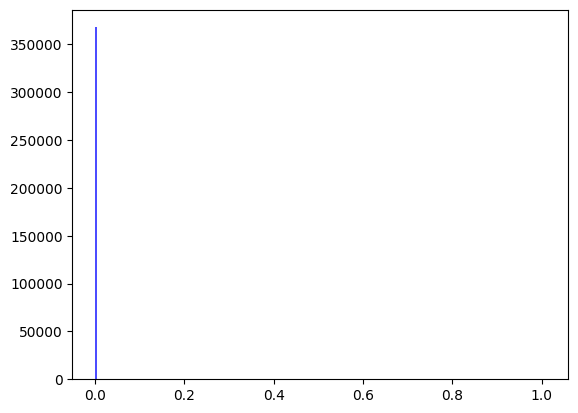

[2023-10-01T20:06:48.716137+00:00] Epochs 80, total loss: 1.16888e+04
[2023-10-01T20:06:48.716411+00:00] Training llk: -7.51707e-01
[2023-10-01T20:06:48.716507+00:00] Testing llk: -9.94156e-01
[2023-10-01T20:06:48.716581+00:00] MAE:0.10068, MRE:0.13067
saving model


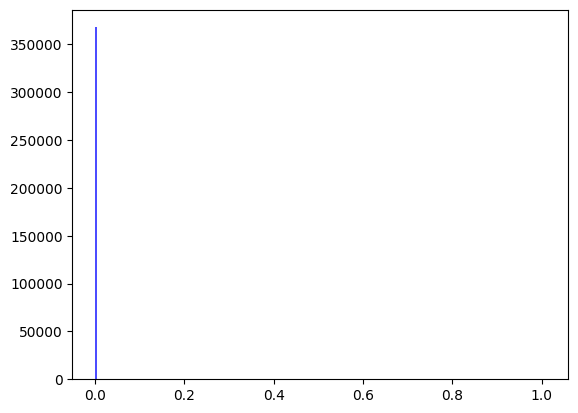

[2023-10-01T20:06:49.962729+00:00] Epochs 81, total loss: 1.21616e+04
[2023-10-01T20:06:49.963071+00:00] Training llk: -7.51653e-01
[2023-10-01T20:06:49.963182+00:00] Testing llk: -9.94137e-01
[2023-10-01T20:06:49.963259+00:00] MAE:0.10099, MRE:0.13092
saving model


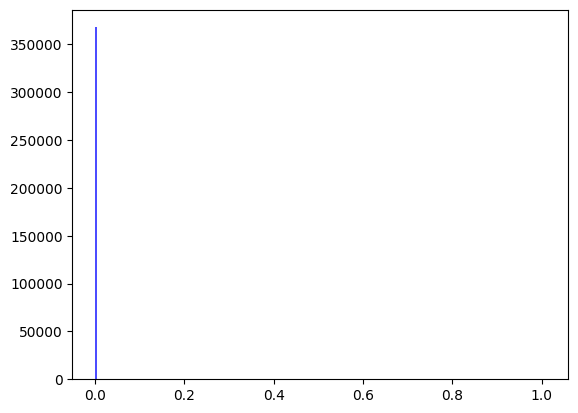

[2023-10-01T20:06:50.938526+00:00] Epochs 82, total loss: 1.26175e+04
[2023-10-01T20:06:50.939489+00:00] Training llk: -7.52774e-01
[2023-10-01T20:06:50.939618+00:00] Testing llk: -9.95134e-01
[2023-10-01T20:06:50.939697+00:00] MAE:0.09664, MRE:0.12429
saving model


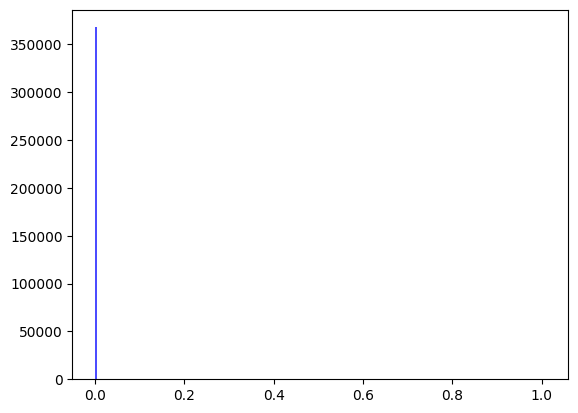

[2023-10-01T20:06:51.939443+00:00] Epochs 83, total loss: 1.13703e+04
[2023-10-01T20:06:51.939692+00:00] Training llk: -7.52236e-01
[2023-10-01T20:06:51.939782+00:00] Testing llk: -9.94625e-01
[2023-10-01T20:06:51.939848+00:00] MAE:0.09845, MRE:0.12715
saving model


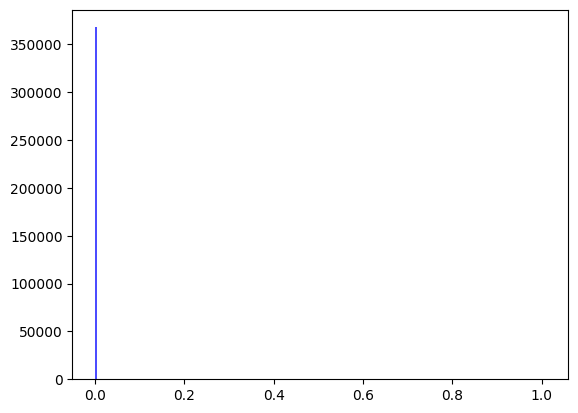

[2023-10-01T20:06:52.911325+00:00] Epochs 84, total loss: 1.10428e+04
[2023-10-01T20:06:52.911595+00:00] Training llk: -7.50821e-01
[2023-10-01T20:06:52.911687+00:00] Testing llk: -9.93955e-01
[2023-10-01T20:06:52.911766+00:00] MAE:0.11143, MRE:0.14609
saving model


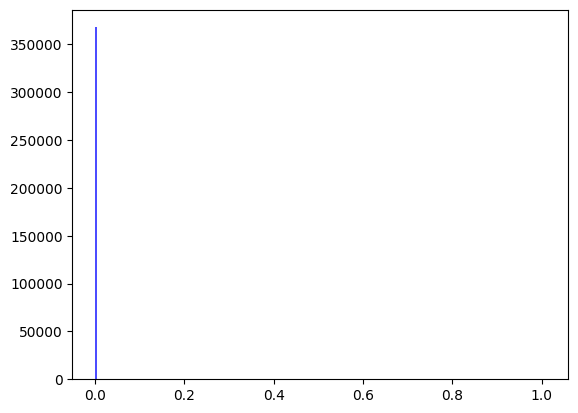

[2023-10-01T20:06:53.868136+00:00] Epochs 85, total loss: 1.19686e+04
[2023-10-01T20:06:53.869224+00:00] Training llk: -7.54913e-01
[2023-10-01T20:06:53.869784+00:00] Testing llk: -9.97284e-01
[2023-10-01T20:06:53.870311+00:00] MAE:0.09150, MRE:0.11639
saving model


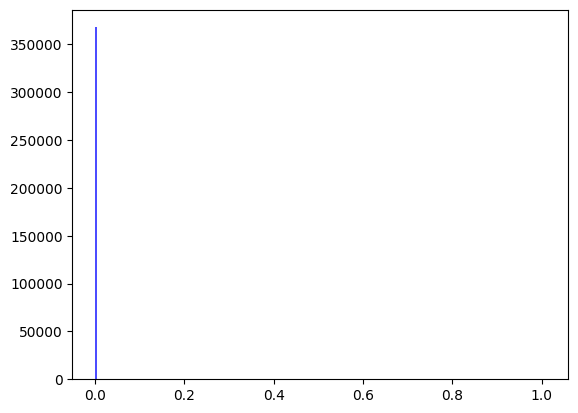

[2023-10-01T20:06:54.868425+00:00] Epochs 86, total loss: 1.21026e+04
[2023-10-01T20:06:54.869193+00:00] Training llk: -7.55409e-01
[2023-10-01T20:06:54.869322+00:00] Testing llk: -9.97813e-01
[2023-10-01T20:06:54.869406+00:00] MAE:0.09058, MRE:0.11489
saving model


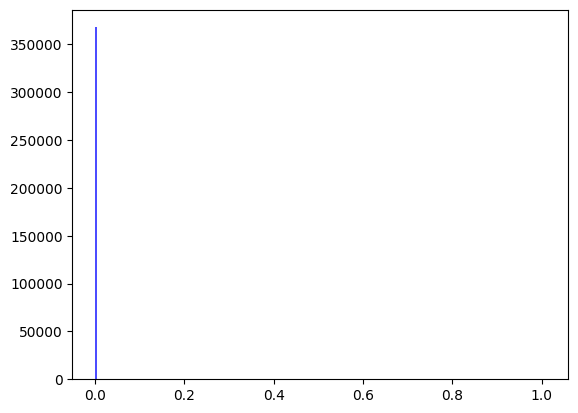

[2023-10-01T20:06:56.654311+00:00] Epochs 87, total loss: 1.14892e+04
[2023-10-01T20:06:56.655479+00:00] Training llk: -7.51321e-01
[2023-10-01T20:06:56.655995+00:00] Testing llk: -9.93856e-01
[2023-10-01T20:06:56.656515+00:00] MAE:0.10285, MRE:0.13403
saving model


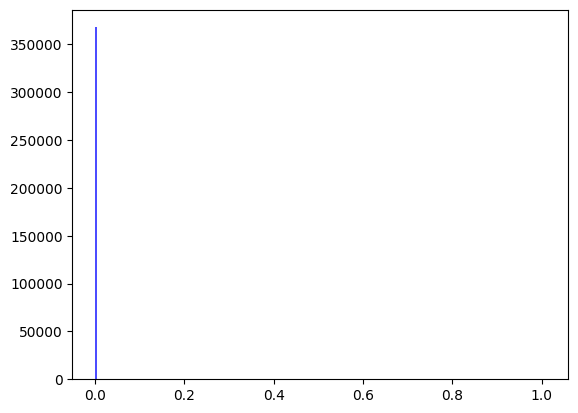

[2023-10-01T20:06:58.072859+00:00] Epochs 88, total loss: 1.14171e+04
[2023-10-01T20:06:58.073169+00:00] Training llk: -7.53488e-01
[2023-10-01T20:06:58.073275+00:00] Testing llk: -9.95797e-01
[2023-10-01T20:06:58.073360+00:00] MAE:0.09463, MRE:0.12151
saving model


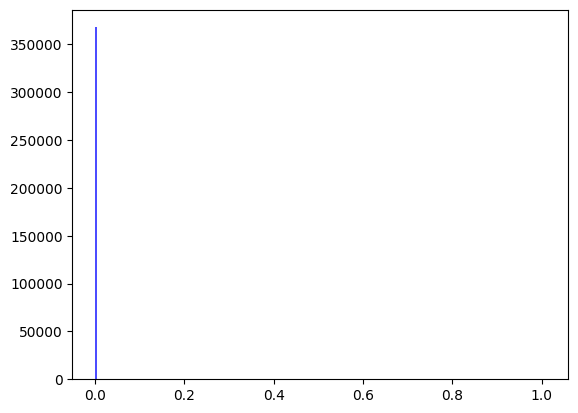

[2023-10-01T20:06:59.093154+00:00] Epochs 89, total loss: 1.09008e+04
[2023-10-01T20:06:59.094500+00:00] Training llk: -7.51791e-01
[2023-10-01T20:06:59.095030+00:00] Testing llk: -9.94206e-01
[2023-10-01T20:06:59.095823+00:00] MAE:0.10025, MRE:0.13020
saving model


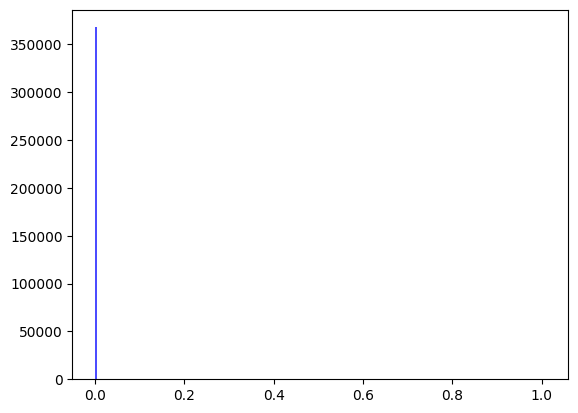

[2023-10-01T20:07:00.078177+00:00] Epochs 90, total loss: 1.09402e+04
[2023-10-01T20:07:00.079449+00:00] Training llk: -7.50808e-01
[2023-10-01T20:07:00.080099+00:00] Testing llk: -9.93892e-01
[2023-10-01T20:07:00.080697+00:00] MAE:0.11096, MRE:0.14556
saving model


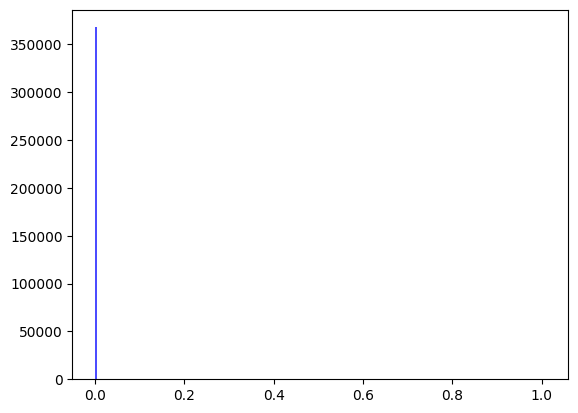

[2023-10-01T20:07:01.082005+00:00] Epochs 91, total loss: 1.25519e+04
[2023-10-01T20:07:01.082269+00:00] Training llk: -7.59581e-01
[2023-10-01T20:07:01.082347+00:00] Testing llk: -1.00241e+00
[2023-10-01T20:07:01.082411+00:00] MAE:0.08468, MRE:0.10512
saving model


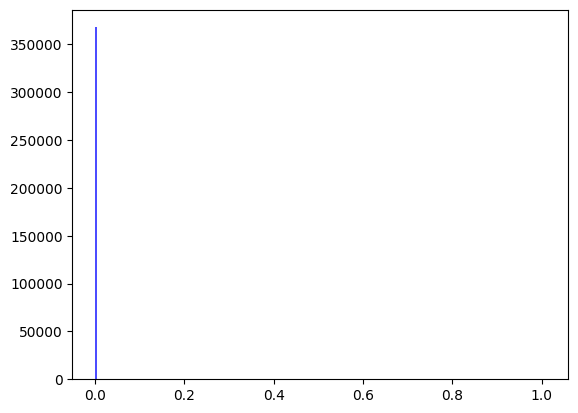

[2023-10-01T20:07:02.063385+00:00] Epochs 92, total loss: 1.14255e+04
[2023-10-01T20:07:02.064503+00:00] Training llk: -7.51909e-01
[2023-10-01T20:07:02.064999+00:00] Testing llk: -9.94326e-01
[2023-10-01T20:07:02.065504+00:00] MAE:0.09975, MRE:0.12924
saving model


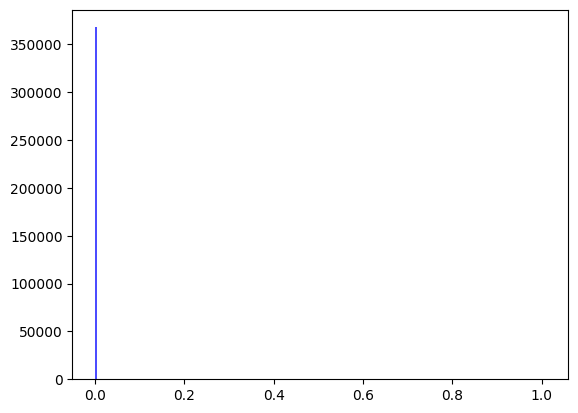

[2023-10-01T20:07:03.397239+00:00] Epochs 93, total loss: 1.34231e+04
[2023-10-01T20:07:03.398155+00:00] Training llk: -7.51531e-01
[2023-10-01T20:07:03.398278+00:00] Testing llk: -9.94039e-01
[2023-10-01T20:07:03.398359+00:00] MAE:0.10164, MRE:0.13192
saving model


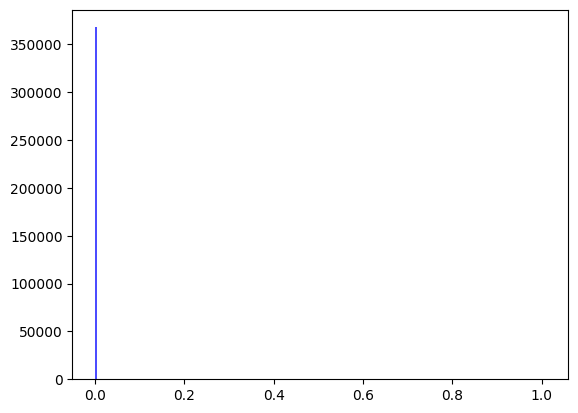

[2023-10-01T20:07:04.356835+00:00] Epochs 94, total loss: 1.24900e+04
[2023-10-01T20:07:04.357787+00:00] Training llk: -7.54982e-01
[2023-10-01T20:07:04.357929+00:00] Testing llk: -9.97373e-01
[2023-10-01T20:07:04.358012+00:00] MAE:0.09137, MRE:0.11604
saving model


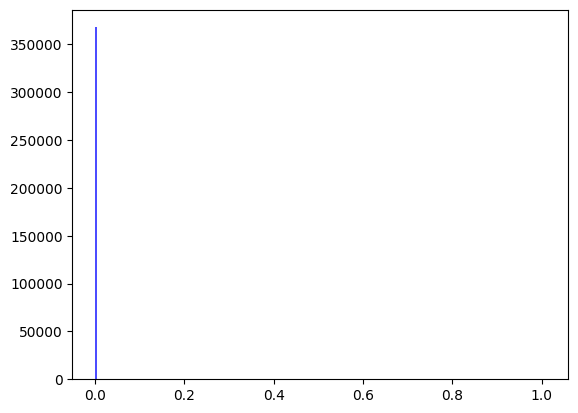

[2023-10-01T20:07:05.325422+00:00] Epochs 95, total loss: 1.22353e+04
[2023-10-01T20:07:05.327405+00:00] Training llk: -7.51639e-01
[2023-10-01T20:07:05.327957+00:00] Testing llk: -9.94115e-01
[2023-10-01T20:07:05.328457+00:00] MAE:0.10104, MRE:0.13110
saving model


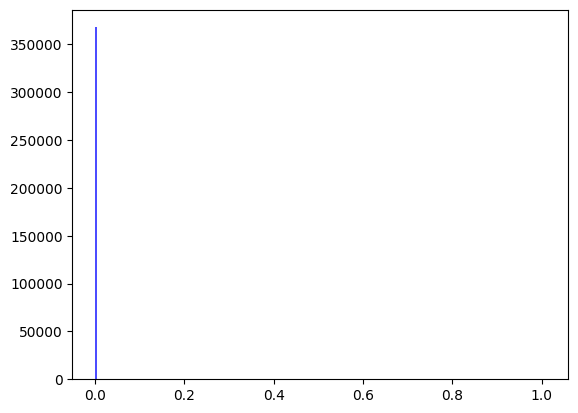

[2023-10-01T20:07:06.269249+00:00] Epochs 96, total loss: 1.14588e+04
[2023-10-01T20:07:06.269514+00:00] Training llk: -7.51263e-01
[2023-10-01T20:07:06.269603+00:00] Testing llk: -9.93831e-01
[2023-10-01T20:07:06.269674+00:00] MAE:0.10329, MRE:0.13456
saving model


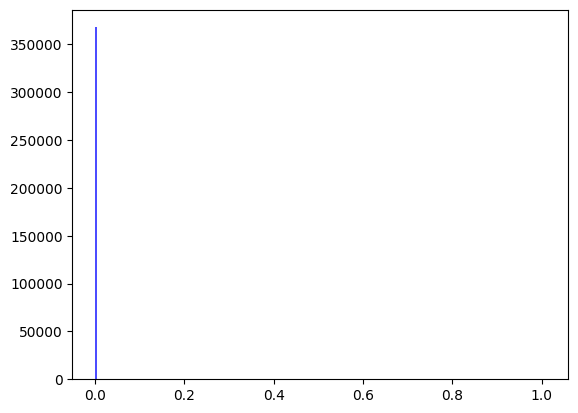

[2023-10-01T20:07:07.247234+00:00] Epochs 97, total loss: 1.11944e+04
[2023-10-01T20:07:07.247482+00:00] Training llk: -7.51983e-01
[2023-10-01T20:07:07.247557+00:00] Testing llk: -9.94350e-01
[2023-10-01T20:07:07.247616+00:00] MAE:0.09939, MRE:0.12908
saving model


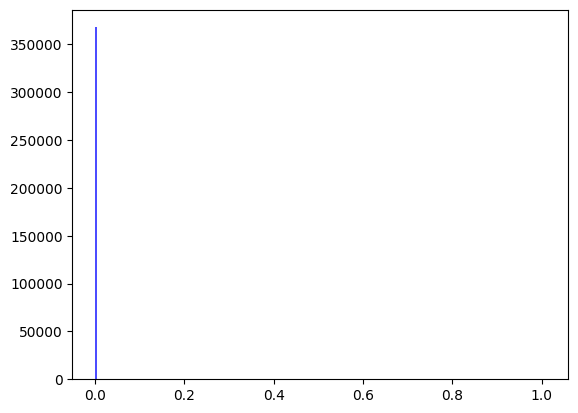

[2023-10-01T20:07:08.437053+00:00] Epochs 98, total loss: 1.18001e+04
[2023-10-01T20:07:08.437318+00:00] Training llk: -7.51635e-01
[2023-10-01T20:07:08.437418+00:00] Testing llk: -9.94047e-01
[2023-10-01T20:07:08.437493+00:00] MAE:0.10096, MRE:0.13158
saving model


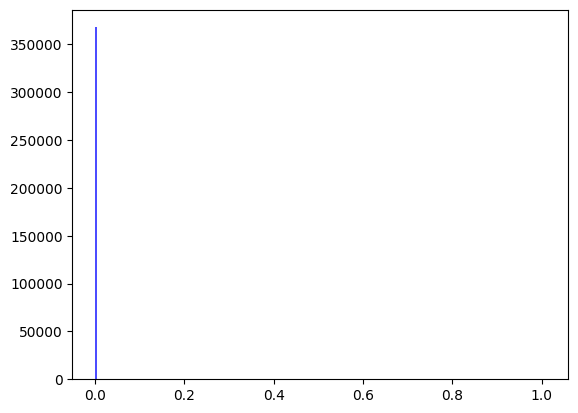

[2023-10-01T20:07:10.254581+00:00] Epochs 99, total loss: 1.04996e+04
[2023-10-01T20:07:10.259676+00:00] Training llk: -7.51685e-01
[2023-10-01T20:07:10.260286+00:00] Testing llk: -9.94072e-01
[2023-10-01T20:07:10.260786+00:00] MAE:0.10069, MRE:0.13133
saving model
training done!


In [ ]:
for Tm in [100.]:
  print(Tm)
  T = [buffer_end_time, Tm]
  tau_max = 10.
  baserate = true_mu
  nsample = 10
  n_class = 1
  int_res = 200
  hid_dim = 64
  batch_size = 16
  train_size = 1000
  lr = 0.2
  epoch = 100
  config = config_generate(T0=str(T[0]),
                          T1=str(T[1]),
                          tau_max=str(tau_max),
                          nsample=str(nsample),
                          int_res=str(int_res),
                          n_class=str(n_class),
                          lr=str(lr),
                          epoch=str(epoch),
                          hid_dim=str(hid_dim),
                          batch_size=str(batch_size))
  config.own_event_embed = False
  config.bptt = 10
  config.alpha = true_alpha

  train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
  train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
  for i in range(train_data.shape[0]):
      seq = raw_train_data[i]
      train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

  train_data_ = generate_event_mark(train_data)

  # seeds = [300, 816, 2999]
  # seeds = [1000, 2000, 3000]
  seeds = [0]

  for seed in seeds:
      # torch.random.manual_seed(seed)
      random.seed(seed)

      train_idx = np.arange(train_data_.shape[0])
      # random.shuffle(train_idx)
      train_data2 = train_data_[train_idx[:train_size]]
      buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

      rmtpp_model = RMTPP_new(config, device)
      num_paras = count_parameters(rmtpp_model)
      print("#parameters: %d" % num_paras)

      for name, parameter in rmtpp_model.named_parameters():
          if name == "baserate_mu":
              # parameter.data.fill_(random.uniform(0.4, 0.5))
              parameter.data.fill_(baserate)
          else:
              parameter.data.fill_(random.gauss(0, 0.01))

      ts = np.linspace(test_time[0], test_time[1], ngrid)
      true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)


      rmtpp_model, train_llks, test_llks, test_maes, test_mres, wall_time = model_train(train_data2,
                                                                                      test_data_,
                                                                                      buffer_train_data2,
                                                                                      buffer_test_data_,
                                                                                      rmtpp_model,
                                                                                      config,
                                                                                      device,
                                                                                      True, ts, true_lams)


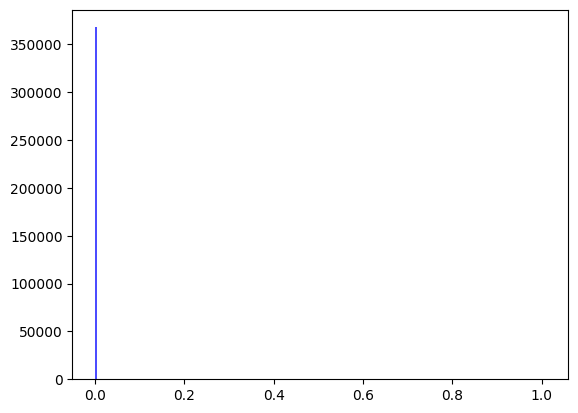

Text(0.5, 1.0, 'Conditional Intensity')

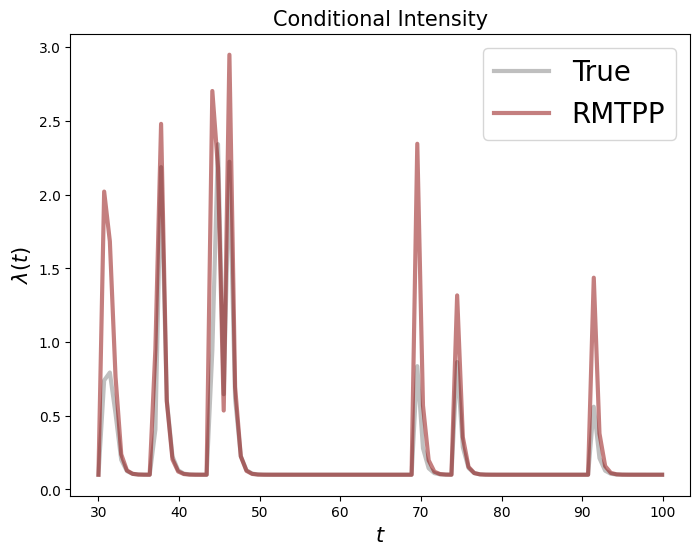

In [ ]:
ts = np.linspace(test_time[0], test_time[1], ngrid)

rmtpp_lams = rmtpp_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 0
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, rmtpp_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="RMTPP")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

In [ ]:
# Third data set

true_mu = 0.1
true_alpha = 1.0
true_beta = 5.0
raw_train_data = np.load('sample_data/training_3_0911.npy', allow_pickle = True)
raw_test_data = np.load('sample_data/testing_3_0911.npy', allow_pickle = True)

buffer_start_time = 15
buffer_end_time = 30
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)

print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 100

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())


(50, 32, 2)
(200, 20, 2)
(50, 23, 2)
(50, 32, 2) (200, 20, 2) (50, 23, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2


100.0
(200, 40, 2)
#parameters: 4485
[2023-10-01T20:15:42.275167+00:00] #Training sequences: 200
[2023-10-01T20:15:42.275390+00:00] #Testing sequences: 50
[2023-10-01T20:15:42.275474+00:00] #Training events: 2273
[2023-10-01T20:15:42.275543+00:00] #Testing events: 575


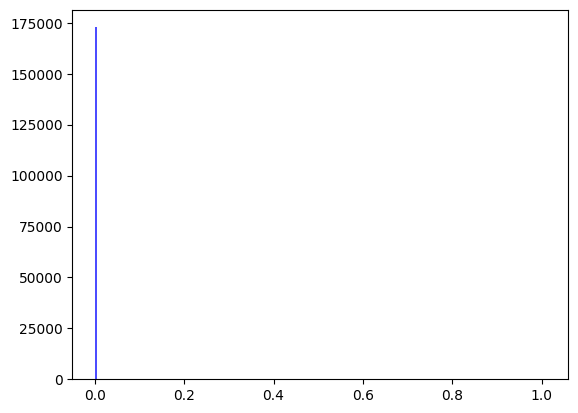

[2023-10-01T20:15:43.226600+00:00] Epochs 0, total loss: 1.31884e+04
[2023-10-01T20:15:43.227195+00:00] Training llk: -1.66795e+00
[2023-10-01T20:15:43.227312+00:00] Testing llk: -2.14392e+00
[2023-10-01T20:15:43.227394+00:00] MAE:0.03263, MRE:0.17383
saving model


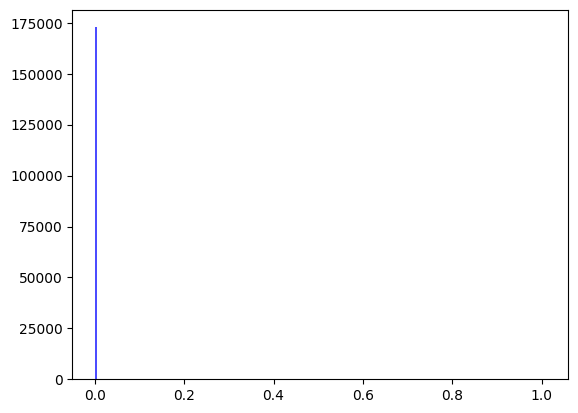

[2023-10-01T20:15:44.389559+00:00] Epochs 1, total loss: 1.06701e+04
[2023-10-01T20:15:44.390732+00:00] Training llk: -1.60267e+00
[2023-10-01T20:15:44.391284+00:00] Testing llk: -2.05742e+00
[2023-10-01T20:15:44.391773+00:00] MAE:0.03070, MRE:0.16994
saving model


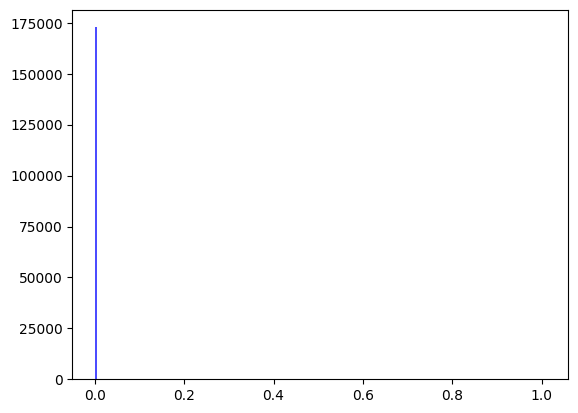

[2023-10-01T20:15:45.719604+00:00] Epochs 2, total loss: 9.39242e+03
[2023-10-01T20:15:45.721380+00:00] Training llk: -1.50983e+00
[2023-10-01T20:15:45.721937+00:00] Testing llk: -1.93353e+00
[2023-10-01T20:15:45.722452+00:00] MAE:0.04671, MRE:0.29262
saving model


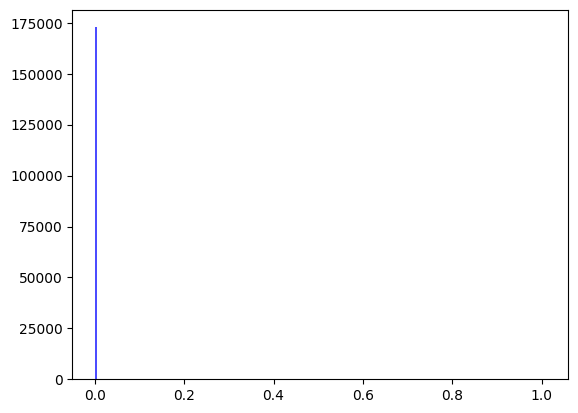

[2023-10-01T20:15:46.953637+00:00] Epochs 3, total loss: 9.00218e+03
[2023-10-01T20:15:46.954460+00:00] Training llk: -1.50505e+00
[2023-10-01T20:15:46.954782+00:00] Testing llk: -1.92365e+00
[2023-10-01T20:15:46.955181+00:00] MAE:0.08655, MRE:0.49691
saving model


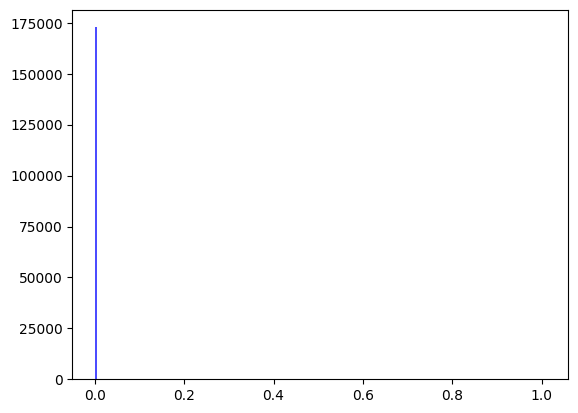

[2023-10-01T20:15:48.221253+00:00] Epochs 4, total loss: 8.98278e+03
[2023-10-01T20:15:48.222158+00:00] Training llk: -1.51142e+00
[2023-10-01T20:15:48.222494+00:00] Testing llk: -1.93088e+00
[2023-10-01T20:15:48.222781+00:00] MAE:0.09709, MRE:0.53748
saving model


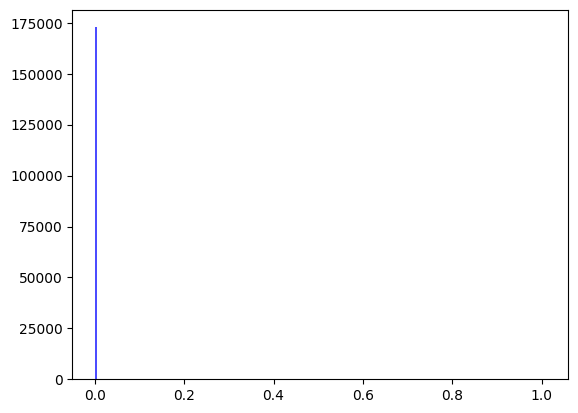

[2023-10-01T20:15:49.162411+00:00] Epochs 5, total loss: 9.83075e+03
[2023-10-01T20:15:49.163391+00:00] Training llk: -1.48817e+00
[2023-10-01T20:15:49.163761+00:00] Testing llk: -1.90149e+00
[2023-10-01T20:15:49.164157+00:00] MAE:0.08142, MRE:0.45201
saving model


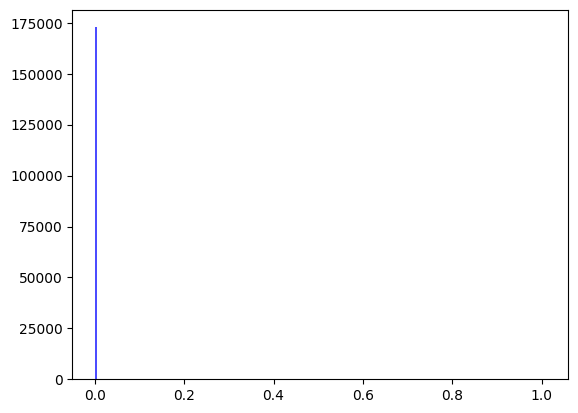

[2023-10-01T20:15:50.115440+00:00] Epochs 6, total loss: 1.03045e+04
[2023-10-01T20:15:50.115697+00:00] Training llk: -1.47665e+00
[2023-10-01T20:15:50.115795+00:00] Testing llk: -1.88686e+00
[2023-10-01T20:15:50.115874+00:00] MAE:0.07368, MRE:0.40602
saving model


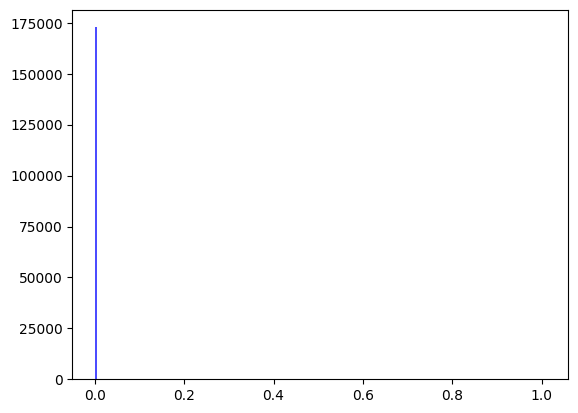

[2023-10-01T20:15:51.017341+00:00] Epochs 7, total loss: 9.97392e+03
[2023-10-01T20:15:51.017573+00:00] Training llk: -1.47217e+00
[2023-10-01T20:15:51.017676+00:00] Testing llk: -1.88063e+00
[2023-10-01T20:15:51.017759+00:00] MAE:0.07573, MRE:0.40665
saving model


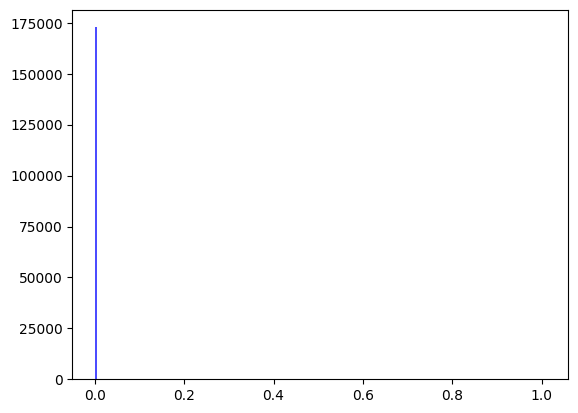

[2023-10-01T20:15:51.933736+00:00] Epochs 8, total loss: 9.23588e+03
[2023-10-01T20:15:51.934585+00:00] Training llk: -1.47101e+00
[2023-10-01T20:15:51.934911+00:00] Testing llk: -1.87849e+00
[2023-10-01T20:15:51.935238+00:00] MAE:0.08110, MRE:0.42205
saving model


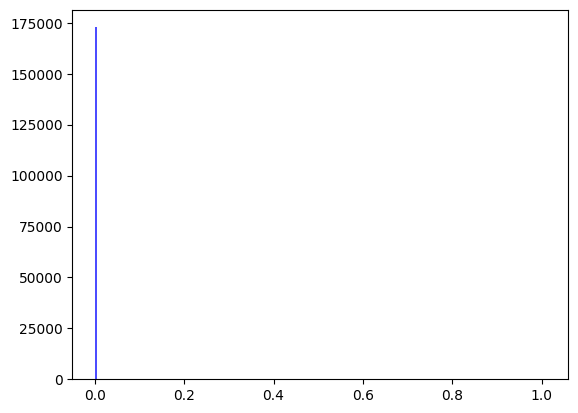

[2023-10-01T20:15:52.828731+00:00] Epochs 9, total loss: 9.49590e+03
[2023-10-01T20:15:52.828980+00:00] Training llk: -1.46534e+00
[2023-10-01T20:15:52.829102+00:00] Testing llk: -1.87097e+00
[2023-10-01T20:15:52.829189+00:00] MAE:0.08046, MRE:0.41032
saving model


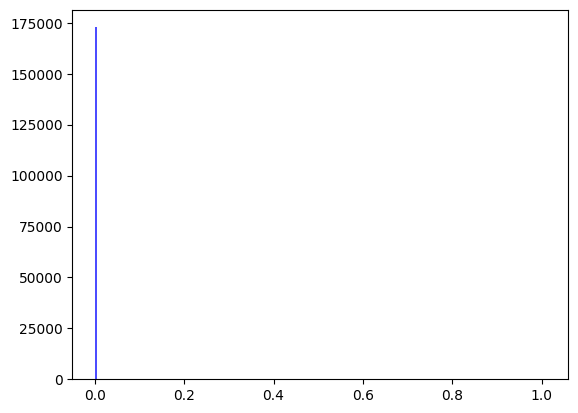

[2023-10-01T20:15:53.996204+00:00] Epochs 10, total loss: 8.66775e+03
[2023-10-01T20:15:53.997129+00:00] Training llk: -1.45962e+00
[2023-10-01T20:15:53.997461+00:00] Testing llk: -1.86347e+00
[2023-10-01T20:15:53.997756+00:00] MAE:0.07917, MRE:0.39661
saving model


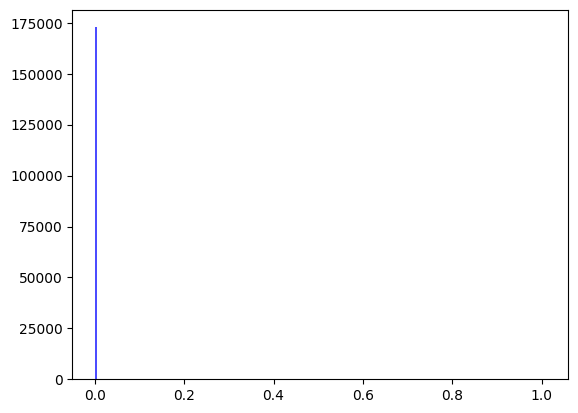

[2023-10-01T20:15:54.936414+00:00] Epochs 11, total loss: 8.91700e+03
[2023-10-01T20:15:54.937242+00:00] Training llk: -1.45544e+00
[2023-10-01T20:15:54.937351+00:00] Testing llk: -1.85788e+00
[2023-10-01T20:15:54.937438+00:00] MAE:0.07938, MRE:0.38975
saving model


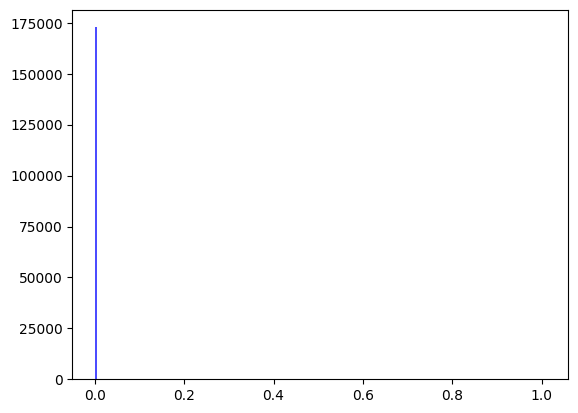

[2023-10-01T20:15:55.858207+00:00] Epochs 12, total loss: 1.00754e+04
[2023-10-01T20:15:55.859058+00:00] Training llk: -1.44970e+00
[2023-10-01T20:15:55.859435+00:00] Testing llk: -1.85042e+00
[2023-10-01T20:15:55.859724+00:00] MAE:0.07777, MRE:0.37516
saving model


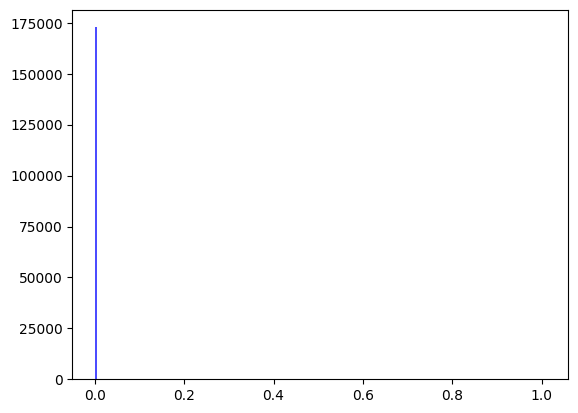

[2023-10-01T20:15:56.872657+00:00] Epochs 13, total loss: 8.03911e+03
[2023-10-01T20:15:56.872934+00:00] Training llk: -1.44715e+00
[2023-10-01T20:15:56.873049+00:00] Testing llk: -1.84683e+00
[2023-10-01T20:15:56.873123+00:00] MAE:0.07980, MRE:0.37565
saving model


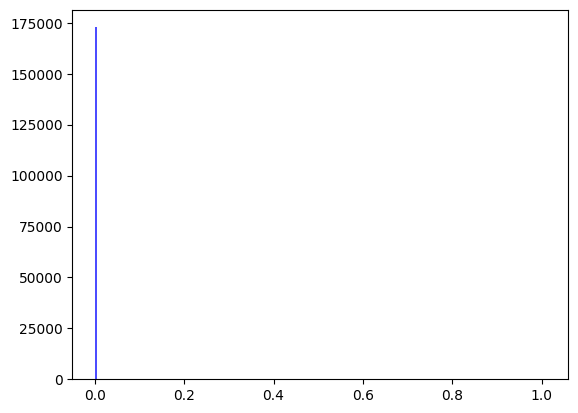

[2023-10-01T20:15:58.273150+00:00] Epochs 14, total loss: 8.66730e+03
[2023-10-01T20:15:58.274313+00:00] Training llk: -1.44565e+00
[2023-10-01T20:15:58.274844+00:00] Testing llk: -1.84459e+00
[2023-10-01T20:15:58.275353+00:00] MAE:0.08224, MRE:0.37824
saving model


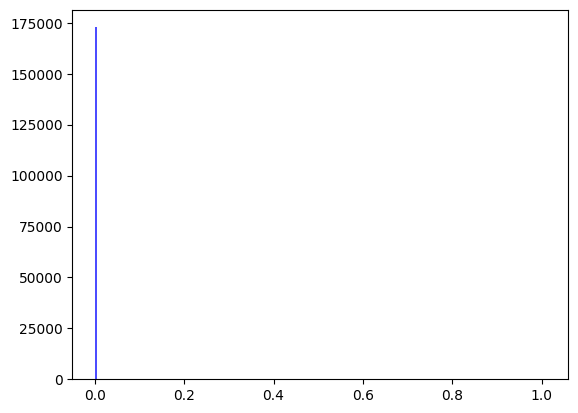

[2023-10-01T20:15:59.629366+00:00] Epochs 15, total loss: 9.12783e+03
[2023-10-01T20:15:59.629596+00:00] Training llk: -1.43664e+00
[2023-10-01T20:15:59.629695+00:00] Testing llk: -1.83335e+00
[2023-10-01T20:15:59.629782+00:00] MAE:0.07567, MRE:0.34601
saving model


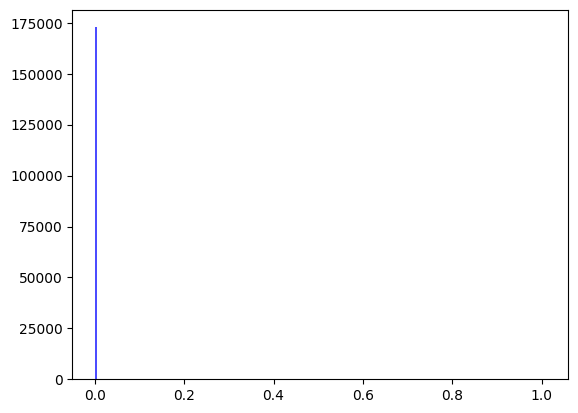

[2023-10-01T20:16:00.879857+00:00] Epochs 16, total loss: 8.80816e+03
[2023-10-01T20:16:00.880098+00:00] Training llk: -1.43352e+00
[2023-10-01T20:16:00.880187+00:00] Testing llk: -1.82921e+00
[2023-10-01T20:16:00.880269+00:00] MAE:0.07611, MRE:0.34135
saving model


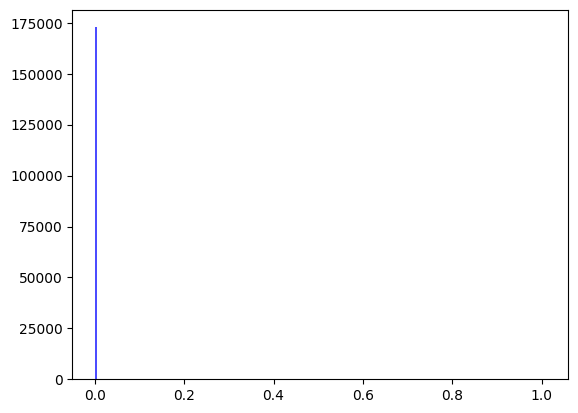

[2023-10-01T20:16:01.846371+00:00] Epochs 17, total loss: 8.86024e+03
[2023-10-01T20:16:01.847668+00:00] Training llk: -1.43246e+00
[2023-10-01T20:16:01.848059+00:00] Testing llk: -1.82755e+00
[2023-10-01T20:16:01.848355+00:00] MAE:0.07896, MRE:0.34570
saving model


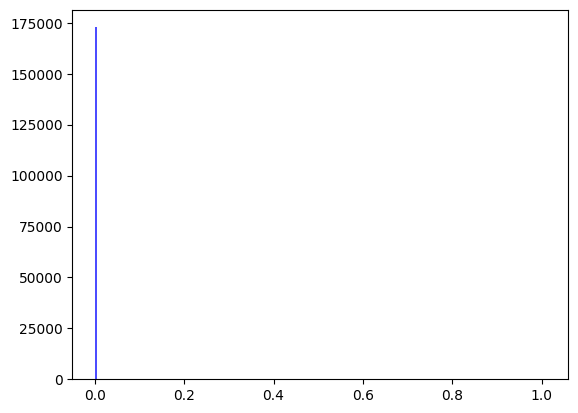

[2023-10-01T20:16:02.788522+00:00] Epochs 18, total loss: 9.35703e+03
[2023-10-01T20:16:02.789363+00:00] Training llk: -1.42761e+00
[2023-10-01T20:16:02.789685+00:00] Testing llk: -1.82138e+00
[2023-10-01T20:16:02.789983+00:00] MAE:0.07702, MRE:0.33217
saving model


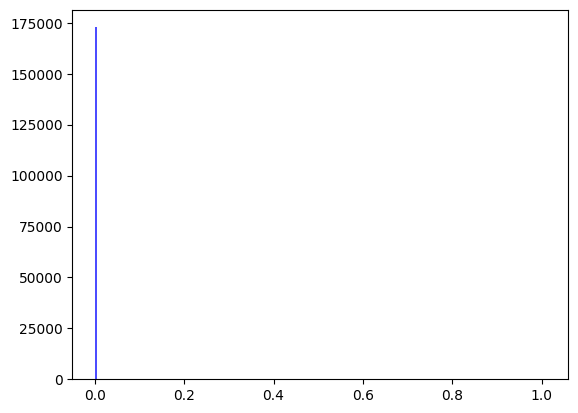

[2023-10-01T20:16:03.698549+00:00] Epochs 19, total loss: 9.12867e+03
[2023-10-01T20:16:03.698805+00:00] Training llk: -1.42453e+00
[2023-10-01T20:16:03.698910+00:00] Testing llk: -1.81738e+00
[2023-10-01T20:16:03.698990+00:00] MAE:0.07693, MRE:0.32598
saving model


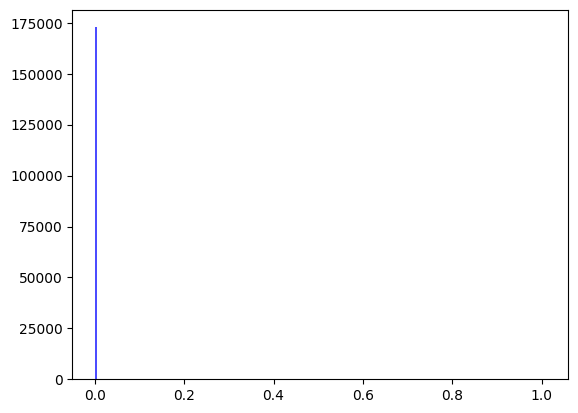

[2023-10-01T20:16:04.618423+00:00] Epochs 20, total loss: 9.42557e+03
[2023-10-01T20:16:04.618645+00:00] Training llk: -1.42011e+00
[2023-10-01T20:16:04.618732+00:00] Testing llk: -1.81181e+00
[2023-10-01T20:16:04.618808+00:00] MAE:0.07489, MRE:0.31305
saving model


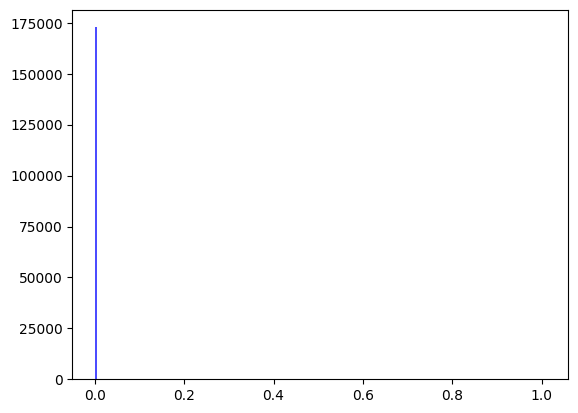

[2023-10-01T20:16:05.507253+00:00] Epochs 21, total loss: 8.84253e+03
[2023-10-01T20:16:05.507474+00:00] Training llk: -1.41874e+00
[2023-10-01T20:16:05.507556+00:00] Testing llk: -1.80988e+00
[2023-10-01T20:16:05.507629+00:00] MAE:0.07668, MRE:0.31393
saving model


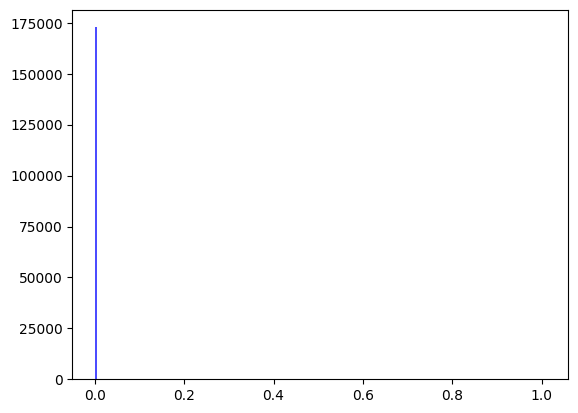

[2023-10-01T20:16:06.711839+00:00] Epochs 22, total loss: 8.94201e+03
[2023-10-01T20:16:06.712072+00:00] Training llk: -1.41576e+00
[2023-10-01T20:16:06.712157+00:00] Testing llk: -1.80607e+00
[2023-10-01T20:16:06.712237+00:00] MAE:0.07621, MRE:0.30700
saving model


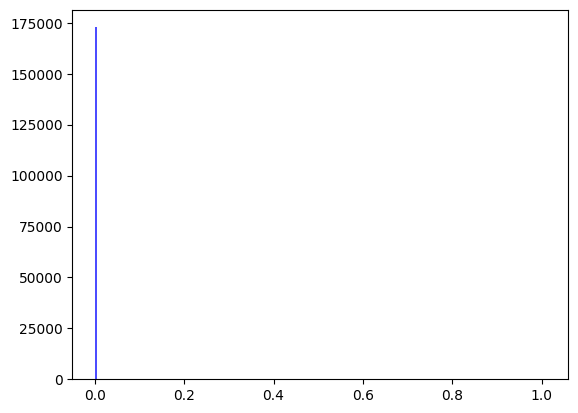

[2023-10-01T20:16:07.646533+00:00] Epochs 23, total loss: 9.25795e+03
[2023-10-01T20:16:07.646766+00:00] Training llk: -1.41405e+00
[2023-10-01T20:16:07.646858+00:00] Testing llk: -1.80381e+00
[2023-10-01T20:16:07.646931+00:00] MAE:0.07713, MRE:0.30511
saving model


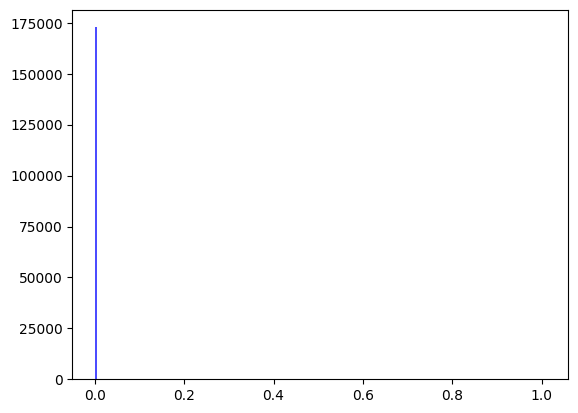

[2023-10-01T20:16:08.518907+00:00] Epochs 24, total loss: 8.29042e+03
[2023-10-01T20:16:08.519176+00:00] Training llk: -1.41107e+00
[2023-10-01T20:16:08.519279+00:00] Testing llk: -1.80005e+00
[2023-10-01T20:16:08.519359+00:00] MAE:0.07615, MRE:0.29724
saving model


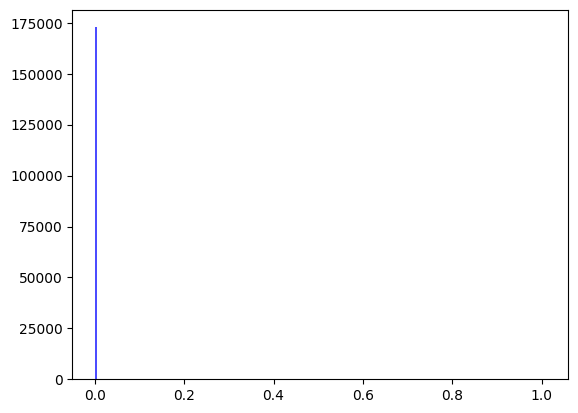

[2023-10-01T20:16:09.398451+00:00] Epochs 25, total loss: 8.71259e+03
[2023-10-01T20:16:09.398671+00:00] Training llk: -1.40796e+00
[2023-10-01T20:16:09.398767+00:00] Testing llk: -1.79617e+00
[2023-10-01T20:16:09.398837+00:00] MAE:0.07483, MRE:0.28848
saving model


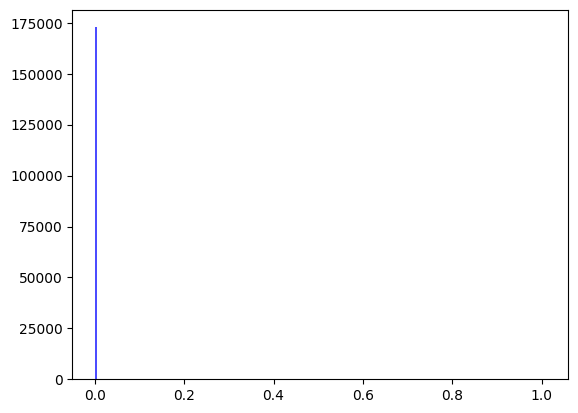

[2023-10-01T20:16:10.735794+00:00] Epochs 26, total loss: 8.31847e+03
[2023-10-01T20:16:10.737001+00:00] Training llk: -1.40680e+00
[2023-10-01T20:16:10.737584+00:00] Testing llk: -1.79462e+00
[2023-10-01T20:16:10.738169+00:00] MAE:0.07588, MRE:0.28779
saving model


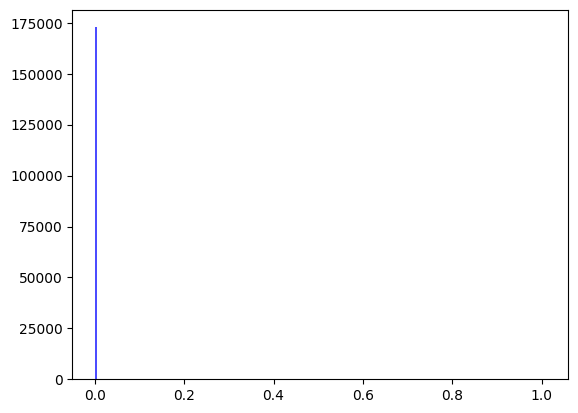

[2023-10-01T20:16:12.375285+00:00] Epochs 27, total loss: 9.16797e+03
[2023-10-01T20:16:12.375540+00:00] Training llk: -1.40201e+00
[2023-10-01T20:16:12.376861+00:00] Testing llk: -1.78882e+00
[2023-10-01T20:16:12.377005+00:00] MAE:0.07168, MRE:0.27041
saving model


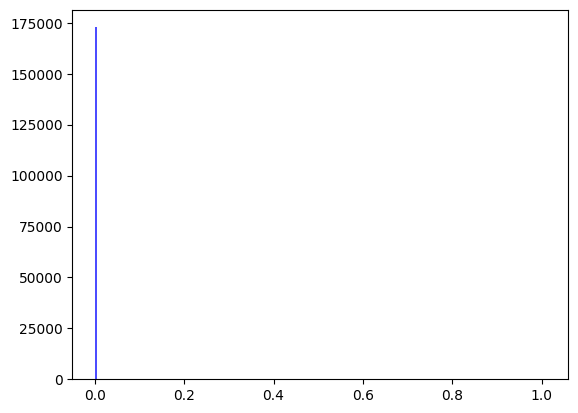

[2023-10-01T20:16:13.279608+00:00] Epochs 28, total loss: 8.37277e+03
[2023-10-01T20:16:13.280439+00:00] Training llk: -1.40552e+00
[2023-10-01T20:16:13.280759+00:00] Testing llk: -1.79282e+00
[2023-10-01T20:16:13.281076+00:00] MAE:0.07887, MRE:0.28908
saving model


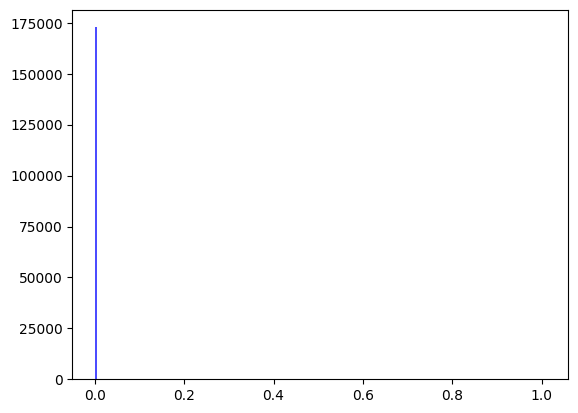

[2023-10-01T20:16:14.172488+00:00] Epochs 29, total loss: 8.20872e+03
[2023-10-01T20:16:14.172708+00:00] Training llk: -1.40166e+00
[2023-10-01T20:16:14.172806+00:00] Testing llk: -1.78808e+00
[2023-10-01T20:16:14.172884+00:00] MAE:0.07628, MRE:0.27720
saving model


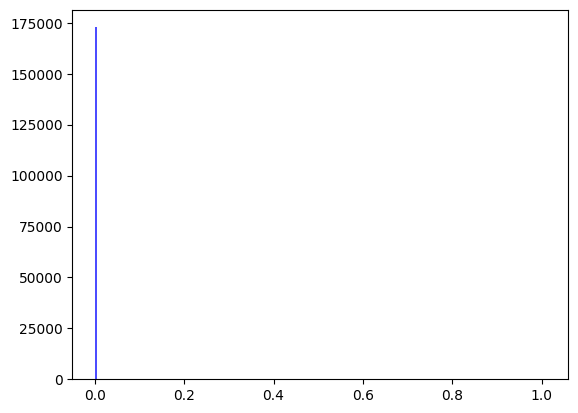

[2023-10-01T20:16:15.042876+00:00] Epochs 30, total loss: 8.67793e+03
[2023-10-01T20:16:15.043904+00:00] Training llk: -1.39885e+00
[2023-10-01T20:16:15.044497+00:00] Testing llk: -1.78463e+00
[2023-10-01T20:16:15.044602+00:00] MAE:0.07477, MRE:0.26888
saving model


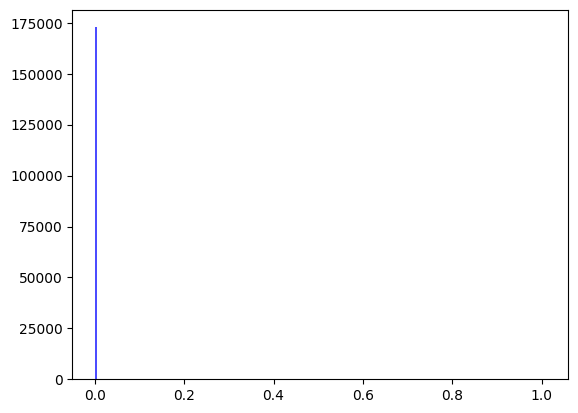

[2023-10-01T20:16:15.963212+00:00] Epochs 31, total loss: 8.98819e+03
[2023-10-01T20:16:15.963441+00:00] Training llk: -1.39503e+00
[2023-10-01T20:16:15.963544+00:00] Testing llk: -1.78002e+00
[2023-10-01T20:16:15.963626+00:00] MAE:0.07152, MRE:0.25550
saving model


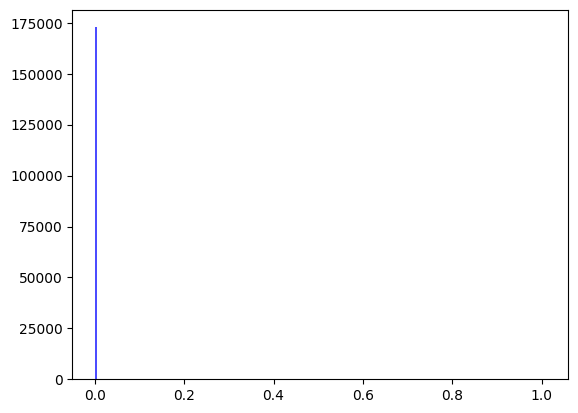

[2023-10-01T20:16:16.894912+00:00] Epochs 32, total loss: 8.31010e+03
[2023-10-01T20:16:16.895156+00:00] Training llk: -1.39794e+00
[2023-10-01T20:16:16.895247+00:00] Testing llk: -1.78336e+00
[2023-10-01T20:16:16.895317+00:00] MAE:0.07756, MRE:0.27022
saving model


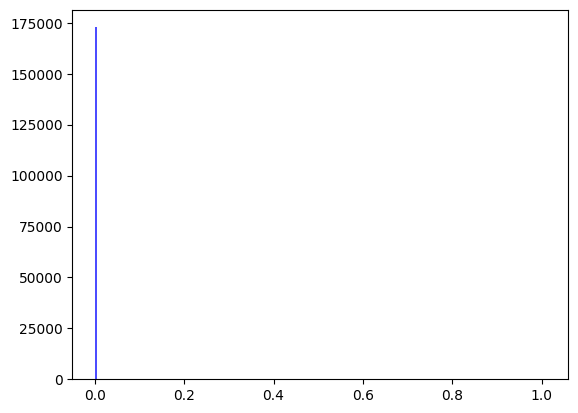

[2023-10-01T20:16:18.153822+00:00] Epochs 33, total loss: 8.36196e+03
[2023-10-01T20:16:18.154994+00:00] Training llk: -1.39489e+00
[2023-10-01T20:16:18.155555+00:00] Testing llk: -1.77964e+00
[2023-10-01T20:16:18.156105+00:00] MAE:0.07549, MRE:0.26086
saving model


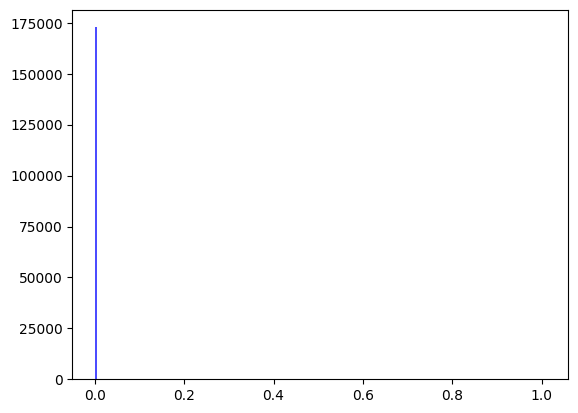

[2023-10-01T20:16:19.140863+00:00] Epochs 34, total loss: 7.66287e+03
[2023-10-01T20:16:19.141707+00:00] Training llk: -1.39205e+00
[2023-10-01T20:16:19.142045+00:00] Testing llk: -1.77621e+00
[2023-10-01T20:16:19.142379+00:00] MAE:0.07332, MRE:0.25163
saving model


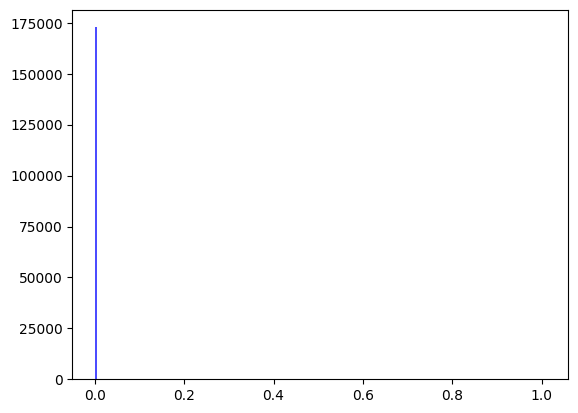

[2023-10-01T20:16:20.068634+00:00] Epochs 35, total loss: 7.81650e+03
[2023-10-01T20:16:20.068916+00:00] Training llk: -1.39239e+00
[2023-10-01T20:16:20.070214+00:00] Testing llk: -1.77655e+00
[2023-10-01T20:16:20.070821+00:00] MAE:0.07539, MRE:0.25492
saving model


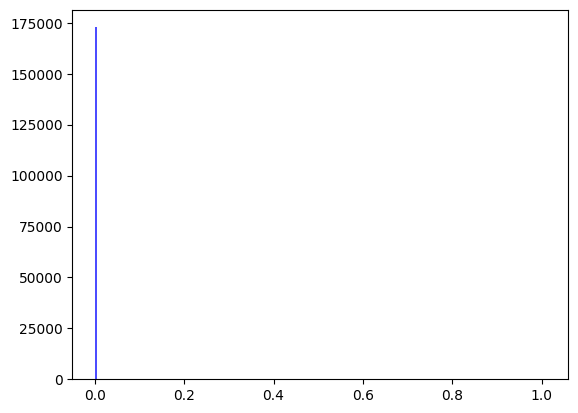

[2023-10-01T20:16:21.046803+00:00] Epochs 36, total loss: 8.47794e+03
[2023-10-01T20:16:21.047092+00:00] Training llk: -1.39051e+00
[2023-10-01T20:16:21.047197+00:00] Testing llk: -1.77425e+00
[2023-10-01T20:16:21.047311+00:00] MAE:0.07444, MRE:0.24941
saving model


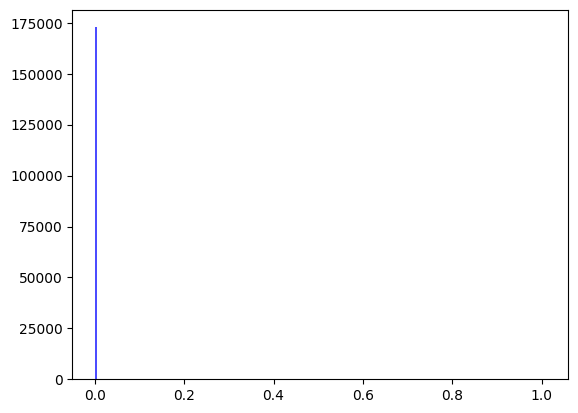

[2023-10-01T20:16:22.057135+00:00] Epochs 37, total loss: 8.85036e+03
[2023-10-01T20:16:22.057833+00:00] Training llk: -1.38756e+00
[2023-10-01T20:16:22.058005+00:00] Testing llk: -1.77073e+00
[2023-10-01T20:16:22.058100+00:00] MAE:0.07188, MRE:0.23939
saving model


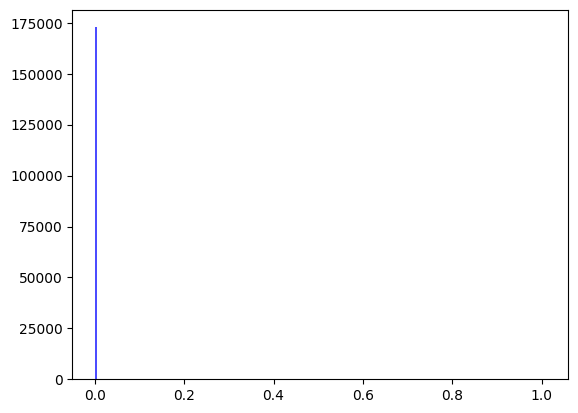

[2023-10-01T20:16:23.434668+00:00] Epochs 38, total loss: 8.67862e+03
[2023-10-01T20:16:23.436160+00:00] Training llk: -1.38901e+00
[2023-10-01T20:16:23.437689+00:00] Testing llk: -1.77238e+00
[2023-10-01T20:16:23.438950+00:00] MAE:0.07551, MRE:0.24688
saving model


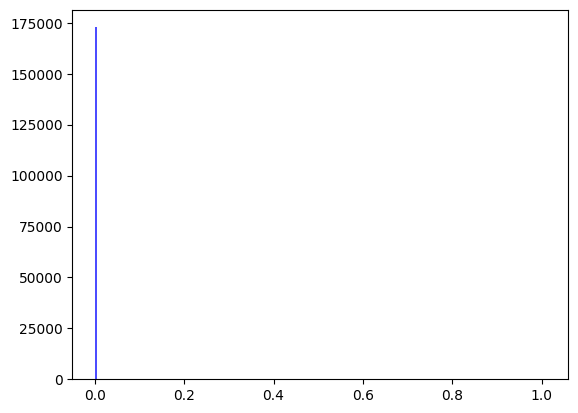

[2023-10-01T20:16:25.121138+00:00] Epochs 39, total loss: 8.23577e+03
[2023-10-01T20:16:25.121370+00:00] Training llk: -1.38783e+00
[2023-10-01T20:16:25.121461+00:00] Testing llk: -1.77094e+00
[2023-10-01T20:16:25.121539+00:00] MAE:0.07534, MRE:0.24382
saving model


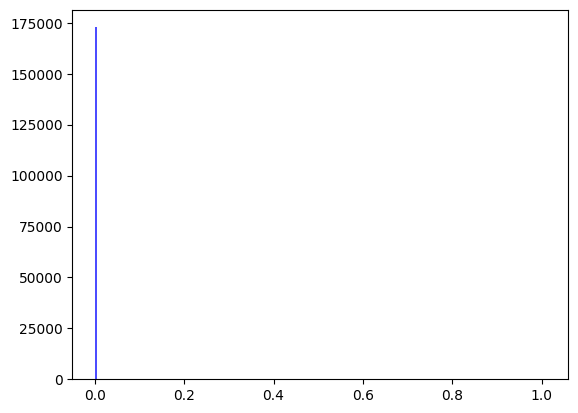

[2023-10-01T20:16:26.126178+00:00] Epochs 40, total loss: 9.03899e+03
[2023-10-01T20:16:26.126407+00:00] Training llk: -1.38501e+00
[2023-10-01T20:16:26.126499+00:00] Testing llk: -1.76756e+00
[2023-10-01T20:16:26.126577+00:00] MAE:0.07292, MRE:0.23458
saving model


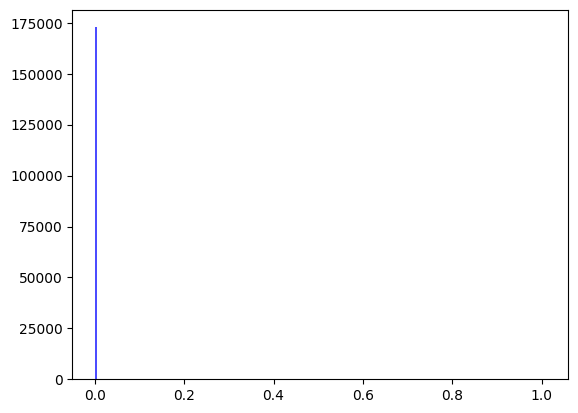

[2023-10-01T20:16:27.043628+00:00] Epochs 41, total loss: 9.09862e+03
[2023-10-01T20:16:27.043852+00:00] Training llk: -1.38135e+00
[2023-10-01T20:16:27.043962+00:00] Testing llk: -1.76326e+00
[2023-10-01T20:16:27.044057+00:00] MAE:0.06858, MRE:0.22026
saving model


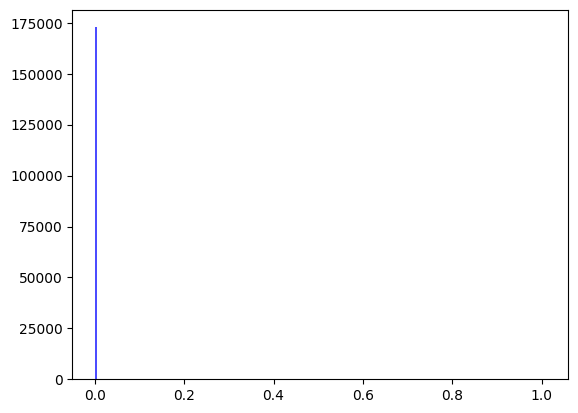

[2023-10-01T20:16:27.953288+00:00] Epochs 42, total loss: 7.79733e+03
[2023-10-01T20:16:27.953578+00:00] Training llk: -1.38876e+00
[2023-10-01T20:16:27.953675+00:00] Testing llk: -1.77203e+00
[2023-10-01T20:16:27.953746+00:00] MAE:0.07982, MRE:0.24849
saving model


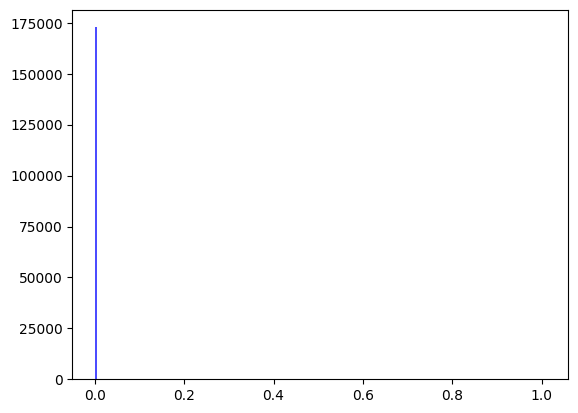

[2023-10-01T20:16:28.860161+00:00] Epochs 43, total loss: 8.77256e+03
[2023-10-01T20:16:28.861087+00:00] Training llk: -1.37901e+00
[2023-10-01T20:16:28.861218+00:00] Testing llk: -1.76047e+00
[2023-10-01T20:16:28.861392+00:00] MAE:0.06759, MRE:0.21327
saving model


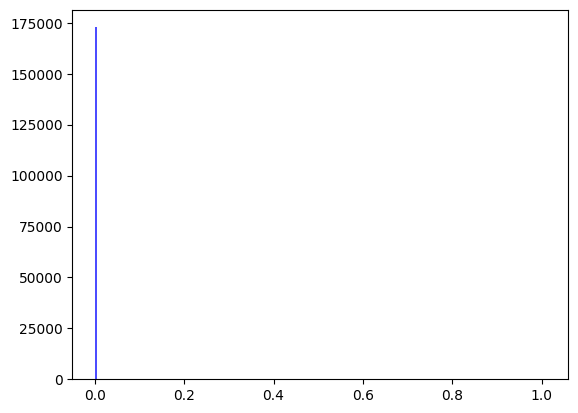

[2023-10-01T20:16:29.753712+00:00] Epochs 44, total loss: 8.13608e+03
[2023-10-01T20:16:29.753954+00:00] Training llk: -1.38280e+00
[2023-10-01T20:16:29.754058+00:00] Testing llk: -1.76486e+00
[2023-10-01T20:16:29.754132+00:00] MAE:0.07490, MRE:0.23067
saving model


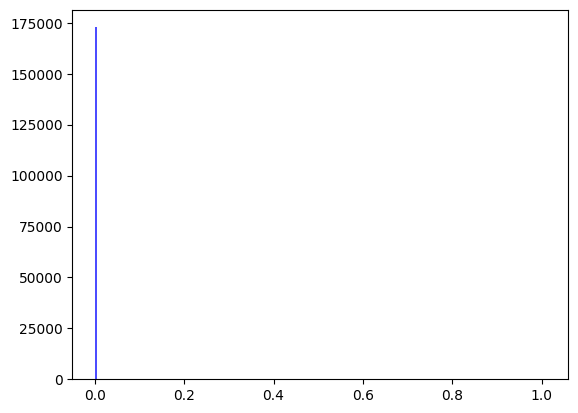

[2023-10-01T20:16:30.941808+00:00] Epochs 45, total loss: 8.25801e+03
[2023-10-01T20:16:30.942136+00:00] Training llk: -1.38124e+00
[2023-10-01T20:16:30.942225+00:00] Testing llk: -1.76299e+00
[2023-10-01T20:16:30.942327+00:00] MAE:0.07389, MRE:0.22590
saving model


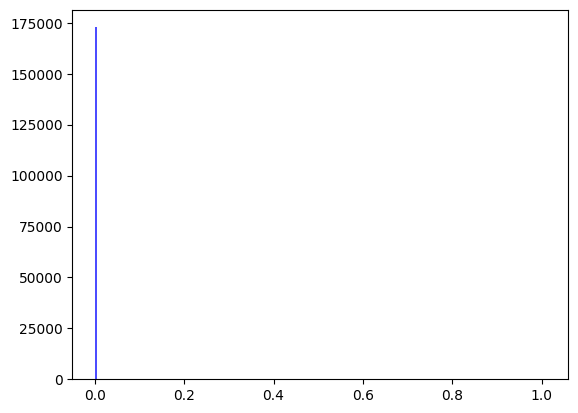

[2023-10-01T20:16:31.867780+00:00] Epochs 46, total loss: 8.74162e+03
[2023-10-01T20:16:31.867989+00:00] Training llk: -1.38037e+00
[2023-10-01T20:16:31.868106+00:00] Testing llk: -1.76195e+00
[2023-10-01T20:16:31.868182+00:00] MAE:0.07378, MRE:0.22353
saving model


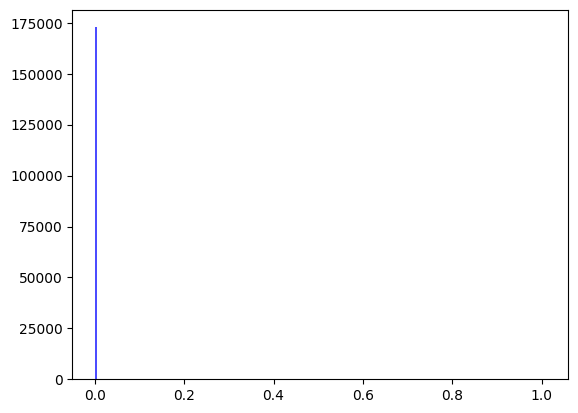

[2023-10-01T20:16:32.796712+00:00] Epochs 47, total loss: 8.74262e+03
[2023-10-01T20:16:32.797598+00:00] Training llk: -1.37723e+00
[2023-10-01T20:16:32.797992+00:00] Testing llk: -1.75825e+00
[2023-10-01T20:16:32.798384+00:00] MAE:0.07026, MRE:0.21232
saving model


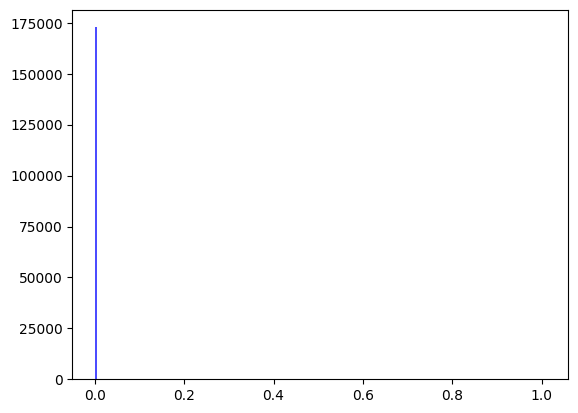

[2023-10-01T20:16:33.694713+00:00] Epochs 48, total loss: 8.68604e+03
[2023-10-01T20:16:33.694948+00:00] Training llk: -1.37717e+00
[2023-10-01T20:16:33.695055+00:00] Testing llk: -1.75816e+00
[2023-10-01T20:16:33.695137+00:00] MAE:0.07136, MRE:0.21321
saving model


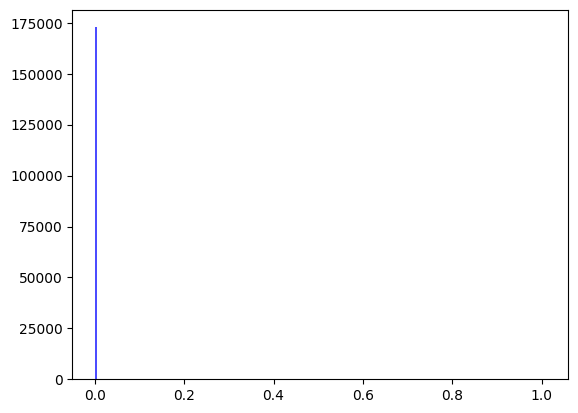

[2023-10-01T20:16:34.644327+00:00] Epochs 49, total loss: 8.23968e+03
[2023-10-01T20:16:34.644607+00:00] Training llk: -1.38147e+00
[2023-10-01T20:16:34.644724+00:00] Testing llk: -1.76331e+00
[2023-10-01T20:16:34.644811+00:00] MAE:0.07781, MRE:0.22788
saving model


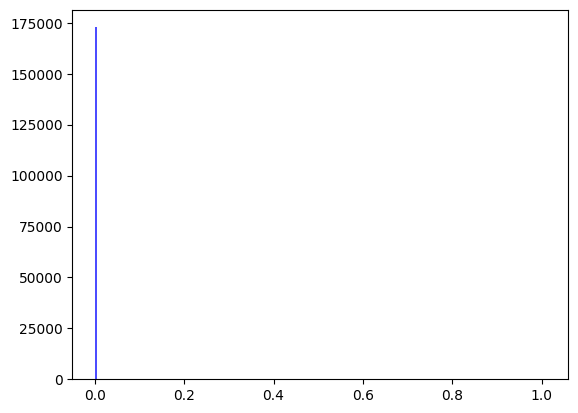

[2023-10-01T20:16:35.914147+00:00] Epochs 50, total loss: 8.51993e+03
[2023-10-01T20:16:35.915295+00:00] Training llk: -1.37638e+00
[2023-10-01T20:16:35.915826+00:00] Testing llk: -1.75723e+00
[2023-10-01T20:16:35.916349+00:00] MAE:0.07223, MRE:0.21174
saving model


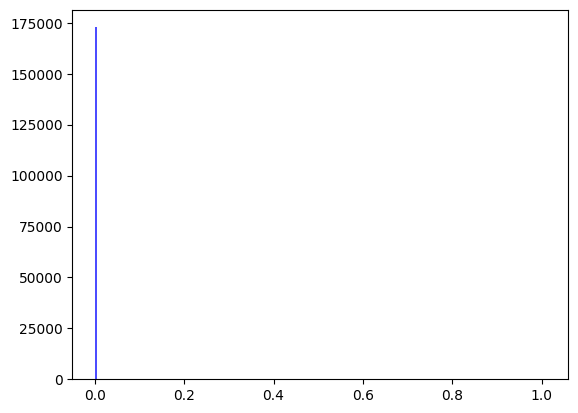

[2023-10-01T20:16:37.759670+00:00] Epochs 51, total loss: 8.90473e+03
[2023-10-01T20:16:37.760858+00:00] Training llk: -1.37503e+00
[2023-10-01T20:16:37.761007+00:00] Testing llk: -1.75564e+00
[2023-10-01T20:16:37.761130+00:00] MAE:0.07121, MRE:0.20732
saving model


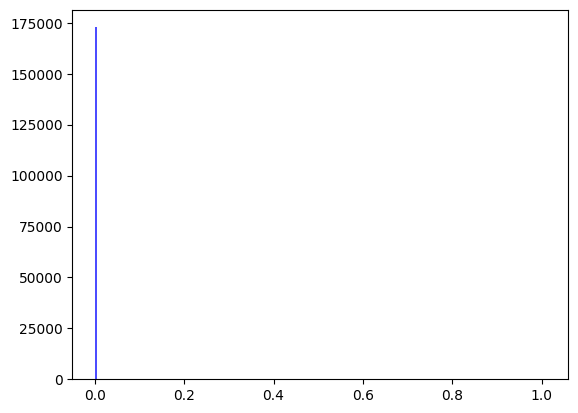

[2023-10-01T20:16:38.704806+00:00] Epochs 52, total loss: 9.14099e+03
[2023-10-01T20:16:38.705125+00:00] Training llk: -1.37383e+00
[2023-10-01T20:16:38.705256+00:00] Testing llk: -1.75424e+00
[2023-10-01T20:16:38.705339+00:00] MAE:0.07037, MRE:0.20338
saving model


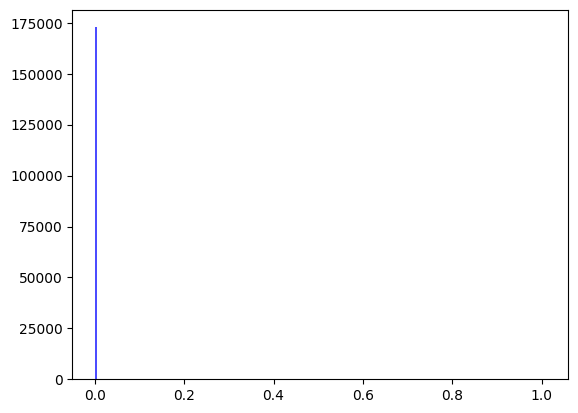

[2023-10-01T20:16:39.743435+00:00] Epochs 53, total loss: 9.49152e+03
[2023-10-01T20:16:39.744120+00:00] Training llk: -1.37218e+00
[2023-10-01T20:16:39.744262+00:00] Testing llk: -1.75232e+00
[2023-10-01T20:16:39.744483+00:00] MAE:0.06864, MRE:0.19731
saving model


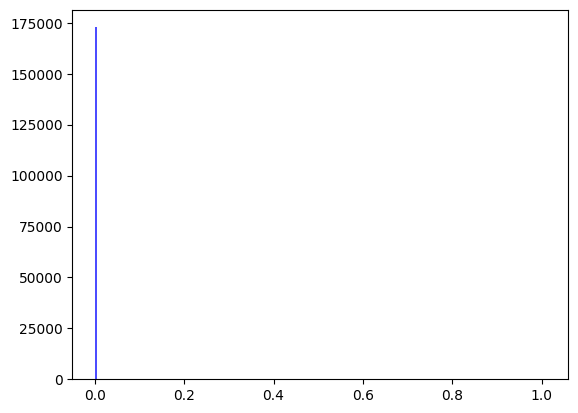

[2023-10-01T20:16:40.747717+00:00] Epochs 54, total loss: 9.25026e+03
[2023-10-01T20:16:40.747949+00:00] Training llk: -1.37098e+00
[2023-10-01T20:16:40.748070+00:00] Testing llk: -1.75094e+00
[2023-10-01T20:16:40.748147+00:00] MAE:0.06749, MRE:0.19285
saving model


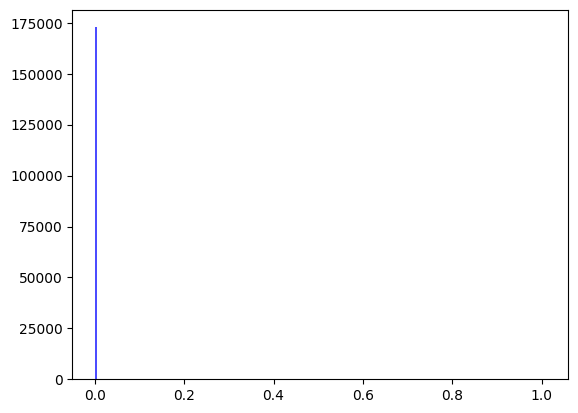

[2023-10-01T20:16:41.719127+00:00] Epochs 55, total loss: 8.33486e+03
[2023-10-01T20:16:41.720396+00:00] Training llk: -1.37586e+00
[2023-10-01T20:16:41.721314+00:00] Testing llk: -1.75670e+00
[2023-10-01T20:16:41.721872+00:00] MAE:0.07552, MRE:0.21115
saving model


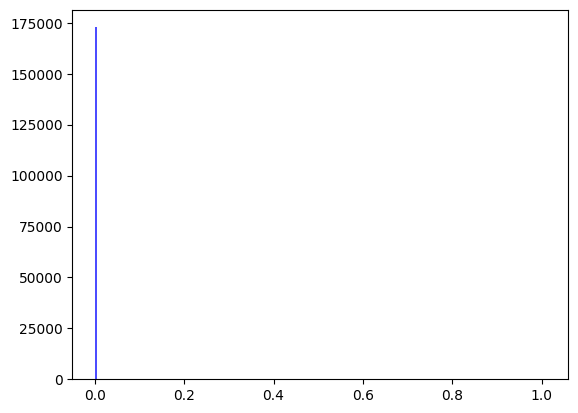

[2023-10-01T20:16:42.663487+00:00] Epochs 56, total loss: 8.41584e+03
[2023-10-01T20:16:42.663694+00:00] Training llk: -1.37114e+00
[2023-10-01T20:16:42.663776+00:00] Testing llk: -1.75112e+00
[2023-10-01T20:16:42.663845+00:00] MAE:0.06961, MRE:0.19521
saving model


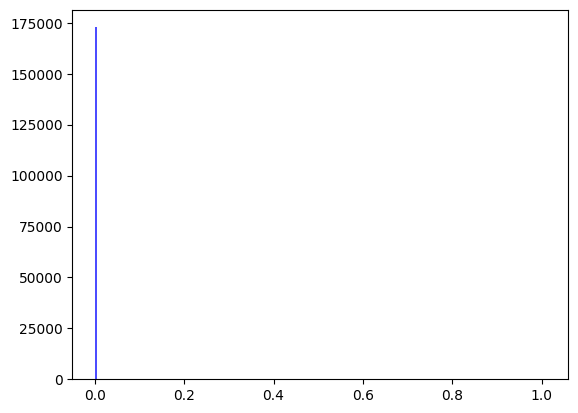

[2023-10-01T20:16:43.892802+00:00] Epochs 57, total loss: 7.95453e+03
[2023-10-01T20:16:43.894009+00:00] Training llk: -1.37353e+00
[2023-10-01T20:16:43.894588+00:00] Testing llk: -1.75397e+00
[2023-10-01T20:16:43.895130+00:00] MAE:0.07380, MRE:0.20398
saving model


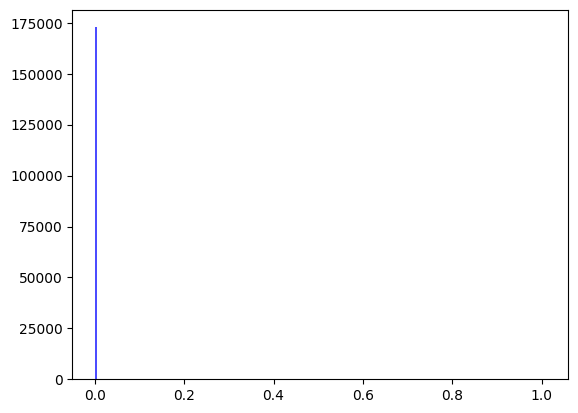

[2023-10-01T20:16:44.809580+00:00] Epochs 58, total loss: 7.88076e+03
[2023-10-01T20:16:44.811692+00:00] Training llk: -1.37811e+00
[2023-10-01T20:16:44.812305+00:00] Testing llk: -1.75954e+00
[2023-10-01T20:16:44.812873+00:00] MAE:0.07955, MRE:0.21653
saving model


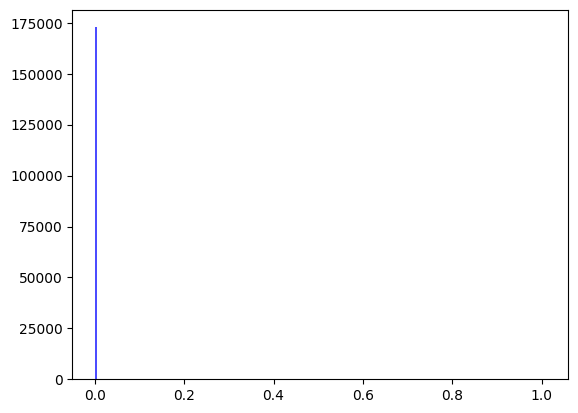

[2023-10-01T20:16:45.722988+00:00] Epochs 59, total loss: 7.79929e+03
[2023-10-01T20:16:45.723301+00:00] Training llk: -1.36980e+00
[2023-10-01T20:16:45.723492+00:00] Testing llk: -1.74959e+00
[2023-10-01T20:16:45.723610+00:00] MAE:0.06964, MRE:0.19125
saving model


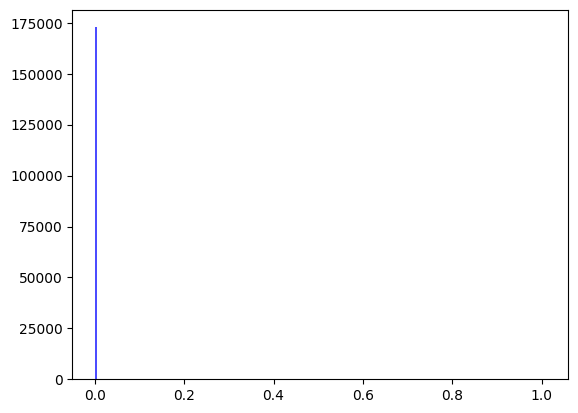

[2023-10-01T20:16:46.670084+00:00] Epochs 60, total loss: 7.65155e+03
[2023-10-01T20:16:46.670330+00:00] Training llk: -1.37420e+00
[2023-10-01T20:16:46.670427+00:00] Testing llk: -1.75487e+00
[2023-10-01T20:16:46.670729+00:00] MAE:0.07615, MRE:0.20563
saving model


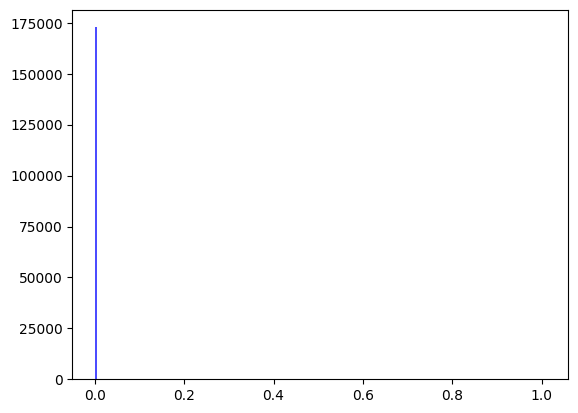

[2023-10-01T20:16:47.591078+00:00] Epochs 61, total loss: 7.33180e+03
[2023-10-01T20:16:47.591344+00:00] Training llk: -1.37183e+00
[2023-10-01T20:16:47.591547+00:00] Testing llk: -1.75204e+00
[2023-10-01T20:16:47.591636+00:00] MAE:0.07368, MRE:0.19853
saving model


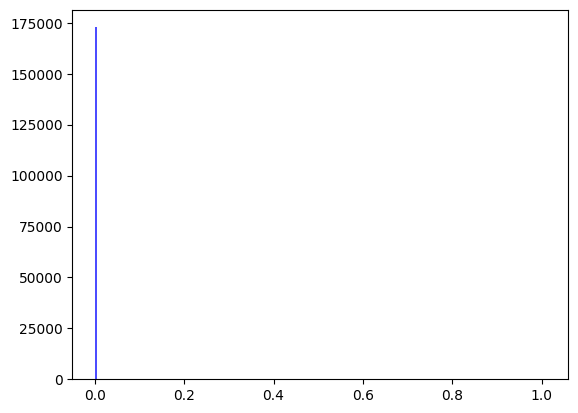

[2023-10-01T20:16:48.910915+00:00] Epochs 62, total loss: 8.56389e+03
[2023-10-01T20:16:48.912150+00:00] Training llk: -1.37209e+00
[2023-10-01T20:16:48.912685+00:00] Testing llk: -1.75238e+00
[2023-10-01T20:16:48.913236+00:00] MAE:0.07446, MRE:0.19921
saving model


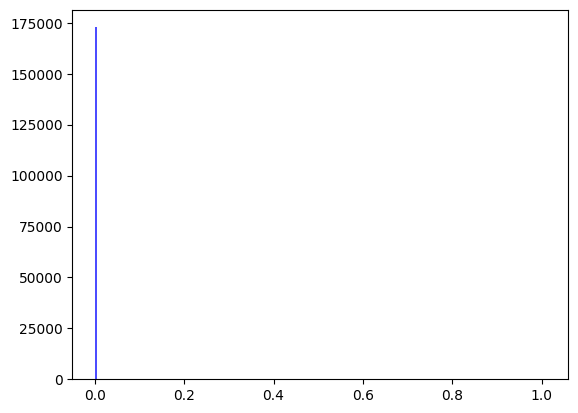

[2023-10-01T20:16:50.593609+00:00] Epochs 63, total loss: 8.74687e+03
[2023-10-01T20:16:50.594466+00:00] Training llk: -1.36948e+00
[2023-10-01T20:16:50.594805+00:00] Testing llk: -1.74930e+00
[2023-10-01T20:16:50.595257+00:00] MAE:0.07142, MRE:0.19087
saving model


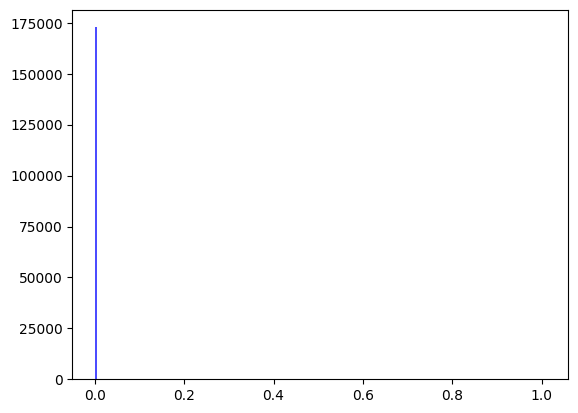

[2023-10-01T20:16:51.494030+00:00] Epochs 64, total loss: 7.59078e+03
[2023-10-01T20:16:51.494991+00:00] Training llk: -1.37177e+00
[2023-10-01T20:16:51.495153+00:00] Testing llk: -1.75206e+00
[2023-10-01T20:16:51.495254+00:00] MAE:0.07490, MRE:0.19791
saving model


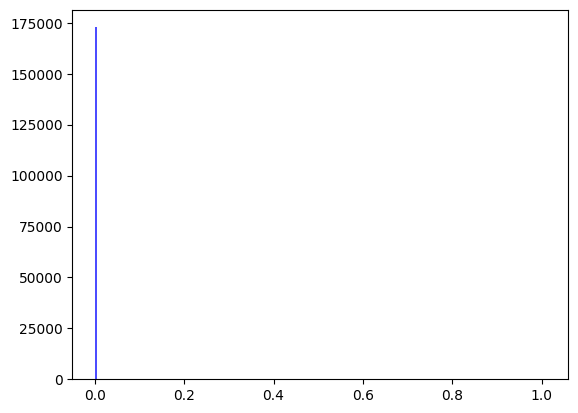

[2023-10-01T20:16:52.405001+00:00] Epochs 65, total loss: 7.73607e+03
[2023-10-01T20:16:52.405320+00:00] Training llk: -1.36910e+00
[2023-10-01T20:16:52.405438+00:00] Testing llk: -1.74890e+00
[2023-10-01T20:16:52.405517+00:00] MAE:0.07185, MRE:0.18962
saving model


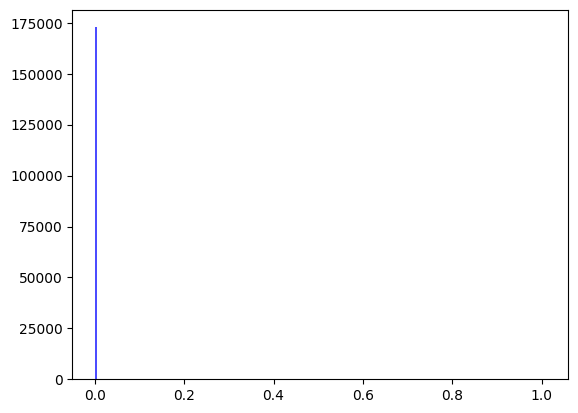

[2023-10-01T20:16:53.358152+00:00] Epochs 66, total loss: 7.95485e+03
[2023-10-01T20:16:53.359356+00:00] Training llk: -1.36767e+00
[2023-10-01T20:16:53.359957+00:00] Testing llk: -1.74723e+00
[2023-10-01T20:16:53.360520+00:00] MAE:0.07019, MRE:0.18469
saving model


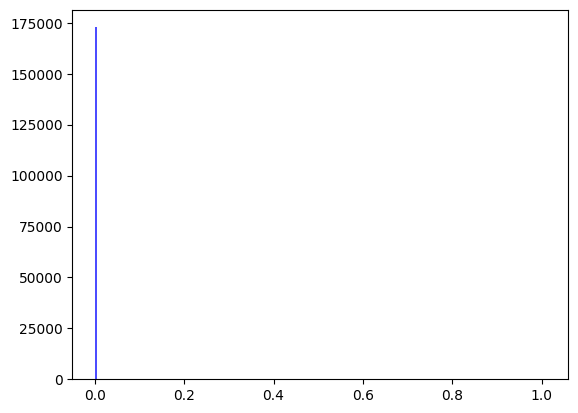

[2023-10-01T20:16:54.295377+00:00] Epochs 67, total loss: 8.45970e+03
[2023-10-01T20:16:54.295671+00:00] Training llk: -1.36733e+00
[2023-10-01T20:16:54.295763+00:00] Testing llk: -1.74686e+00
[2023-10-01T20:16:54.295838+00:00] MAE:0.07016, MRE:0.18355
saving model


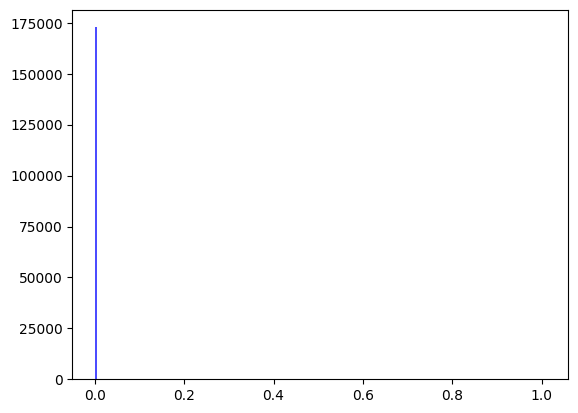

[2023-10-01T20:16:55.235805+00:00] Epochs 68, total loss: 8.32766e+03
[2023-10-01T20:16:55.236093+00:00] Training llk: -1.36918e+00
[2023-10-01T20:16:55.236192+00:00] Testing llk: -1.74909e+00
[2023-10-01T20:16:55.236271+00:00] MAE:0.07322, MRE:0.18955
saving model


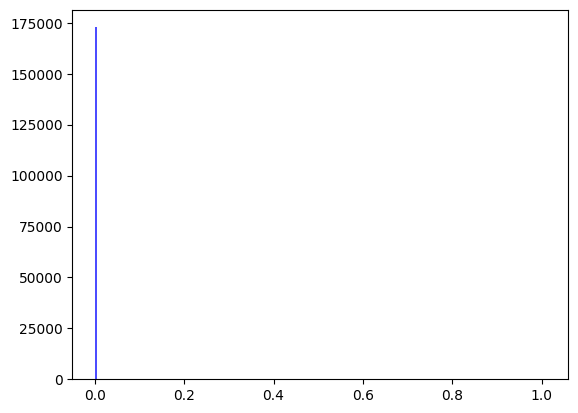

[2023-10-01T20:16:56.459475+00:00] Epochs 69, total loss: 8.27556e+03
[2023-10-01T20:16:56.459756+00:00] Training llk: -1.36816e+00
[2023-10-01T20:16:56.459866+00:00] Testing llk: -1.74790e+00
[2023-10-01T20:16:56.459957+00:00] MAE:0.07224, MRE:0.18623
saving model


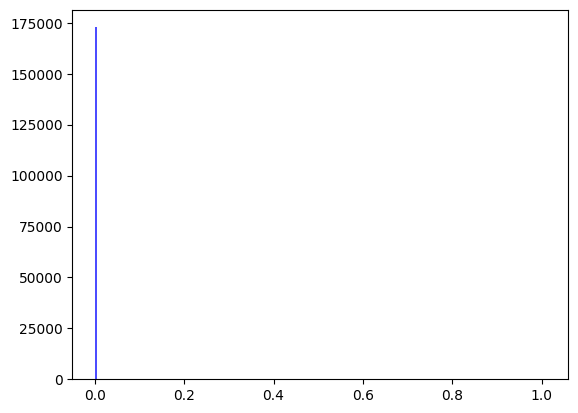

[2023-10-01T20:16:57.434365+00:00] Epochs 70, total loss: 8.46969e+03
[2023-10-01T20:16:57.435365+00:00] Training llk: -1.36491e+00
[2023-10-01T20:16:57.435490+00:00] Testing llk: -1.74411e+00
[2023-10-01T20:16:57.435570+00:00] MAE:0.06762, MRE:0.17461
saving model


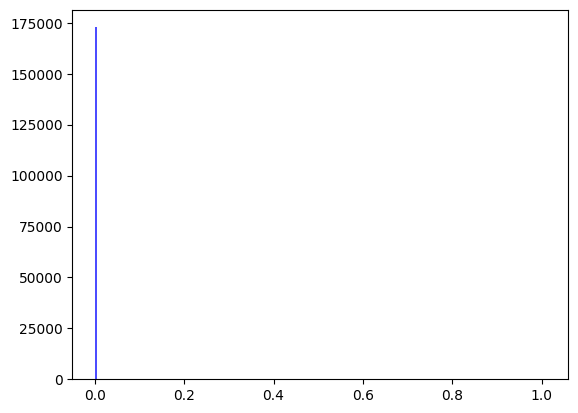

[2023-10-01T20:16:58.386127+00:00] Epochs 71, total loss: 7.11788e+03
[2023-10-01T20:16:58.387073+00:00] Training llk: -1.36724e+00
[2023-10-01T20:16:58.387198+00:00] Testing llk: -1.74688e+00
[2023-10-01T20:16:58.387283+00:00] MAE:0.07176, MRE:0.18305
saving model


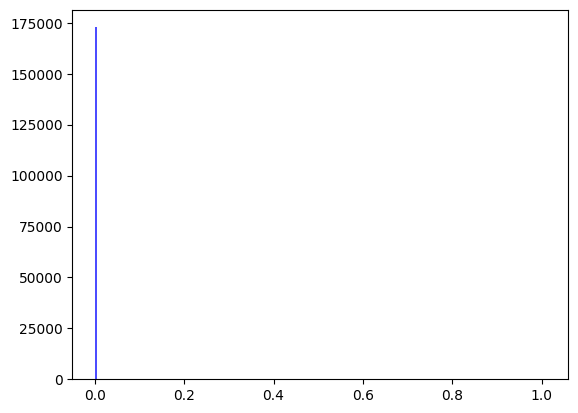

[2023-10-01T20:16:59.339736+00:00] Epochs 72, total loss: 8.28190e+03
[2023-10-01T20:16:59.340463+00:00] Training llk: -1.36658e+00
[2023-10-01T20:16:59.340604+00:00] Testing llk: -1.74612e+00
[2023-10-01T20:16:59.340696+00:00] MAE:0.07119, MRE:0.18077
saving model


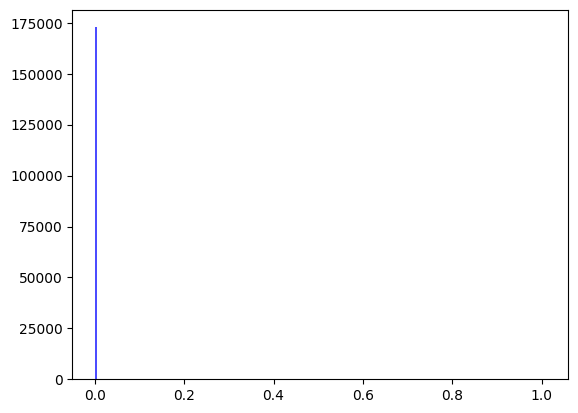

[2023-10-01T20:17:00.312478+00:00] Epochs 73, total loss: 9.10806e+03
[2023-10-01T20:17:00.312725+00:00] Training llk: -1.36652e+00
[2023-10-01T20:17:00.312806+00:00] Testing llk: -1.74609e+00
[2023-10-01T20:17:00.312868+00:00] MAE:0.07148, MRE:0.18044
saving model


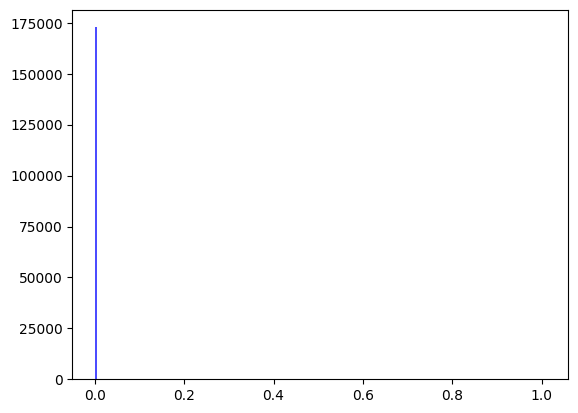

[2023-10-01T20:17:02.445458+00:00] Epochs 74, total loss: 8.63281e+03
[2023-10-01T20:17:02.446598+00:00] Training llk: -1.36500e+00
[2023-10-01T20:17:02.447474+00:00] Testing llk: -1.74432e+00
[2023-10-01T20:17:02.448101+00:00] MAE:0.06956, MRE:0.17523
saving model


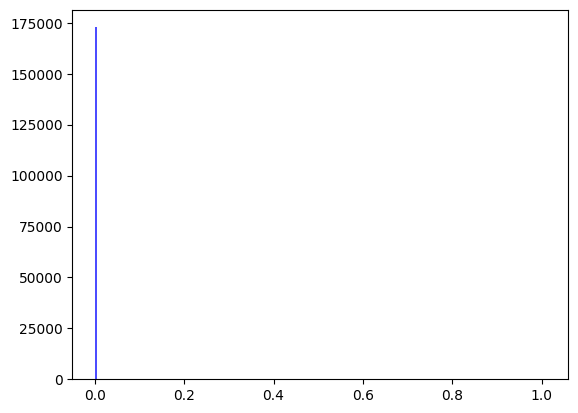

[2023-10-01T20:17:03.941608+00:00] Epochs 75, total loss: 8.44496e+03
[2023-10-01T20:17:03.941896+00:00] Training llk: -1.36830e+00
[2023-10-01T20:17:03.941998+00:00] Testing llk: -1.74830e+00
[2023-10-01T20:17:03.942091+00:00] MAE:0.07442, MRE:0.18518
saving model


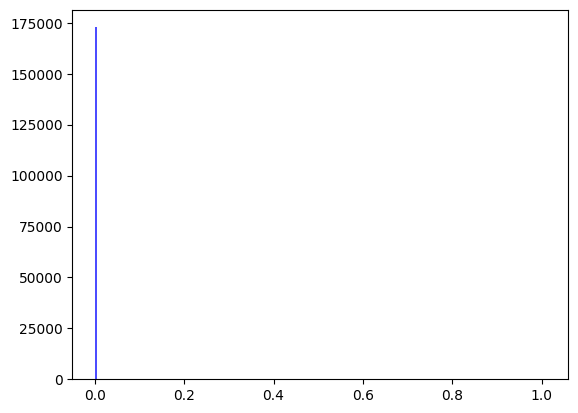

[2023-10-01T20:17:04.864252+00:00] Epochs 76, total loss: 7.80132e+03
[2023-10-01T20:17:04.865148+00:00] Training llk: -1.36589e+00
[2023-10-01T20:17:04.865281+00:00] Testing llk: -1.74543e+00
[2023-10-01T20:17:04.865356+00:00] MAE:0.07154, MRE:0.17791
saving model


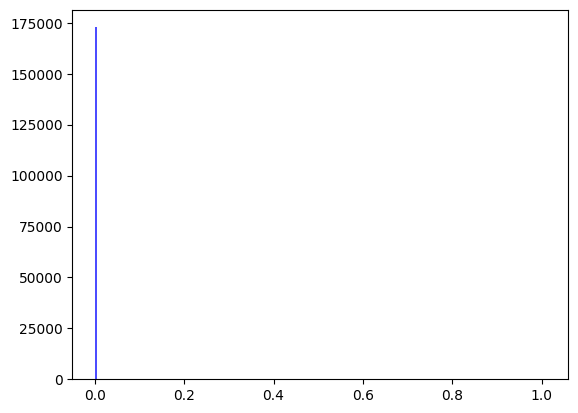

[2023-10-01T20:17:05.776889+00:00] Epochs 77, total loss: 8.09862e+03
[2023-10-01T20:17:05.777779+00:00] Training llk: -1.36407e+00
[2023-10-01T20:17:05.777906+00:00] Testing llk: -1.74332e+00
[2023-10-01T20:17:05.777985+00:00] MAE:0.06912, MRE:0.17174
saving model


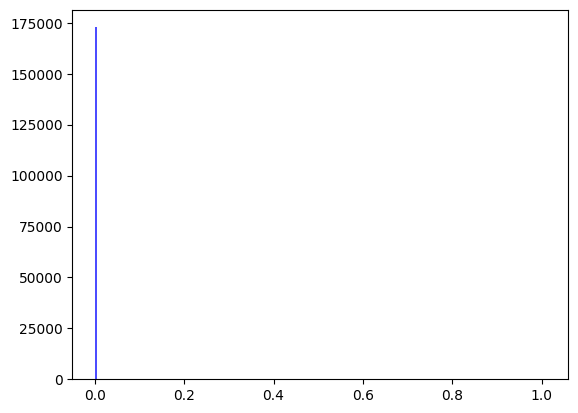

[2023-10-01T20:17:06.673733+00:00] Epochs 78, total loss: 8.13916e+03
[2023-10-01T20:17:06.674091+00:00] Training llk: -1.36249e+00
[2023-10-01T20:17:06.674357+00:00] Testing llk: -1.74151e+00
[2023-10-01T20:17:06.674459+00:00] MAE:0.06671, MRE:0.16561
saving model


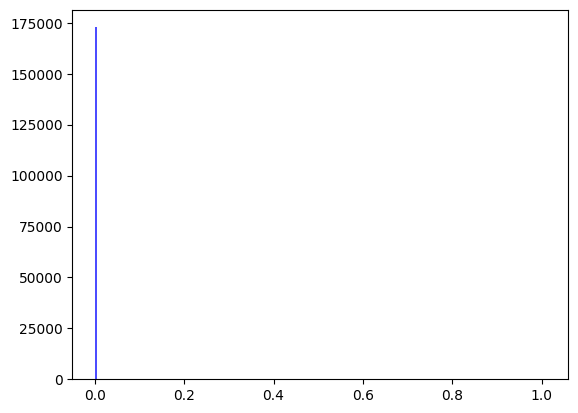

[2023-10-01T20:17:07.635396+00:00] Epochs 79, total loss: 8.70318e+03
[2023-10-01T20:17:07.635628+00:00] Training llk: -1.36489e+00
[2023-10-01T20:17:07.635722+00:00] Testing llk: -1.74435e+00
[2023-10-01T20:17:07.635808+00:00] MAE:0.07097, MRE:0.17419
saving model


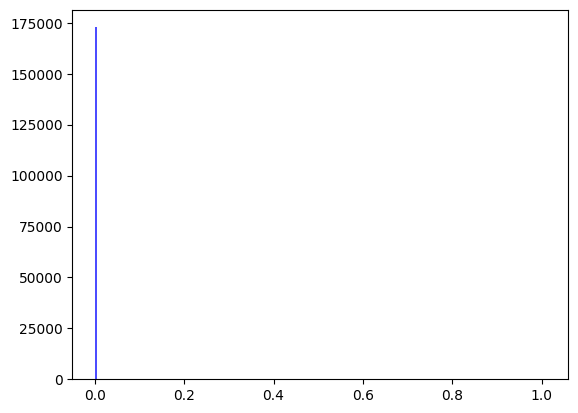

[2023-10-01T20:17:08.510284+00:00] Epochs 80, total loss: 7.97823e+03
[2023-10-01T20:17:08.510567+00:00] Training llk: -1.36543e+00
[2023-10-01T20:17:08.510684+00:00] Testing llk: -1.74503e+00
[2023-10-01T20:17:08.510763+00:00] MAE:0.07198, MRE:0.17565
saving model


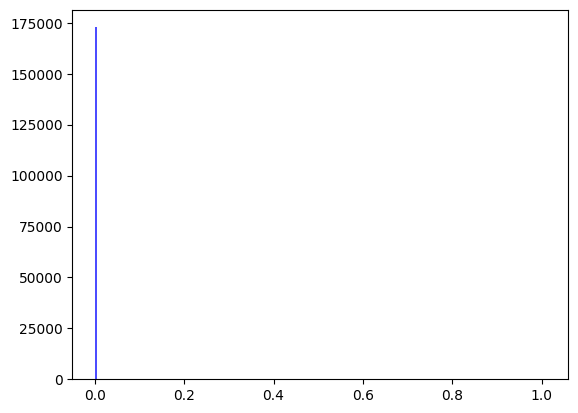

[2023-10-01T20:17:09.784365+00:00] Epochs 81, total loss: 8.15169e+03
[2023-10-01T20:17:09.785471+00:00] Training llk: -1.36725e+00
[2023-10-01T20:17:09.785995+00:00] Testing llk: -1.74726e+00
[2023-10-01T20:17:09.786516+00:00] MAE:0.07451, MRE:0.18048
saving model


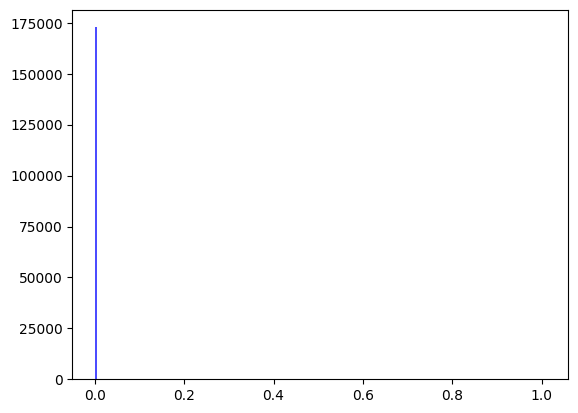

[2023-10-01T20:17:10.717422+00:00] Epochs 82, total loss: 8.27832e+03
[2023-10-01T20:17:10.717691+00:00] Training llk: -1.36379e+00
[2023-10-01T20:17:10.717786+00:00] Testing llk: -1.74315e+00
[2023-10-01T20:17:10.717863+00:00] MAE:0.07012, MRE:0.17014
saving model


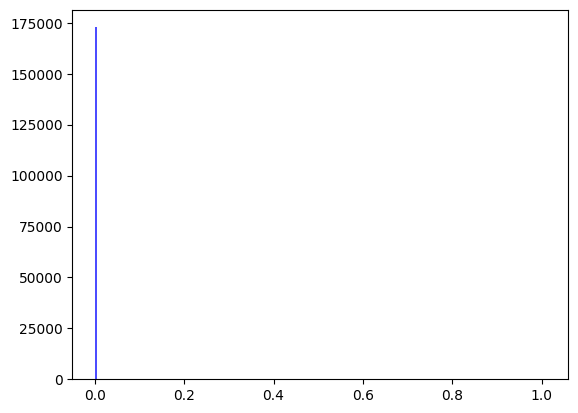

[2023-10-01T20:17:11.751877+00:00] Epochs 83, total loss: 8.58016e+03
[2023-10-01T20:17:11.753116+00:00] Training llk: -1.36242e+00
[2023-10-01T20:17:11.753646+00:00] Testing llk: -1.74156e+00
[2023-10-01T20:17:11.754148+00:00] MAE:0.06820, MRE:0.16526
saving model


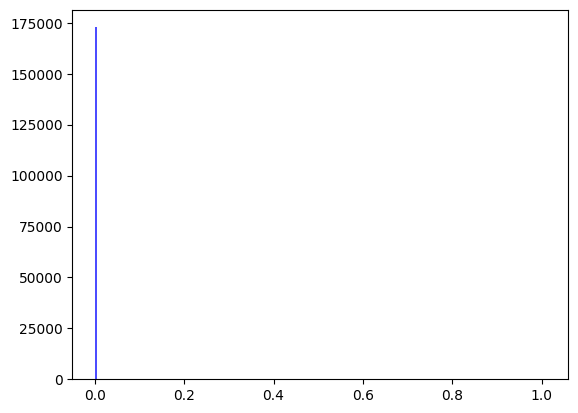

[2023-10-01T20:17:12.687377+00:00] Epochs 84, total loss: 8.35981e+03
[2023-10-01T20:17:12.687665+00:00] Training llk: -1.36658e+00
[2023-10-01T20:17:12.687774+00:00] Testing llk: -1.74656e+00
[2023-10-01T20:17:12.687866+00:00] MAE:0.07427, MRE:0.17770
saving model


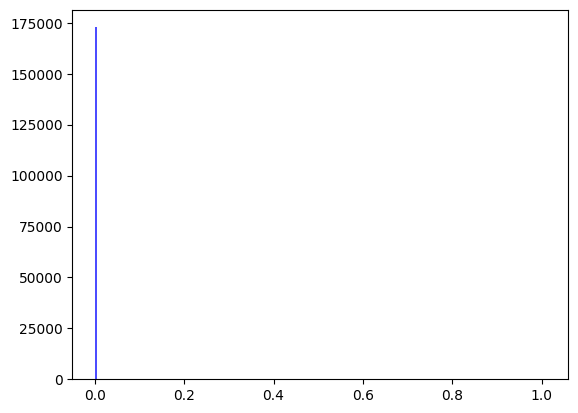

[2023-10-01T20:17:13.815255+00:00] Epochs 85, total loss: 8.37336e+03
[2023-10-01T20:17:13.815533+00:00] Training llk: -1.36174e+00
[2023-10-01T20:17:13.815632+00:00] Testing llk: -1.74082e+00
[2023-10-01T20:17:13.815706+00:00] MAE:0.06758, MRE:0.16251
saving model


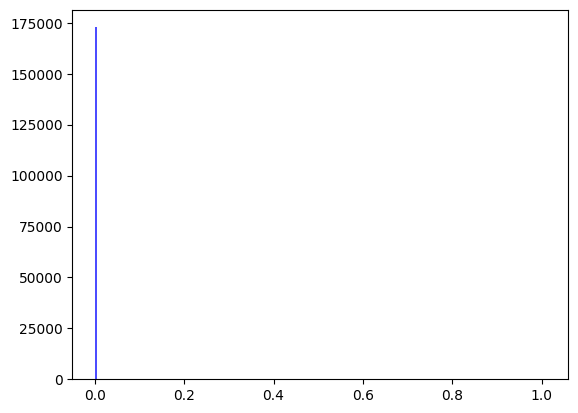

[2023-10-01T20:17:15.158904+00:00] Epochs 86, total loss: 8.45937e+03
[2023-10-01T20:17:15.159585+00:00] Training llk: -1.36373e+00
[2023-10-01T20:17:15.159697+00:00] Testing llk: -1.74320e+00
[2023-10-01T20:17:15.159768+00:00] MAE:0.07094, MRE:0.16910
saving model


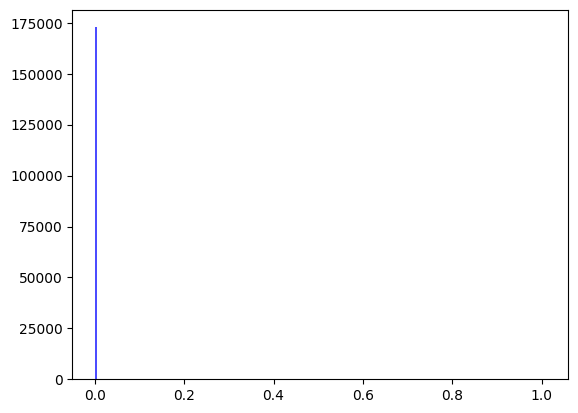

[2023-10-01T20:17:16.742359+00:00] Epochs 87, total loss: 9.07063e+03
[2023-10-01T20:17:16.742729+00:00] Training llk: -1.35933e+00
[2023-10-01T20:17:16.742881+00:00] Testing llk: -1.73813e+00
[2023-10-01T20:17:16.742980+00:00] MAE:0.06312, MRE:0.15164
saving model


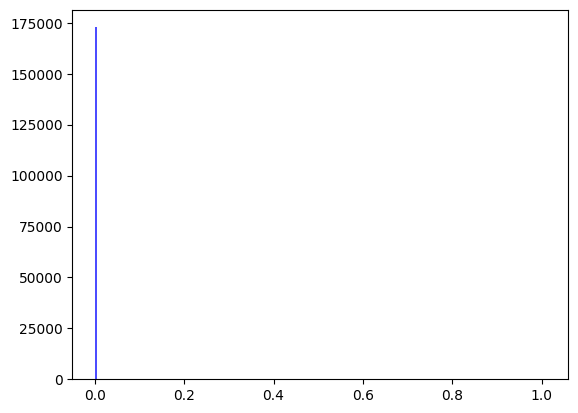

[2023-10-01T20:17:17.729993+00:00] Epochs 88, total loss: 8.56728e+03
[2023-10-01T20:17:17.730920+00:00] Training llk: -1.36560e+00
[2023-10-01T20:17:17.731080+00:00] Testing llk: -1.74553e+00
[2023-10-01T20:17:17.731168+00:00] MAE:0.07377, MRE:0.17383
saving model


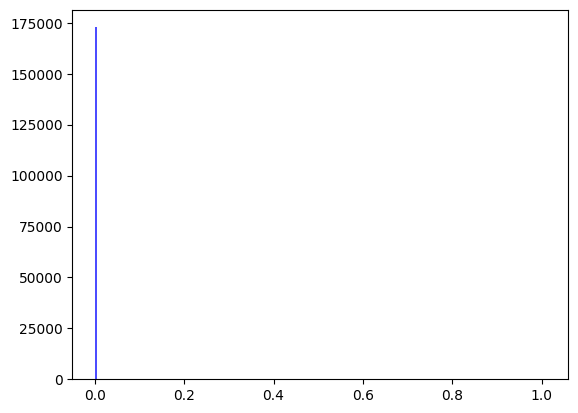

[2023-10-01T20:17:18.724411+00:00] Epochs 89, total loss: 7.89439e+03
[2023-10-01T20:17:18.725406+00:00] Training llk: -1.36289e+00
[2023-10-01T20:17:18.725539+00:00] Testing llk: -1.74231e+00
[2023-10-01T20:17:18.725617+00:00] MAE:0.07031, MRE:0.16581
saving model


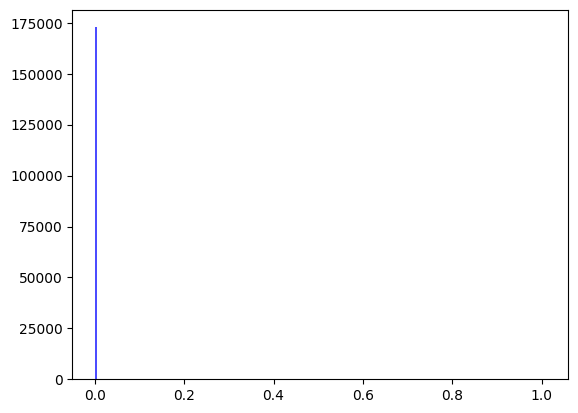

[2023-10-01T20:17:19.685647+00:00] Epochs 90, total loss: 8.63286e+03
[2023-10-01T20:17:19.686599+00:00] Training llk: -1.35985e+00
[2023-10-01T20:17:19.686727+00:00] Testing llk: -1.73878e+00
[2023-10-01T20:17:19.686808+00:00] MAE:0.06531, MRE:0.15454
saving model


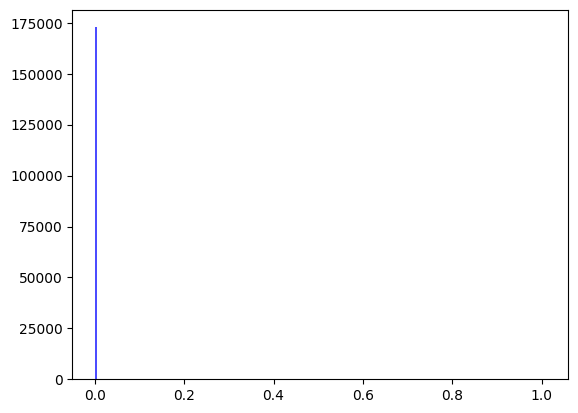

[2023-10-01T20:17:20.589136+00:00] Epochs 91, total loss: 7.62848e+03
[2023-10-01T20:17:20.589438+00:00] Training llk: -1.36496e+00
[2023-10-01T20:17:20.589555+00:00] Testing llk: -1.74486e+00
[2023-10-01T20:17:20.589640+00:00] MAE:0.07342, MRE:0.17116
saving model


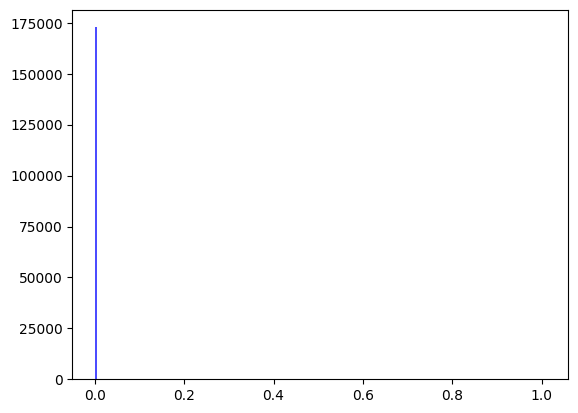

[2023-10-01T20:17:21.479156+00:00] Epochs 92, total loss: 8.00273e+03
[2023-10-01T20:17:21.480098+00:00] Training llk: -1.36151e+00
[2023-10-01T20:17:21.480225+00:00] Testing llk: -1.74077e+00
[2023-10-01T20:17:21.480309+00:00] MAE:0.06876, MRE:0.16069
saving model


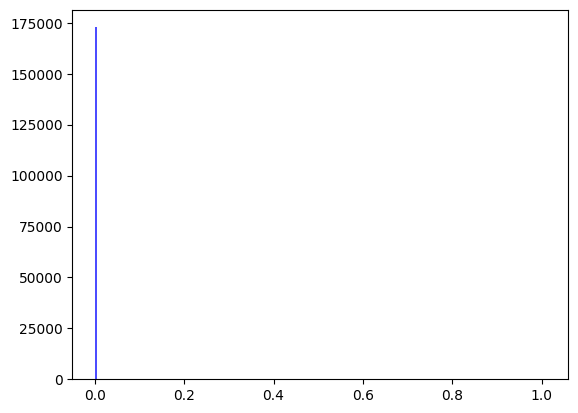

[2023-10-01T20:17:22.679591+00:00] Epochs 93, total loss: 8.13276e+03
[2023-10-01T20:17:22.679852+00:00] Training llk: -1.36528e+00
[2023-10-01T20:17:22.679951+00:00] Testing llk: -1.74531e+00
[2023-10-01T20:17:22.680035+00:00] MAE:0.07407, MRE:0.17136
saving model


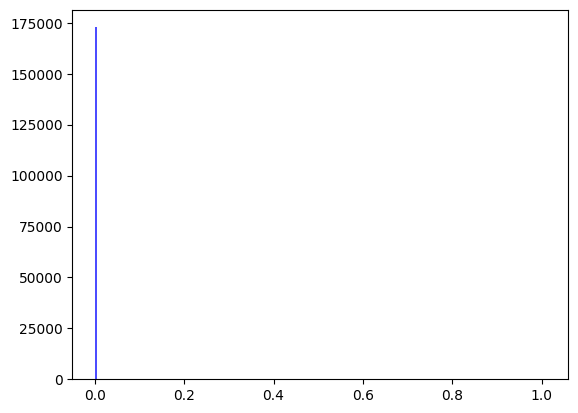

[2023-10-01T20:17:23.619915+00:00] Epochs 94, total loss: 8.30059e+03
[2023-10-01T20:17:23.620213+00:00] Training llk: -1.36124e+00
[2023-10-01T20:17:23.620326+00:00] Testing llk: -1.74051e+00
[2023-10-01T20:17:23.620416+00:00] MAE:0.06866, MRE:0.15943
saving model


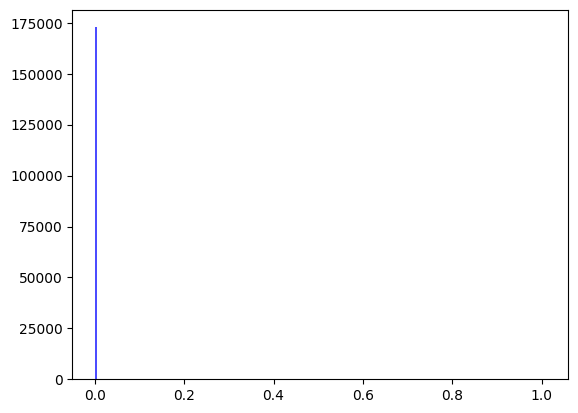

[2023-10-01T20:17:24.516984+00:00] Epochs 95, total loss: 9.03606e+03
[2023-10-01T20:17:24.517883+00:00] Training llk: -1.36124e+00
[2023-10-01T20:17:24.518003+00:00] Testing llk: -1.74054e+00
[2023-10-01T20:17:24.518100+00:00] MAE:0.06880, MRE:0.15926
saving model


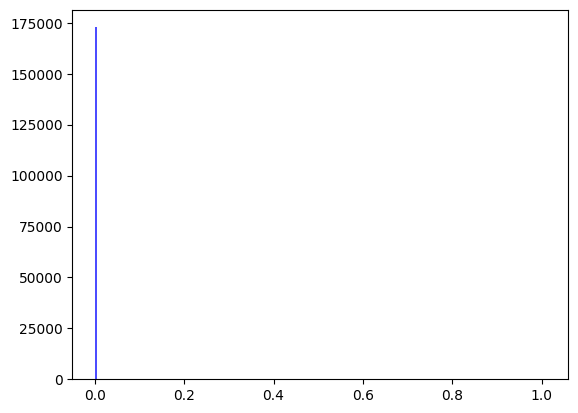

[2023-10-01T20:17:25.404923+00:00] Epochs 96, total loss: 7.91910e+03
[2023-10-01T20:17:25.406050+00:00] Training llk: -1.36088e+00
[2023-10-01T20:17:25.406568+00:00] Testing llk: -1.74014e+00
[2023-10-01T20:17:25.407069+00:00] MAE:0.06838, MRE:0.15784
saving model


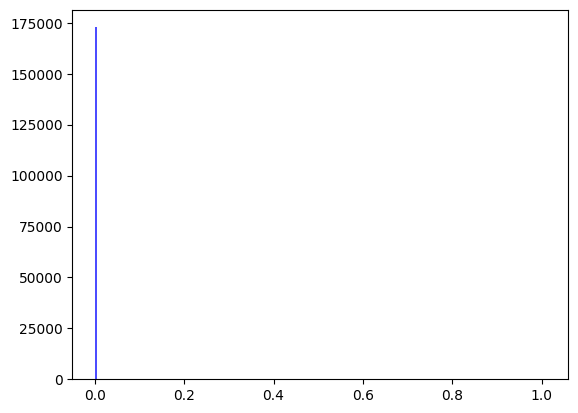

[2023-10-01T20:17:26.305081+00:00] Epochs 97, total loss: 8.11908e+03
[2023-10-01T20:17:26.305362+00:00] Training llk: -1.36372e+00
[2023-10-01T20:17:26.305469+00:00] Testing llk: -1.74356e+00
[2023-10-01T20:17:26.305554+00:00] MAE:0.07258, MRE:0.16614
saving model


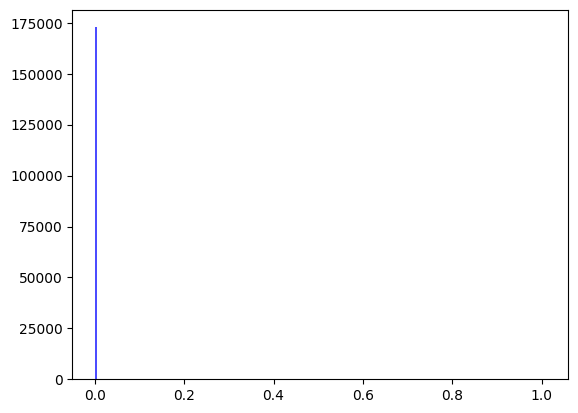

[2023-10-01T20:17:28.017418+00:00] Epochs 98, total loss: 7.65213e+03
[2023-10-01T20:17:28.018555+00:00] Training llk: -1.36261e+00
[2023-10-01T20:17:28.019067+00:00] Testing llk: -1.74225e+00
[2023-10-01T20:17:28.019585+00:00] MAE:0.07121, MRE:0.16279
saving model


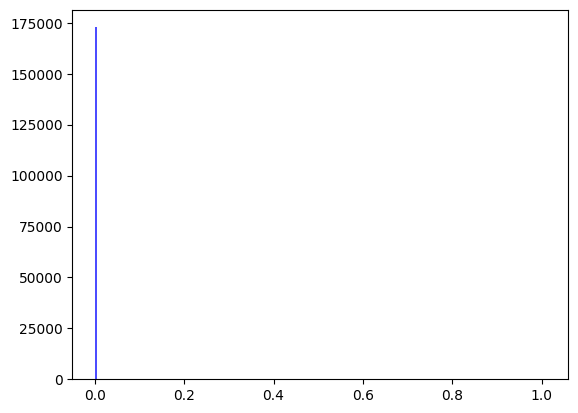

[2023-10-01T20:17:29.290115+00:00] Epochs 99, total loss: 8.60131e+03
[2023-10-01T20:17:29.290544+00:00] Training llk: -1.36117e+00
[2023-10-01T20:17:29.291299+00:00] Testing llk: -1.74056e+00
[2023-10-01T20:17:29.291558+00:00] MAE:0.06925, MRE:0.15820
saving model
training done!


In [ ]:
for Tm in [100.]:
  print(Tm)
  T = [buffer_end_time, Tm]
  tau_max = 10.
  baserate = true_mu
  nsample = 10
  n_class = 1
  int_res = 200
  hid_dim = 64
  batch_size = 16
  train_size = 1000
  lr = 0.2
  epoch = 100
  config = config_generate(T0=str(T[0]),
                          T1=str(T[1]),
                          tau_max=str(tau_max),
                          nsample=str(nsample),
                          int_res=str(int_res),
                          n_class=str(n_class),
                          lr=str(lr),
                          epoch=str(epoch),
                          hid_dim=str(hid_dim),
                          batch_size=str(batch_size))
  config.own_event_embed = False
  config.bptt = 10
  config.alpha = true_alpha

  train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
  train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
  for i in range(train_data.shape[0]):
      seq = raw_train_data[i]
      train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

  train_data_ = generate_event_mark(train_data)

  # seeds = [300, 816, 2999]
  # seeds = [1000, 2000, 3000]
  seeds = [0]

  for seed in seeds:
      # torch.random.manual_seed(seed)
      random.seed(seed)

      train_idx = np.arange(train_data_.shape[0])
      # random.shuffle(train_idx)
      train_data2 = train_data_[train_idx[:train_size]]
      buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

      rmtpp_model = RMTPP_new(config, device)
      num_paras = count_parameters(rmtpp_model)
      print("#parameters: %d" % num_paras)

      for name, parameter in rmtpp_model.named_parameters():
          if name == "baserate_mu":
              # parameter.data.fill_(random.uniform(0.4, 0.5))
              parameter.data.fill_(baserate)
          else:
              parameter.data.fill_(random.gauss(0, 0.01))

      ts = np.linspace(test_time[0], test_time[1], ngrid)
      true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)


      rmtpp_model, train_llks, test_llks, test_maes, test_mres, wall_time = model_train(train_data2,
                                                                                      test_data_,
                                                                                      buffer_train_data2,
                                                                                      buffer_test_data_,
                                                                                      rmtpp_model,
                                                                                      config,
                                                                                      device,
                                                                                      True, ts, true_lams)


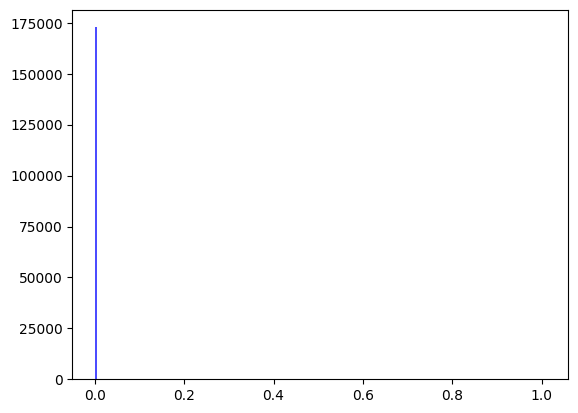

Text(0.5, 1.0, 'Conditional Intensity')

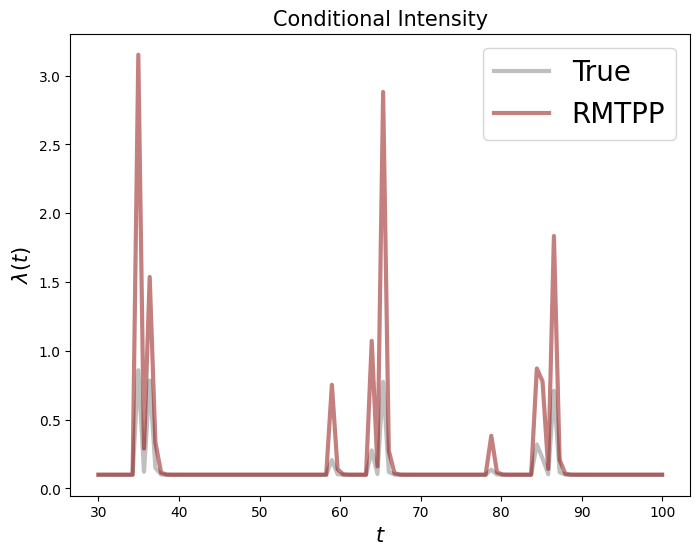

In [ ]:
ts = np.linspace(test_time[0], test_time[1], ngrid)

rmtpp_lams = rmtpp_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 0
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, rmtpp_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="RMTPP")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)